In [84]:
import sys
import torch


seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy
import matplotlib.pyplot as plt 
import seaborn as sns

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import *
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


### Model

In [2]:
depth = 6

# OLD MODELS
# MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth{depth}_Jan24+CCS+RT.pt" # OG model
# MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_2_OS_depth{depth}_June24+CCS+RT.pt" # OS model (first try)

# NEW AND SHINY
MODEL_PATH = f"{home}/data/metabolites/pretrained_models/v0.0.1_merged_depth{depth}_Aug24_sqrt+CCS+RT_drop3.pt" # New sqrt model (improved) | Note: drop3 uses dropout reduction while training RT, CCS
# MODEL_PATH = f"{home}/data/metabolites/pretrained_models/v0.0.1_OS_depth{depth}_Aug24_sqrt_4.pt" # or Aug24_sqrt_x are new OS models

#v: str = "0.1.0"
#MODEL_PATH = f"../models/fiora_OS_v{v}.pt" # Release version

from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework


try:
    model = GNNCompiler.load_from_state_dict(MODEL_PATH)
except:
    raise NameError("Error: Failed loading from state dict.")
    

/home/ynowatzk/miniforge3/envs/fiora/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
has_m_plus = False
if "setup_features_categorical_set" in model.model_params.keys():
    print(model.model_params["setup_features_categorical_set"]["precursor_mode"])
    if "[M]+" in model.model_params["setup_features_categorical_set"]["precursor_mode"]:
        has_m_plus = True

## Data

In [4]:
# key map to read metadata from pandas DataFrame
# metadata_key_map = {
#                 "name": "Name",
#                 "collision_energy":  "CE", 
#                 "instrument": "Instrument_type",
#                 "ionization": "Ionization",
#                 "precursor_mz": "PrecursorMZ",
#                 "precursor_mode": "Precursor_type",
#                 "retention_time": "RETENTIONTIME",
#                 "ccs": "CCS"
#                 }


#
# Load specified libraries and align metadata
#

def load_training_data():
    L = LibraryLoader()
    df = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv")
    return df

def load_msnlib():
    L = LibraryLoader()
    df = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_msnlib_Aug24_v3.csv")
    return df


df = load_training_data()
df_msnlib = load_msnlib()

# Restore dictionary values
dict_columns = ["peaks", "summary"]
for col in dict_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    df_msnlib[col] = df_msnlib[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    #df[col] = df[col].apply(ast.literal_eval)
    
df['group_id'] = df['group_id'].astype(int)


In [5]:
print(df.groupby("lib")["group_id"].unique().apply(len))
print(df["lib"].value_counts())
print(len(df["group_id"].unique()))


lib
MSDIAL    4408
NIST      7271
Name: group_id, dtype: int64
lib
NIST      54814
MSDIAL    19587
Name: count, dtype: int64
10692


In [6]:
print(df.groupby("dataset")["group_id"].unique().apply(len))

print("Reducing data to test set.")
df_train = df[df["dataset"] != "test"]
df_test = df[df["dataset"] == "test"]

df_msnlib_train = df_msnlib[df_msnlib["dataset"] != "test"]
df_msnlib_test = df_msnlib[df_msnlib["dataset"] == "test"]


dataset
test          1070
training      8552
validation    1070
Name: group_id, dtype: int64
Reducing data to test set.


In [7]:
%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder


CE_upper_limit = 100.0
weight_upper_limit = 1000.0

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
model_setup_feature_sets = None
if "setup_features_categorical_set" in model.model_params.keys():
    model_setup_feature_sets = model.model_params["setup_features_categorical_set"]    
    # TODO Refactor this:
    for i, data in df_test.iterrows():
        df_test.loc[i]["summary"]["instrument"] = "HCD"
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"], sets_overwrite=model_setup_feature_sets)
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"], sets_overwrite=model_setup_feature_sets)


def process_dataframes(df_train, df_test):

    df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
    df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)
    df_test["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())


    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

    df_test["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
    df_test.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

    #df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
    df_test.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_train.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], process_metadata=False), axis=1)

    df_test["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
    df_test.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

    return df_train, df_test

In [8]:
df_train, df_test = process_dataframes(df_train, df_test)
df_msnlib_train, df_msnlib_test = process_dataframes(df_msnlib_train, df_msnlib_test)

/tmp/ipykernel_967695/1910795642.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
/tmp/ipykernel_967695/1910795642.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)


##### Load Casmi data

In [9]:
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cast = pd.read_csv(f"{home}/data/metabolites/CASMI_2016/casmi16t_withCCS.csv", index_col=[0], low_memory=False) # f"{home}/data/metabolites/CASMI_2016/casmi16_training_combined.csv"
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)
    df_cast[col] = df_cast[col].apply(ast.literal_eval)

df_cas["is_priority"] = True
df_cast["is_priority"] = False
df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)
df_cas22["ChallengeNum"] = df_cas22["ChallengeName"].apply(lambda x: int(x.split("-")[-1]))
df_cas22["is_priority"] = (df_cas22["ChallengeNum"] < 250).astype(bool)




def closest_cfm_ce(CE):
    ref = np.array([10, 20, 40])
    abs_error = abs(ref - CE)
    i = np.argmin(abs_error)
    return str(ref[i])

In [10]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cas["dataset"] = "CASMI 16"
df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=300 * PPM), axis=1)

#
# CASMI 22
#

df_cas22["dataset"] = "CASMI 22"
df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)
df_cas22 = df_cas22[df_cas22["CE"] < CE_upper_limit] 
df_cas22 = df_cas22[df_cas22["CE"] > 0] 
#df_cas22 = df_cas22[df_cas22.is_priority]

metadata_key_map22 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map22.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=300 * PPM), axis=1) # Optional: use mz_cut instead

df_cas22 = df_cas22.reset_index()

df_cas22["library"] = "CASMI-22"
df_cas22["RETENTIONTIME"] = df_cas22["ChallengeRT"] # "RT_min"
df_cas22["cfm_CE"] = df_cas22["CE"].apply(closest_cfm_ce)
df_cas22[["NCE", "CE", "cfm_CE"]]

In [11]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cast["dataset"] = "CASMI 16 Training"
df_cast["RETENTIONTIME"] = df_cast["RTINSECONDS"] / 60.0
df_cast["Metabolite"] = df_cast["SMILES"].apply(Metabolite)
df_cast["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cast["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cast["CE"] = 20.0 # actually stepped 20/35/50
df_cast["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cast["summary"] = df_cast.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cast.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cast["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cast.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=300 * PPM), axis=1)


## Model Training and Testing

In [12]:
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
 dev = "cuda:1"
else: 
 dev = "cpu" 

print(f"Running on device: {dev}")




Running on device: cuda:1


##### Prepare Model

In [13]:


model.eval()
model = model.to(dev)

fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)


model.model_params

{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 6,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 9,
 'static_rt_feature_dimension': 8,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument'],
 'training_label': 'compiled_probsALL',
 'rt_supported': True,
 'ccs_supported': True}

In [14]:
np.seterr(invalid='ignore')
def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF):
    dft = simulate_all(model, DF)
    return dft

##### Test CASMI 16 and 22

In [15]:
from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum


def test_cas16(model, df_cas=df_cas):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20")

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3
    df_cas["CE"] = df_cas["avg_CE"]
    
    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["sim_peaks"] = df_cas["merged_peaks"] 
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_sqrt_bias"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, with_bias=True)[1], axis=1)
    df_cas["merged_sqrt_cosine_wo_precursor"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, remove_mz=x["Metabolite"].get_theoretical_precursor_mz(x["Metabolite"].metadata["precursor_mode"])), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_cosine"] = df_cas["merged_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine_wo_prec"] = df_cas["merged_sqrt_cosine_wo_precursor"] # just remember it is merged
    df_cas["spectral_sqrt_bias"] = df_cas["merged_sqrt_bias"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"

    
    df_cas["cfm_CE"] = df_cas["avg_CE"].apply(closest_cfm_ce)
    
    return df_cas

In [16]:
print(f"Testing the model")
np.seterr(invalid='ignore')
df_test = test_model(model, df_test)
df_msnlib_test = test_model(model, df_msnlib_test)
df_cas = test_cas16(model)
df_cast = test_cas16(model, df_cas=df_cast)
df_cas22 = test_model(model, df_cas22)
print("Done")

Testing the model


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np

Done


#### READ CFM-ID Results

In [17]:
import fiora.IO.cfmReader as cfmReader

cf = cfmReader.read(f"{home}/data/metabolites/cfm-id/msnlib_test_split_negative_predictions.txt", as_df=True)
cf_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/msnlib_test_split_positive_predictions.txt", as_df=True)
cf["ion_type"] = "negative" 
cf_p["ion_type"] = "positive" 
cf = pd.concat([cf, cf_p])
cf["#ID"] = cf["#ID"].astype(int)
df_msnlib_test["cfm_CE"] = df_msnlib_test["CE"].apply(closest_cfm_ce)
df_msnlib_test["cfm_peaks"] = None
df_msnlib_test[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, data in df_msnlib_test.iterrows():
    group_id = int(data["group_id"])
    precursor_type = data["Precursor_type"]

    if len(cf[(cf["#ID"] == group_id) & (cf["Precursor_type"] == precursor_type)]) < 1:
        print(f"{group_id} not found in CFM-ID results. Skipping.")
        continue
    
    cfm_data = cf[(cf["#ID"] == group_id) & (cf["Precursor_type"] == precursor_type)].iloc[0]
    
    
    cfm_peaks = cfm_data["peaks" + data["cfm_CE"]] # find best reference CE
    df_msnlib_test.at[i, "cfm_peaks"] = cfm_peaks
    df_msnlib_test.at[i, "cfm_cosine"] = spectral_cosine(data["peaks"], cfm_peaks)
    df_msnlib_test.at[i, "cfm_sqrt_cosine"] = spectral_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_msnlib_test.at[i, "cfm_sqrt_cosine_wo_prec"] = spectral_cosine(data["peaks"], cfm_peaks, transform=np.sqrt, remove_mz=data["Metabolite"].get_theoretical_precursor_mz(ion_type=data["Metabolite"].metadata["precursor_mode"]))
    df_msnlib_test.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_msnlib_test.at[i, "cfm_steins"] = reweighted_dot(data["peaks"], cfm_peaks)

945 not found in CFM-ID results. Skipping.
1146 not found in CFM-ID results. Skipping.
1146 not found in CFM-ID results. Skipping.
1146 not found in CFM-ID results. Skipping.
1146 not found in CFM-ID results. Skipping.
1852 not found in CFM-ID results. Skipping.
2047 not found in CFM-ID results. Skipping.
2047 not found in CFM-ID results. Skipping.
2047 not found in CFM-ID results. Skipping.
4507 not found in CFM-ID results. Skipping.
4507 not found in CFM-ID results. Skipping.
4507 not found in CFM-ID results. Skipping.
4507 not found in CFM-ID results. Skipping.
4507 not found in CFM-ID results. Skipping.
4507 not found in CFM-ID results. Skipping.
4507 not found in CFM-ID results. Skipping.
4821 not found in CFM-ID results. Skipping.
4821 not found in CFM-ID results. Skipping.
5009 not found in CFM-ID results. Skipping.
5009 not found in CFM-ID results. Skipping.
5314 not found in CFM-ID results. Skipping.
740 not found in CFM-ID results. Skipping.
740 not found in CFM-ID results. S

In [18]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s

cf = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_negative_predictions.txt", as_df=True)
cf_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_positive_predictions.txt", as_df=True)
cf = pd.concat([cf, cf_p])
len(cf[cf["#ID"] == "Challenge-009"]) ## missing chalenges
df_cas["cfm_peaks"] = None
df_cas[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf[cf["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf[cf["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas.at[i, "cfm_peaks"] = cfm_peaks
    df_cas.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_sqrt_cosine_wo_prec"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt, remove_mz=cas["Metabolite"].get_theoretical_precursor_mz(ion_type=cas["Metabolite"].metadata["precursor_mode"]))
    df_cas.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

Challenge-009 not found in CFM-ID results. Skipping.
Challenge-051 not found in CFM-ID results. Skipping.
Challenge-053 not found in CFM-ID results. Skipping.
Challenge-066 not found in CFM-ID results. Skipping.


In [19]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s

cf = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16t_negative_predictions.txt", as_df=True)
cf_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16t_positive_predictions.txt", as_df=True)
cf = pd.concat([cf, cf_p])
len(cf[cf["#ID"] == "Challenge-009"]) ## missing chalenges
df_cast["cfm_peaks"] = None
df_cast[["cfm_cosine", "cfm_sqrt_cosine", "ice_sqrt_cosine_wo_prec", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cast.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf[cf["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf[cf["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cast.at[i, "cfm_peaks"] = cfm_peaks
    df_cast.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cast.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cast.at[i, "cfm_sqrt_cosine_wo_prec"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt, remove_mz=cas["Metabolite"].get_theoretical_precursor_mz(ion_type=cas["Metabolite"].metadata["precursor_mode"]))
    df_cast.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cast.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

Training-004 not found in CFM-ID results. Skipping.
Training-005 not found in CFM-ID results. Skipping.
Training-006 not found in CFM-ID results. Skipping.
Training-054 not found in CFM-ID results. Skipping.


In [20]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s



cf22 = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_negative_predictions.txt", as_df=True)
cf22_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_positive_predictions.txt", as_df=True)
cf22 = pd.concat([cf22, cf22_p])
df_cas22["cfm_peaks"] = None
df_cas22[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas22.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf22[cf22["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf22[cf22["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas22.at[i, "cfm_peaks"] = cfm_peaks
    df_cas22.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas22.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_sqrt_cosine_wo_prec"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt, remove_mz=cas["Metabolite"].get_theoretical_precursor_mz(ion_type=cas["Metabolite"].metadata["precursor_mode"]))
    df_cas22.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)
    
df_cas22["is_priority"] = df_cas22["is_priority"].astype(bool)

In [21]:

ex_smiles = "CC(NC(=O)CC1=CNC2=C1C=CC=C2)C(O)=O"
ex_metabolite = Metabolite(ex_smiles)
ex_compound_id = df_test[df_test["Metabolite"] == ex_metabolite]["group_id"].iloc[0]



Indole-3-acetyl-L-alanine (143842): cosine 0.87


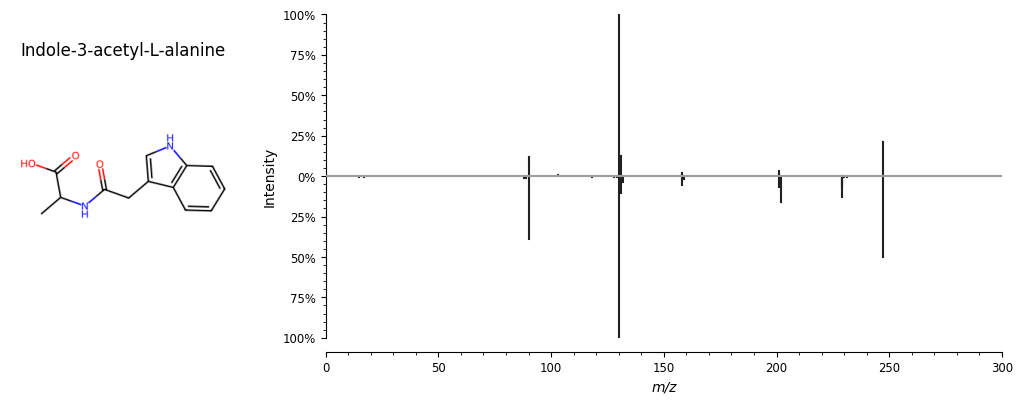

Indole-3-acetyl-L-alanine (292876): cosine 0.91


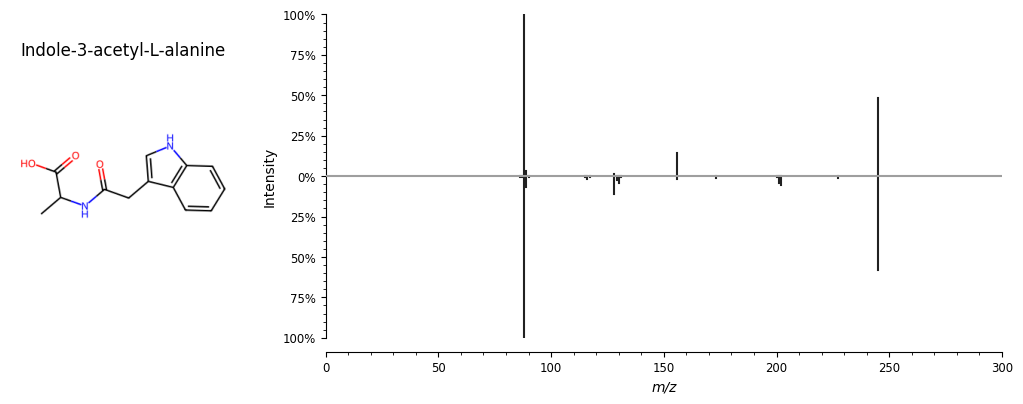

In [22]:
from fiora.visualization.define_colors import reset_matplotlib
reset_matplotlib()
for i, data in df_test[df_test["group_id"] == ex_compound_id].iterrows():
    cosine = data["spectral_sqrt_cosine"]
    name = data["Name"]
    #t3 = data["tanimoto3"]
    print(f"{name} ({i}): cosine {cosine:0.2}")
    # print(f"{name} ({i}): cosine {t3}") only possible after tanimoto calculation below

    fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])

    #axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
    axs[0].set_title(data["Name"])
    #axs[0].imshow(img)
    #axs[0].axis("off")
    #sv.plot_spectrum(example, ax=axs[1])
    ax = sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, ax=axs[1], highlight_matches=False)
    # fig.savefig(f"{home}/images/paper/example_mirror_id{i}.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/example_mirror_id{i}.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/example_mirror_id{i}.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [23]:

paths = {"[M-H]-": f"{home}/data/metabolites/cfm-id/test_pred_neg/", "[M+H]+": f"{home}/data/metabolites/cfm-id/test_pred_pos/"}
df_test["cfm_CE"] = df_test["CE"].apply(closest_cfm_ce)
df_test["cfm_peaks"] = None
df_test[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, data in df_test.iterrows():
    group_id = data["group_id"]
    p = paths[data["Precursor_type"]] + str(int(group_id)) + ".txt"
    cfm_data = cfmReader.read(p, as_df=True)
    
    # TODO Check smiles / MOL
    if cfm_data.shape == (0, 0): # Not predicted by CFM-ID
        continue
        
    cfm_peaks = cfm_data["peaks" + data["cfm_CE"]].iloc[0]

    df_test.at[i, "cfm_peaks"] = cfm_peaks
    df_test.at[i, "cfm_cosine"] = spectral_cosine(data["peaks"], cfm_peaks)
    df_test.at[i, "cfm_sqrt_cosine"] = spectral_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_test.at[i, "cfm_sqrt_cosine_wo_prec"] = spectral_cosine(data["peaks"], cfm_peaks, transform=np.sqrt, remove_mz=data["Metabolite"].get_theoretical_precursor_mz(ion_type=data["Metabolite"].metadata["precursor_mode"]))
    df_test.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_test.at[i, "cfm_steins"] = reweighted_dot(data["peaks"], cfm_peaks)


#### ICEBERG / SCARF
Load spectra predicted by ICEBERG and SCARF by Goldman et. al (2023). Prediction via: https://github.com/samgoldman97/ms-pred 

In [24]:
# This section is dedicated to generate the reference libraries and inputs for CFM-ID and ICEBERG. 
# Turn on only if training or test datasets change.


# CFM-ID query input
if False:
    file = f"{home}/data/metabolites/cfm-id/test_split_negative_solutions_cfm.txt"
    df_test["group_id"] = df_test["group_id"].astype(int)
    df_test[df_test["Precursor_type"] == "[M-H]-"][["group_id", "SMILES"]].drop_duplicates("group_id").to_csv(file, index=False, header=False, sep=" ")
    file = file.replace("negative", "positive")
    df_test[df_test["Precursor_type"] == "[M+H]+"][["group_id", "SMILES"]].drop_duplicates("group_id").to_csv(file, index=False, header=False, sep=" ")

if False: 
    file = f"{home}/data/metabolites/cfm-id/msnlib_test_split_negative_solutions_cfm.txt"
    df_msnlib_test["group_id"] = df_msnlib_test["group_id"].astype(int)
    df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M-H]-"][["group_id", "SMILES"]].drop_duplicates("group_id").to_csv(file, index=False, header=False, sep=" ")
    file = file.replace("negative", "positive")
    df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"][["group_id", "SMILES"]].drop_duplicates("group_id").to_csv(file, index=False, header=False, sep=" ")

# ICEBERG/SCARF training/testing input
if False:
    # OLD # df_test["idx"] = [f"spec{i}" for i,_ in df_test.iterrows()]
    df_test["num"] = df_test.groupby("group_id").cumcount() + 1
    df_test["idx"] = "spec" + df_test["group_id"].astype(int).astype(str) + "_" + df_test["num"].astype(str)

    
    #df_train["dataset_label"] = "df_test"
    label_map = {"idx": "spec", "Name": "name", "Precursor_type": "ionization", "SMILES": "smiles", "InChIKey": "inchikey"}
    df_test["formula"] = df_test["Metabolite"].apply(lambda x: x.Formula)
    df_test["InChIKey"] = df_test["Metabolite"].apply(lambda x: x.InChIKey)
    #import fiora.IO.mspredWriter as mspredWriter WRITER bugged?
    #mspredWriter.write_labels(df_test[df_test["Precursor_type"] == "[M+H]+"], f"{home}/data/metabolites/ms-pred/df_test.tsv", label_map=label_map)
    df_test[df_test["Precursor_type"] == "[M+H]+"].rename(columns=label_map)[["dataset", "spec", "name", "ionization", "formula", "smiles", "inchikey"]].to_csv(f"{home}/data/metabolites/ms-pred/df_test.tsv", index=False, sep="\t")

if False: # MSnLib

    df_msnlib_test["num"] = df_msnlib_test.groupby("group_id").cumcount() + 1
    df_msnlib_test["idx"] = "spec" + df_msnlib_test["group_id"].astype(int).astype(str) + "_" + df_msnlib_test["num"].astype(str)

    
    #df_train["dataset_label"] = "df_msnlib_test"
    label_map = {"idx": "spec", "NAME": "name", "Precursor_type": "ionization", "SMILES": "smiles", "INCHIAUX": "inchikey"}
    df_msnlib_test["formula"] = df_msnlib_test["Metabolite"].apply(lambda x: x.Formula)
    df_msnlib_test["InChIKey"] = df_msnlib_test["Metabolite"].apply(lambda x: x.InChIKey)
    #import fiora.IO.mspredWriter as mspredWriter WRITER bugged?
    #mspredWriter.write_labels(df_test[df_test["Precursor_type"] == "[M+H]+"], f"{home}/data/metabolites/ms-pred/df_test.tsv", label_map=label_map)
    
    df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"].rename(columns=label_map)[["dataset", "spec", "name", "ionization", "formula", "smiles", "inchikey"]].to_csv(f"{home}/data/metabolites/ms-pred/df_msnlib_test.tsv", index=False, sep="\t")

if False:
    # ## CASMI
    # # prepare output for ICEBERG and SCARF
    # # from rdkit import Chem
    # # from rdkit.Chem import rdMolDescriptors
    label_map = {"idx": "spec", "Precursor_type": "ionization", "SMILES": "smiles", "InChIKey": "inchikey"}
    df_cas22["idx"] = [f"spec{i}" for i,_ in df_cas22.iterrows()]
    df_cas22["name"] = "Unknown"
    df_cas22["InChIKey"] = df_cas22["Metabolite"].apply(lambda x: x.InChIKey)
    df_cas22["formula"] = df_cas22["Metabolite"].apply(lambda x: x.Formula)
    
    output_file = f"{home}/data/metabolites/ms-pred/casmi22_positive_labels.tsv"
    df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].rename(columns=label_map)[["dataset", "spec", "name", "formula", "ionization",	"smiles", "inchikey"]].to_csv(output_file, index=False, sep="\t")
    
    # # ### CASMI-16 labels were generated in Casmi16 loader. Avoiding repeat here.
    
    
    
    # df_test["MOL"] = df_test["SMILES"].apply(Chem.MolFromSmiles)
    # df_test["formula"] = df_test["MOL"].apply(rdMolDescriptors.CalcMolFormula)
    # df_test["dataset"] = "df_test"
    # df_test = df_test.rename(columns={"FILE": "spec", "ChallengeName": "name", "Precursor_type": "ionization", "SMILES": "smiles", "INCHIKEY": "inchikey"})
    
    # output_file = f"{home}/data/metabolites/ms-pred/casmi16_positive_labels.tsv"
    #df[df["ionization"] == "[M+H]+"][["dataset", "spec", "name", "formula", "ionization",	"smiles", "inchikey"]].to_csv(output_file, index=False, sep="\t")


##### SAVE TRAINING SET IN MS_PRED FORMAT
# # Write training set to specific ICEBERG format
# import fiora.IO.mspredWriter as mspredWriter
# # calls rename(columns=header_map)
# header_map = {"dataset_label": "dataset", "idx": "spec", "Name": "name",  "Precursor_type": "ionization"}
# df_train["dataset_label"] = "df_train"
# df_train["num"] = df_train.groupby("group_id").cumcount() + 1
# df_train["idx"] = "spec" + df_train["group_id"].astype(str) + "_" + df_train["num"].astype(str) #df_train["idx"] = [f"spec{i}" for i in range(0, len(df_train))]

# # Note: [M-H]- precursors lead to errors with ICEBERG/magma. Also: Sn (tin) element and Au (gold) causes error. Needs manual removal.

# df_train["ice_error"] = df_train["Metabolite"].apply(lambda x: ("Sn" in x.SMILES) or ("Au" in x.SMILES) )
# df_train = df_train[~df_train["ice_error"]]
# mspredWriter.write_dataset(df_train[df_train["Precursor_type"] == "[M+H]+"], f"{home}/repos/ms-pred/data/spec_datasets/df_train/", label_map=header_map)


# d = f"{home}/repos/ms-pred/data/spec_datasets/df_train_wErrors/magma_outputs/magma_tsv"
# import os

# # In order to rerun without errors, select only spec that doesn't cause an error. (requires running magma with the whole dataset first)
# working = set([s.split(".")[0] for s in os.listdir(d)])
#mspredWriter.write_dataset(df_train[df_train["idx"].apply(lambda x: x in working)], f"{home}/repos/ms-pred/data/spec_datasets/df_train/", label_map=header_map)

# # Create split.tsv
# df_split = df_train[["idx", "dataset"]].copy() #df_train[df_train["idx"].apply(lambda x: x in working)][["idx", "dataset"]].copy()
# df_split = df_split.rename(columns={"idx": "spec", "dataset": "Fold_0"})
# df_split["Fold_0"] = df_split["Fold_0"].str.replace("validation", "val")
# df_split["Fold_0"] = df_split["Fold_0"].str.replace("training", "train")
# df_split.to_csv(f"{home}/repos/ms-pred/data/spec_datasets/df_train/splits/split1.tsv", index=False, sep="\t")

# Dataframes to ms-pred input format



In [25]:
# AND AGAIN
# time . data_scripts/y_all_assign_subform.sh: 2045m34,408s
# time . data_scripts/dag/y_run_magma.sh: 1351m24,188s
# 48272 spec
# time bash run_scripts/dag_model/01_run_dag_gen_train.sh: 1911m46,370s (on GPU)
# time python run_scripts/dag_model/02_sweep_gen_thresh.py: 0s
# time bash run_scripts/dag_model/03_run_dag_gen_predict.sh: 296m24,160s (-> only 32960 spec) # Maybe try again here
# time bash run_scripts/dag_model/04_train_dag_inten.sh: ... 3251m49,794s
# --- TEST ---
# time bash quickstart/iceberg/test_df_model.sh   (CASMIs)
# + run iceberg demo
# 11m28,192s + 35m 6s
# df_mnlib_test = 238m (with demo notebook)





# Rerunning EVERYTHING AGAIN (avoiding crashes this time, fingers crossed)
# 
# time . data_scripts/y_all_assign_subform.sh: 2471m28,695s
# time . data_scripts/dag/y_run_magma.sh: 1810m9,266s 
# 64222 spec
#
# time bash run_scripts/dag_model/01_run_dag_gen_train.sh: 1151m8,021s
# time python run_scripts/dag_model/02_sweep_gen_thresh.py: 0s
# time bash run_scripts/dag_model/03_run_dag_gen_predict.sh: 585m29,891s
# time bash run_scripts/dag_model/04_train_dag_inten.sh: 2406m53,876s
# --------
# Test predictions
#
# Casmi 16: 1m40,373s
# All: 80m48,594s (crashed no attribute max fragment depth)
# df_test extra: 459.5min
# df_msnlib_test: 



# raise KeyboardInterrupt("HALT")
#
# Retraining on my dataset
# run_magma: 1853m13,787s -> has ~1000 missing but 64222/65285 calculated (>98%).
# assign_all_subformulae: 2487m16,694s 65285 specs calculated
# 01 dag train: 66117.73s
# 02 sweep: 0
# 03 dag_gen_predict: 405m21,170s (with crash)
# 04 


# v1.0.0 doesn't allow proper retraining, many scripts missing. 
# -> Running on commit: update scarf figs to \pm SEM, instead of confidence -> f56d601e843351e4bdfe0e173d65e8105a1
# run magma took: 347m20,902s
# run subformula: 620m54,021s
# run 01dag train: 37967.52s -> 10,5h
# run 03_run_dag_gen_predict 6692.45s 112m9,625s # Note: the right version must be explicitly named in the config file.
# run 04_inten train 786m57,268s


# Just positives CASMI16. ICEBERG took 98.5s (--gpu threw error though)
#raise KeyboardInterrupt()


In [26]:
# # Training set used for ICEBERG/SCARF public model
# ice_train_path = f"{home}/repos/ms-pred/data/spec_datasets/canopus_train_public/labels.tsv"

# icy = pd.read_csv(ice_train_path, sep="\t")
# icy["Metabolite"] = icy["smiles"].apply(Metabolite)
# ## Available open-source ICEBERG/SCARF models unfortunately violate with our test/train separation
# iii = []
# xxx = []
# for i,d in df_cas.iterrows():
#     m = d["Metabolite"]
    
#     for x,D in icy.iterrows():
#         M = D["Metabolite"]
#         if (m == M):
#             iii += [i]
#             xxx += [x]       
# iii = np.unique(iii)  
# print(f"Found {len(iii)} instances violating test/train split. Metabolite found in train/val set.") # out of 123
# print(f"Dropping {len(xxx)} spectra from training DataFrame.")

In [27]:
import fiora.IO.mspredReader as mspredReader 
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/casmi16/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})


df_cas = pd.merge(df_cas, df_ice[["ice_name", "ice_peaks"]], left_on='ChallengeName', right_on='ice_name', how='left')

df_cas[["ice_cosine", "ice_sqrt_cosine", "ice_sqrt_cosine_wo_prec", "ice_refl_cosine"]] = np.nan
for i, data in df_cas[df_cas["Precursor_type"] == "[M+H]+"].iterrows():

    df_cas.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
    df_cas.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cas.at[i, "ice_sqrt_cosine_wo_prec"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt, remove_mz=data["Metabolite"].get_theoretical_precursor_mz(ion_type=data["Metabolite"].metadata["precursor_mode"]))
    df_cas.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cas.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])


In [28]:
import fiora.IO.mspredReader as mspredReader 
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/casmi16t/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})


df_cast = pd.merge(df_cast, df_ice[["ice_name", "ice_peaks"]], left_on='ChallengeName', right_on='ice_name', how='left')

In [29]:
df_cast[["ice_cosine", "ice_sqrt_cosine", "ice_sqrt_cosine_wo_prec" "ice_refl_cosine"]] = np.nan
for i, data in df_cast[df_cast["Precursor_type"] == "[M+H]+"].iterrows():

    df_cast.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
    df_cast.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cast.at[i, "ice_sqrt_cosine_wo_prec"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt, remove_mz=data["Metabolite"].get_theoretical_precursor_mz(ion_type=data["Metabolite"].metadata["precursor_mode"]))
    df_cast.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cast.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])

In [30]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/casmi22/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

df_cas22["idx"] = [f"spec{i}" for i,_ in df_cas22.iterrows()]
df_cas22 = pd.merge(df_cas22, df_ice[["ice_name", "ice_peaks"]], left_on='idx', right_on='ice_name', how='left')

In [31]:


df_cas22[["ice_cosine", "ice_sqrt_cosine", "ice_sqrt_cosine_wo_prec", "ice_refl_cosine"]] = np.nan
for i, data in df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].iterrows():
    #print(i, data["ice_peaks"], data["ice_peaks"] is not np.nan)
    if data["ice_peaks"] is not np.nan:
        df_cas22.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
        df_cas22.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_cas22.at[i, "ice_sqrt_cosine_wo_prec"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt, remove_mz=data["Metabolite"].get_theoretical_precursor_mz(ion_type=data["Metabolite"].metadata["precursor_mode"]))
        df_cas22.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_cas22.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])

In [32]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

In [33]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})
# df_ice["ice_idx"] = df_ice["ice_name"].str.extract(r'spec(\d+)', expand=False).astype(int)
df_ice.head(2)

,file,ice_name,ice_peaks
0,pred_spec689_1.json,spec689_1,"{'mz': [758.5694316020002, 103.099165456, 104...."
1,pred_spec689_2.json,spec689_2,"{'mz': [758.5694316020002, 103.099165456, 104...."


In [34]:
# iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
# df_ice = mspredReader.read(iceberg_dir)
# df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

# df_test["idx"] = [f"spec{i}" for i,_ in df_test.iterrows()]
# df_test = pd.merge(df_test, df_ice[["ice_name", "ice_peaks"]], left_on='idx', right_on='ice_name', how='left')
# df_test.index = df_test["idx"].str.extract(r'spec(\d+)', expand=False).astype(int)



In [35]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

df_test["num"] = df_test.groupby("group_id").cumcount() + 1
df_test["idx"] = "spec" + df_test["group_id"].astype(int).astype(str) + "_" + df_test["num"].astype(str) #df_test["idx"] = [f"spec{i}" for i,_ in df_test.iterrows()]
ori_idx = df_test.index.copy()
df_test = pd.merge(df_test, df_ice[["ice_name", "ice_peaks"]], left_on='idx', right_on='ice_name', how='left')
df_test.index = ori_idx
#df_test.index = df_test["idx"].str.extract(r'spec(\d+)', expand=False).astype(int) TODO CHECK what happens to the index

df_test[["ice_cosine", "ice_sqrt_cosine", "ice_sqrt_cosine_wo_prec", "ice_refl_cosine"]] = np.nan
for i, data in df_test[df_test["Precursor_type"] == "[M+H]+"].iterrows():
    try:
        df_test.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
        df_test.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_test.at[i, "ice_sqrt_cosine_wo_prec"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt, remove_mz=data["Metabolite"].get_theoretical_precursor_mz(ion_type=data["Metabolite"].metadata["precursor_mode"]))
        df_test.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_test.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])
    except: pass

In [36]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_msnlib_test/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

df_msnlib_test["num"] = df_msnlib_test.groupby("group_id").cumcount() + 1
df_msnlib_test["idx"] = "spec" + df_msnlib_test["group_id"].astype(int).astype(str) + "_" + df_msnlib_test["num"].astype(str) #df_msnlib_test["idx"] = [f"spec{i}" for i,_ in df_msnlib_test.iterrows()]
ori_idx = df_msnlib_test.index.copy()
df_msnlib_test = pd.merge(df_msnlib_test, df_ice[["ice_name", "ice_peaks"]], left_on='idx', right_on='ice_name', how='left')
df_msnlib_test.index = ori_idx
#df_msnlib_test.index = df_msnlib_test["idx"].str.extract(r'spec(\d+)', expand=False).astype(int) TODO CHECK what happens to the index

df_msnlib_test[["ice_cosine", "ice_sqrt_cosine", "ice_sqrt_cosine_wo_prec", "ice_refl_cosine"]] = np.nan
for i, data in df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"].iterrows():
    try:
        df_msnlib_test.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
        df_msnlib_test.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_msnlib_test.at[i, "ice_sqrt_cosine_wo_prec"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt, remove_mz=data["Metabolite"].get_theoretical_precursor_mz(ion_type=data["Metabolite"].metadata["precursor_mode"]))
        df_msnlib_test.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_msnlib_test.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])
    except: pass

In [37]:
# from matplotlib import pyplot as plt
# sv.plot_spectrum(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].iloc[0], {"peaks": df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].iloc[0]["ice_peaks"]})
# plt.title("ICEBERG example prediction")
# plt.show()

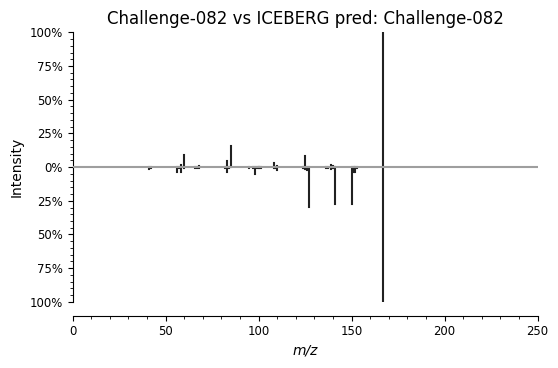

In [38]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6,3.5))
i = 81
ax = sv.plot_spectrum(df_cas.iloc[i], {"peaks": df_cas.iloc[i]["ice_peaks"]}, title=df_cas.iloc[i]["ChallengeName"] + " vs ICEBERG pred: " + df_cas.iloc[i]["ice_name"], highlight_matches=False, with_grid=False, ax=ax)
#ax.spines['bottom'].set_position(('outward', 10))
plt.show()

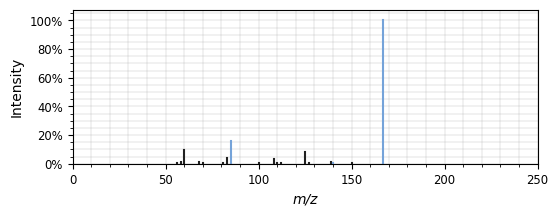

In [39]:
# Test peak highlighting
fig, ax = plt.subplots(figsize=(6, 2))
sv.annotate_and_plot(df_cas.iloc[i], [140.093, 167.10, 85.05], with_grid=True, ax=ax)
plt.show()

In [40]:
df_msnlib_test.groupby("Precursor_type")["group_id"].nunique()

Precursor_type
[M+H]+    785
[M-H]-    492
[M]+       11
[M]-        2
Name: group_id, dtype: int64

In [41]:
df_cas = pd.concat([df_cas, df_cast])
df_cas.reset_index(inplace=True)

In [42]:
# Default score
score = "spectral_sqrt_cosine"
avg_func = np.median


fiora_res = {"model": "Fiora", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score]), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score]), "MSnLib+": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"][score].fillna(0.0)), "MSnLib-": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M-H]-"][score].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score]), "CASMI16-":avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score]), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score])} 
cfm_id = {
    "model": "CFM-ID 4.4.7", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "MSnLib+": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "MSnLib-": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI16-": avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")])} 
ice_res = {
    "model": "ICEBERG", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "MSnLib+": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score.replace("spectral", "ice")].fillna(0.0))} 


summaryPos = pd.DataFrame( [fiora_res, cfm_id, ice_res])
print("Summary test sets")
summaryPos

Summary test sets


,model,Test+,Test-,MSnLib+,MSnLib-,CASMI16+,CASMI16-,CASMI22+,CASMI22-
0,Fiora,0.807246,0.791260,0.645026,0.610936,0.766605,0.773664,0.289139,0.317697
1,CFM-ID 4.4.7,0.666676,0.565989,0.482090,0.409999,0.704946,0.589614,0.376012,0.292884
2,ICEBERG,0.716473,NaN,0.575536,NaN,0.709359,NaN,0.358571,0.000000


In [43]:
score = "spectral_sqrt_cosine_wo_prec"
avg_func = np.median

fiora_res = {"model": "Fiora", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score].fillna(0.0)), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score].fillna(0.0)), "MSnLib+": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"][score].fillna(0.0)), "MSnLib-": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M-H]-"][score].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score].fillna(0.0)), "CASMI16-":avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score].fillna(0.0)), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score].fillna(0.0))} 
cfm_id = {
    "model": "CFM-ID 4.4.7", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "MSnLib+": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "MSnLib-": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI16-": avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")])} 
ice_res = {
    "model": "ICEBERG", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "MSnLib+": avg_func(df_msnlib_test[df_msnlib_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)),  "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0))} 

summaryPos = pd.DataFrame( [fiora_res, cfm_id, ice_res])
print("Summary test sets - without precursor")
summaryPos

Summary test sets - without precursor


,model,Test+,Test-,MSnLib+,MSnLib-,CASMI16+,CASMI16-,CASMI22+,CASMI22-
0,Fiora,0.757314,0.723793,0.625697,0.563265,0.549702,0.440755,0.247252,0.277212
1,CFM-ID 4.4.7,0.589064,0.426523,0.453675,0.361728,0.475033,0.137331,0.339090,0.281469
2,ICEBERG,0.701749,NaN,0.553976,NaN,0.548186,NaN,0.380744,NaN


In [44]:
### Stacked spectra plot

def stacked_spectrum(data, text_offset: float=0.0, spec_text_position_override=(0.02, 0.9), split_text_experimental=False, verbose: bool=False):
    name_tags = ["Fiora", "ICEBERG", "CFM-ID"]
    peak_tags = ["sim_peaks", "ice_peaks", "cfm_peaks"]
    scores = [("spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec"), ("ice_sqrt_cosine", "ice_sqrt_cosine_wo_prec"), ("cfm_sqrt_cosine", "cfm_sqrt_cosine_wo_prec")]
    peak_colors = ["#0080FF", "#FF3333", "#FFCC00"]#sns.color_palette("YlOrBr", 10)[3]]
    spec_height, spec_width = 1.5, 8
    
    fig, axs = plt.subplots(len(peak_tags) + 2, 1, figsize=(spec_width, spec_height * (len(peak_tags) + 2)),  sharex=True) # gridspec_kw={'width_ratios': [1, 3]}
    img = data["Metabolite"].draw(ax=axs[0])
    textstr=f'Name: {data["Name"] if "Name" in data.keys() else data["NAME"] if "NAME" in data.keys() else data["ChallengeName"]}\nPrecursor type:   {data["Precursor_type"]}\nCollision energy: {data["CE"]:.1f} eV'
    fig.text(.54 + text_offset, .8, textstr, #transform=axs[0].transAxes,
               fontsize=8, horizontalalignment="left", verticalalignment='top', bbox=dict(facecolor='white', alpha=0))
    
    plt.subplots_adjust(hspace=0.12) #(top=0.94, bottom=0.12, right=0.97, left=0.08)
    sv.plot_spectrum(data, highlight_matches=False, ppm_tolerance=200, ax=axs[1])
    
    axs[1].text(spec_text_position_override[0], spec_text_position_override[1], "Experimental\nspectrum" if split_text_experimental else "Experimental spectrum", transform=axs[1].transAxes,
               fontsize=11, verticalalignment='top')
    axs[1].set_xlabel("")
    for i, tag in enumerate(peak_tags):
        try: 
            ax = axs[i + 2]
            sv.plot_spectrum({"peaks": data[tag]}, ax=ax, color=peak_colors[i])
            #ax.legend(title=name_tags[i], loc="upper left", labels=scores[i])
            textstr = '\n'.join((
                        f'$\\bf{{{name_tags[i]}}}$',
                        f'Cosine:    {data[scores[i][0]]:.2f}',
                        f'w/o prec: {data[scores[i][1]]:.2f}'))

            ax.set_xlabel("")
            ax.text(spec_text_position_override[0], spec_text_position_override[1], textstr, transform=ax.transAxes,
               fontsize=11, verticalalignment='top')#,
               #bbox=dict(boxstyle='square,pad=0.5', facecolor='white', alpha=0.5))
        except: 
            if verbose:
                print(f"Could not plot spectrum {data[tag]}")
            continue
    axs[-1].set_xlabel("m/z")
        
    sv.set_default_peak_color("#212121")

    return fig, axs


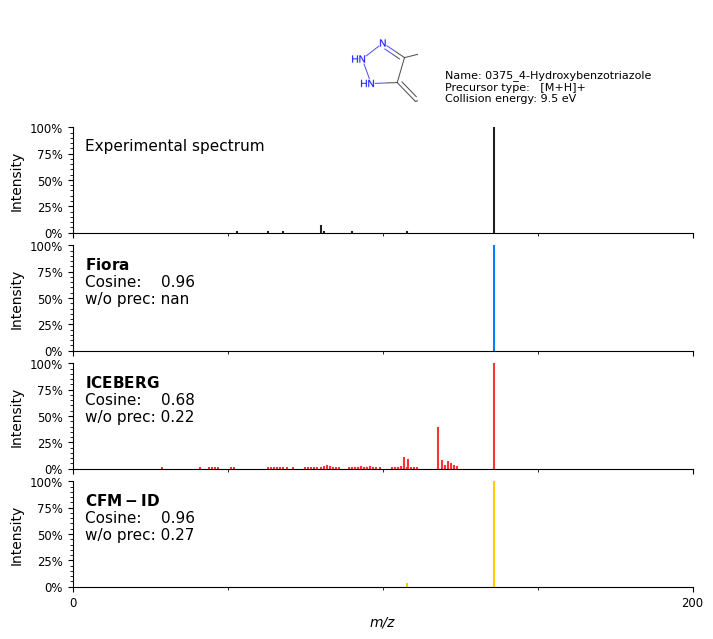

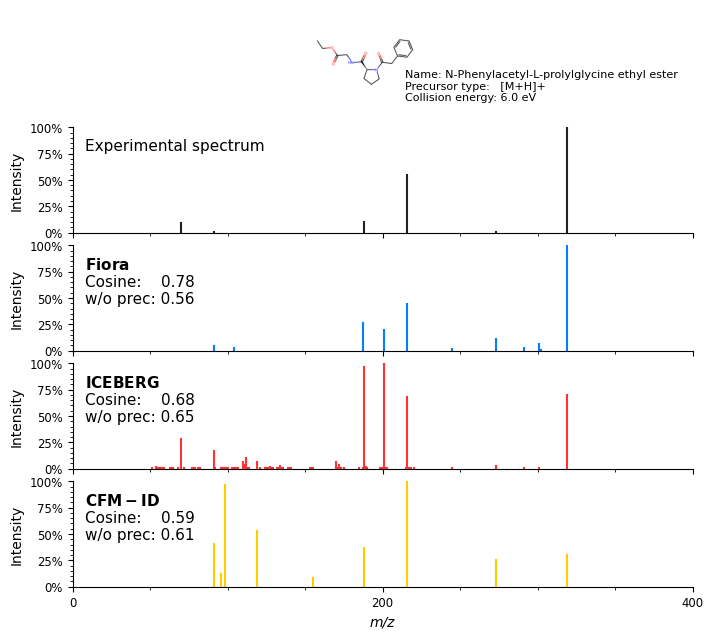

In [45]:
#zzz = df_cas[df_cas["spectral_sqrt_cosine_wo_prec"].isna()]
# Interesting spectra to look at with drastic changes from precursor removal-
# 159, 93, 182, 124, 134, 205! (CASMI)
# 6369! 13990 33153 62382! (Test split)
img = stacked_spectrum(df_cas.loc[93].iloc[1], text_offset=0.05)
plt.show()

img = stacked_spectrum(df_test.loc[62382])
plt.show()

In [46]:
def get_average_spectra(df: pd.DataFrame, score: str="spectral_sqrt_cosine", dif: float=0.05):
    median_cos, median_cos_wo_prec = df[score].median(), df[score + "_wo_prec"].median()
    filter_average = (abs(df[score] - median_cos) < dif) & (abs(df[score + "_wo_prec"] - median_cos_wo_prec) < dif)

    return df[filter_average]

In [47]:
df_a = get_average_spectra(df_test[df_test["Precursor_type"] == "[M+H]+"], dif=0.05)
df_a = get_average_spectra(df_a, score="ice_sqrt_cosine", dif=0.05)
df_a = get_average_spectra(df_a, score="cfm_sqrt_cosine", dif=0.05)
df_a = df_a[(df_a["spectral_sqrt_cosine_wo_prec"] > df_a["ice_sqrt_cosine_wo_prec"]) & (df_a["spectral_sqrt_cosine_wo_prec"] > df_a["cfm_sqrt_cosine_wo_prec"])]

In [48]:
#df_a = df_a[df_a["lib"] == "MSDIAL"]
df_a.shape

(2, 112)

Name                                                              Retigabine
Synon                                                              Ezogabine
Notes                      Spec=Consensus Nreps=21/22 Mz_diff=-0.3ppm mic...
Precursor_type                                                        [M+H]+
Spectrum_type                                                            MS2
                                                 ...                        
ice_cosine                                                          0.678949
ice_sqrt_cosine                                                     0.735162
ice_sqrt_cosine_wo_prec                                              0.70519
ice_refl_cosine                                                     0.735162
ice_steins                                                          0.733119
Name: 59586, Length: 112, dtype: object


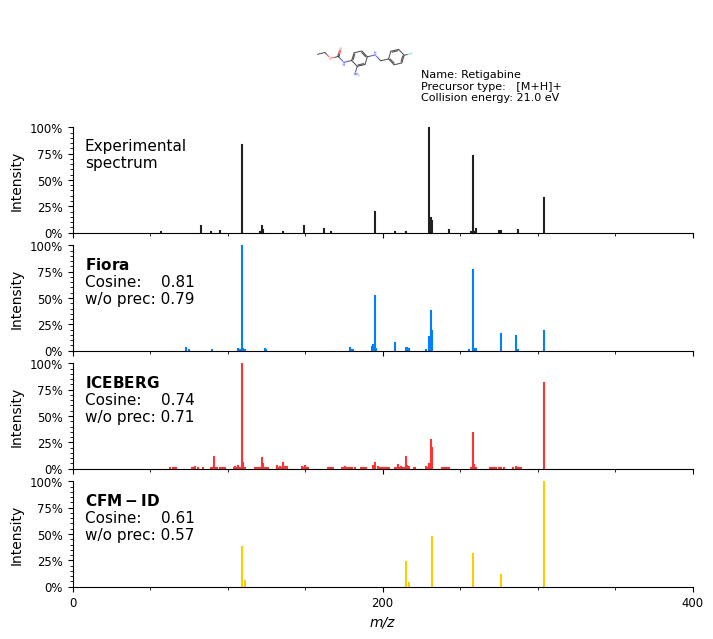

In [49]:
reset_matplotlib()
for i, data in df_a.head(1).iterrows():
    print(data)
    fig, axs = stacked_spectrum(df_a.loc[i], text_offset=0.02, split_text_experimental=True, verbose=True)
    # fig.savefig(f"{home}/images/paper/stacked_avg{i}.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/stacked_avg{i}.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/stacked_avg{i}.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
        
    

In [50]:
import pandas as pd

high_score_threshold = 0.7
low_score_threshold = 0.5

df_ex = df_msnlib_test[df_msnlib_test["SPECTYPE"] == "SAME_ENERGY"]


high_score_30 = df_ex[(df_ex["CE"] == 30) & (df_ex["spectral_sqrt_cosine"] >= high_score_threshold)]
low_score_60 = df_ex[(df_ex["CE"] == 60) & (df_ex["spectral_sqrt_cosine"] <= low_score_threshold)]

common_group_ids = pd.merge(high_score_30[['group_id']], low_score_60[['group_id']], on='group_id')
matching_ids = common_group_ids['group_id'].unique()


In [51]:
matching_ids

array([  268.,  3990., 13829.])

In [52]:
examples = df_ex[df_ex["group_id"] == matching_ids[1]]

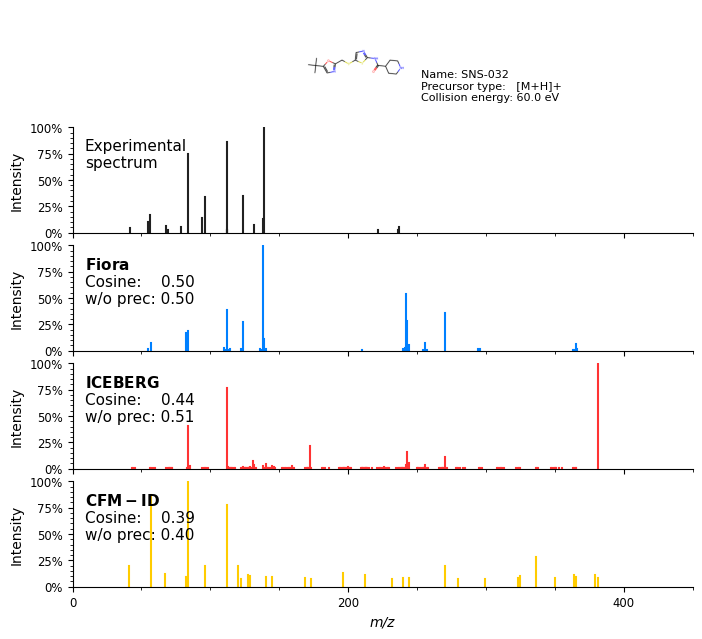

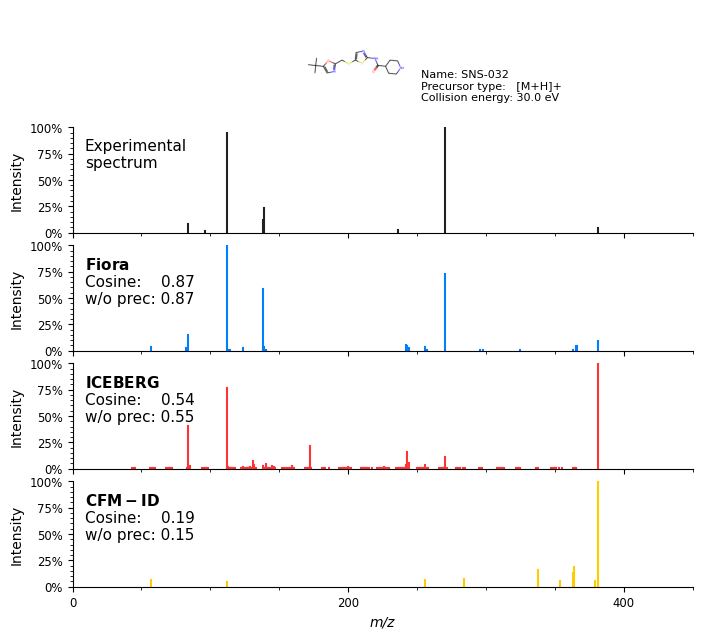

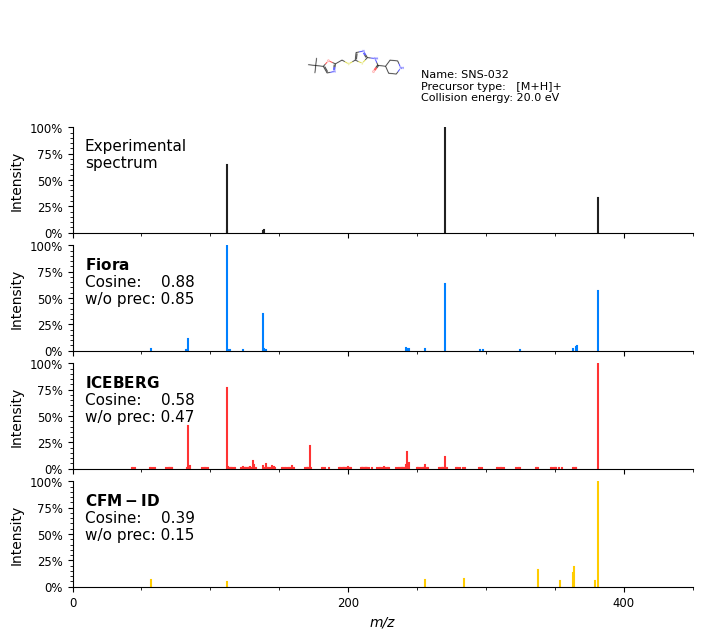

In [53]:
for i, data in examples.head(3).iterrows():
    #print(data)
    fig, axs = stacked_spectrum(examples.loc[i], text_offset=0.02, split_text_experimental=True, verbose=True)
    ce = data["CE"]
    # fig.savefig(f"{home}/images/paper/stacked_ce{ce}.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/stacked_ce{ce}.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/stacked_ce{ce}.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [54]:
if has_m_plus:
    print("Conducting performance analysis for [M]+ and [M]- precursors")
    
    df_m = df_msnlib_test[df_msnlib_test["Precursor_type"].isin(["[M]+", "[M]-"])]
    df_m = df_m[df_m["SPECTYPE"] != "ALL_MSN_TO_PSEUDO_MS2"]
    df_not_m = df_msnlib_test[df_msnlib_test["Precursor_type"].isin(["[M+H]+", "[M-H]-"])]
    
    
    print(df_m.groupby("Precursor_type")["spectral_sqrt_cosine"].median())
    print(df_m.groupby("Precursor_type")["spectral_sqrt_cosine_wo_prec"].median())

    

In [56]:
if has_m_plus:
    print(df_m.groupby("Precursor_type")["group_id"].nunique())


In [57]:
print("Training:", df_msnlib_train.groupby("Precursor_type")["group_id"].nunique())

Training: Precursor_type
[M+H]+    7073
[M-H]-    4370
[M]+       150
[M]-        12
Name: group_id, dtype: int64


In [58]:
if has_m_plus:
    iii = []
    for i, data in df_not_m.iterrows():
        metabolite = data["Metabolite"]
        for i, data2 in df_m.iterrows():
            other_metabolite = data2["Metabolite"]
            if metabolite == other_metabolite:
                if data["CE"] == data2["CE"] and (("+" in data["Precursor_type"]) == ("+" in data2["Precursor_type"])):
                    print("cos:", data["spectral_sqrt_cosine"], data2["spectral_sqrt_cosine"])



In [59]:
if has_m_plus:
    data = df_m.iloc[0]
    
    for i, data in df_m.tail(2).iterrows():
        cosine = data["spectral_sqrt_cosine"]
        cosine_wo = data["spectral_sqrt_cosine_wo_prec"]
        name = data["NAME"]
        prec = data["Precursor_type"]
        
        print(f"{prec} ({i}): cosine {cosine:0.2} / {cosine_wo:0.2}")
        print(max(data["peaks"]["mz"]))
        print(max(data["sim_peaks"]["mz"]))

        fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
        img = data["Metabolite"].draw(ax= axs[0])


        axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
        axs[0].set_title(data["NAME"])

        ax = sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, ax=axs[1], highlight_matches=False)
        # fig.savefig(f"{home}/images/paper/example_mirror_id{i}.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
        # fig.savefig(f"{home}/images/paper/example_mirror_id{i}.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
        # fig.savefig(f"{home}/images/paper/example_mirror_id{i}.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
        plt.show()


In [60]:

sns.boxplot(df_msnlib_test, y="spectral_sqrt_cosine_wo_prec", x="origin")

<Axes: xlabel='origin', ylabel='spectral_sqrt_cosine_wo_prec'>

In [61]:
raise KeyboardInterrupt("Stop")

KeyboardInterrupt: Stop

In [ ]:
# ### Uncomment to publish a new OS version
# v = "0.1.0" # Enter version number
# model.model_params["version_number"] = v # First OS model to be published
# model.model_params["version"] = f"Fiora OS v{v}" 
# model.model_params["training_library"] = "MSnLib" # Add information
# model.model_params["comment"] = "This is the first open-source Fiora model released on GitHub trained on the MSnLib v1.0." 
# model.model_params["disclaimer"] = "No prediction software is perfect. This is an early open-source model. Use with caution."

In [ ]:
# NEW_MODEL_PATH = f"../models/fiora_OS_v{v}.pt" 
# model.save(NEW_MODEL_PATH)

In [ ]:
# df_test["precursor_raw_prob"] = df_test["Metabolite"].apply(lambda x: x.match_stats["precursor_raw_prob"])
# condition = ((df_test["spectral_sqrt_cosine"] - df_test["ice_sqrt_cosine"]) > 0.1) & ((df_test["spectral_sqrt_cosine_wo_prec"].fillna(0.0) - df_test["ice_sqrt_cosine_wo_prec"]) < -0.1) & (df_test["precursor_raw_prob"] < 0.7)
# zzz = df_test[condition]
# print(zzz.shape)
# for i, data in zzz.iterrows():
#     print(i)
#     try: 
#         stacked_spectrum(data)
#         plt.show()
#     except: continue

In [ ]:
# #df_cas22.groupby("is_priority")["ChallengeName"].apply(len)

# print("CASMI 16+/-")
# result = df_cas.groupby(["Precursor_type", "is_priority"]).agg(
#     num=("ChallengeName", lambda x: len(x.unique())),
#     cos=("spectral_sqrt_cosine", "median")
# )
# print(result)


# print("\n-----------\nCASMI 22+/-")
# result = df_cas22.groupby(["Precursor_type", "is_priority"]).agg(
#     num=("ChallengeName", lambda x: len(x.unique())),
#     cos=("spectral_sqrt_cosine", "median")
# )
# print(result)

In [ ]:
df_test.groupby("Precursor_type").agg(num =("group_id", lambda x: len(x.unique())))

,num
Precursor_type,
[M+H]+,895
[M-H]-,437


### Top-k Retrieval

In [62]:
df_msnlib_train["datasplit"].value_counts()

datasplit
training      35237
validation     4303
Name: count, dtype: int64

In [ ]:

def retrieve_top_k(k: int, df: pd.DataFrame, ref_lib: pd.DataFrame):
    df["k_scores"] = [[] for _ in range(len(df))]
    for i, sim_row in df.iterrows():
        sim_peaks = sim_row["sim_peaks"]
        scores = []
        for _, ref_row in ref_lib.iterrows():
            ref_peaks = ref_row["peaks"]
            score = spectral_cosine(sim_peaks, ref_peaks)
            scores.append(score)
        scores = sorted(scores, reverse=True)[:k]
        df.at[i, "k_scores"] = scores
    

In [126]:
def retrieve_top_k(k: int, df: pd.DataFrame, ref_lib: pd.DataFrame):
    # Compute theoretical precursor mz and precursor mode for both dataframes
    df["theoretical_precursor_mz"] = df["Metabolite"].apply(lambda x: x.get_theoretical_precursor_mz(ion_type=x.metadata["precursor_mode"]))
    df["precursor_mode"] = df["Metabolite"].apply(lambda x: x.metadata["precursor_mode"])
    ref_lib["theoretical_precursor_mz"] = ref_lib["Metabolite"].apply(lambda x: x.get_theoretical_precursor_mz(ion_type=x.metadata["precursor_mode"]))
    ref_lib["precursor_mode"] = ref_lib["Metabolite"].apply(lambda x: x.metadata["precursor_mode"])
    
    # Initialize k_scores column
    df["k"] = [0 for _ in range(len(df))]
    df["k_wop"] = [0 for _ in range(len(df))]
    df["k_avg"] = [0 for _ in range(len(df))]
    df["spectral_sqrt_cosine_avg"] = [0.0 for _ in range(len(df))]
    df["k_scores"] = [[] for _ in range(len(df))]
    df["k_scores_wop"] = [[] for _ in range(len(df))]
    df["k_scores_avg"] = [[] for _ in range(len(df))]
    
    for i, row in df.iterrows():
        sim_peaks = row["sim_peaks"]
        sim_mz = row["theoretical_precursor_mz"]
        sim_mode = row["precursor_mode"]
        
        # Filter reference library based on matching mode and precursor mz
        matching_refs = ref_lib[
            (ref_lib["precursor_mode"] == sim_mode) &
            (abs(ref_lib["theoretical_precursor_mz"] - sim_mz) < DEFAULT_DALTON)
        ]
        
        scores, scores_wop, scores_avg = [], [], []

        for _, ref_row in matching_refs.iterrows():
            ref_peaks = ref_row["peaks"]
            score = spectral_cosine(sim_peaks, ref_peaks, transform=np.sqrt)
            scores.append(score)
            score_wop = spectral_cosine(sim_peaks, ref_peaks, transform=np.sqrt, remove_mz=sim_mz)
            scores_wop.append(score_wop)
            scores_avg.append((score + score_wop) / 2.0)
        
        # Keep top k scores
        df.at[i, "k_scores"] = sorted(scores, reverse=True)[:k]
        df.at[i, "k_scores_wop"] = sorted(scores_wop, reverse=True)[:k]
        df.at[i, "k_scores_avg"] = sorted(scores_avg, reverse=True)[:k]
        
        score = row["spectral_sqrt_cosine"]
        score_wop = row["spectral_sqrt_cosine_wo_prec"]
        score_avg = (score + score_wop) / 2.0

        df.at[i, "spectral_sqrt_cosine_avg"] = score_avg

        # Determine position k for each score
        df.at[i, "k"] = sum(1 for s in df.at[i, "k_scores"] if score <= s) + 1
        df.at[i, "k_wop"] = sum(1 for s in df.at[i, "k_scores_wop"] if score_wop <= s) + 1
        df.at[i, "k_avg"] = sum(1 for s in df.at[i, "k_scores_avg"] if score_avg <= s) + 1        


In [ ]:
import pubC

#### Statistics

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from fiora.visualization.define_colors import *

### UMAP

In [ ]:
df_test["group_id"] = df_test["group_id"].astype(int)
df_test.drop_duplicates("group_id", keep="first")[["group_id", "SMILES"]].to_csv(f"{home}/data/metabolites/benchmarking/classyfire_input.csv", header=None, sep=" ", index=False)
# Use classyfire via text interface to produce output csv: http://classyfire.wishartlab.com/#chemical-text-query

In [ ]:
compound_classes = pd.read_csv(f"{home}/data/metabolites/benchmarking/classyfire_output.csv")
compound_classes["CompoundID"] = pd.to_numeric(compound_classes["CompoundID"], errors="coerce", downcast="integer")
compound_classes[['Category', 'Value']] = compound_classes['ClassifiedResults'].str.split(':', n=1, expand=True)

In [ ]:

compound_classes["Value"] = compound_classes["Value"].fillna('')
compound_classes = compound_classes.groupby(['CompoundID', 'Category'])['Value'].agg(','.join).unstack()
compound_classes.reset_index(inplace=True)
compound_classes.columns.name = None

In [ ]:
compound_classes.head(2)

,CompoundID,Ancestors,Class,Classification_version,Direct_parent,External_descriptors,Intermediate_nodes,Kingdom,Subclass,Substituents,Superclass,alternative_parents,mMlecular_framework,predicted_chebi_terms,predicted_lipidmaps_terms
0,15,"[""Alpha amino acid amides"", ""Alpha amino acid...",Lactams,2.1,Penicillins,"[[""source: CHEBI"", ""source_id: CHEBI:28971"", ...",Penams,Organic compounds,Beta lactams,"[""Penicillin"", ""N-acyl-alpha amino acid or de...",Organoheterocyclic compounds,"N-acyl-alpha amino acids and derivatives, Alp...",Aromatic heteropolycyclic compounds,"[""N-acyl-amino acid (CHEBI:51569)"", ""amino ac...",[]
1,17,"[""Amines"", ""Aniline and substituted anilines""...",Benzene and substituted derivatives,2.1,Diphenylmethanes,"[[""source: CHEBI"", ""source_id: CHEBI:51874"", ...",NaN,Organic compounds,Diphenylmethanes,"[""Diphenylmethane"", ""Aniline or substituted a...",Benzenoids,"Dialkylarylamines, Aniline and substituted an...",Aromatic homomonocyclic compounds,"[""dialkylarylamine (CHEBI:23665)"", ""tertiary ...",[]


In [ ]:
num_classes = len(compound_classes["Superclass"].unique())
superclass_map = dict(zip(compound_classes["Superclass"].unique(), range(0, num_classes)))

In [ ]:
df_em = {
    "embedding": [],
    "spectrum": []
}

In [ ]:
test_embeddings = []
test_classes = []
test_cclasses = []
colors = []
classmap = {}
supermap = {}
submap = {}
pal = sns.color_palette("viridis", num_classes)

for i, d in df_test.drop_duplicates("group_id", keep="first").iterrows():
    metabolite = d["Metabolite"]
    group_id = d["group_id"]
    superclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Superclass"]
    subclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Subclass"]
    cclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Class"]

    supermap[group_id] = superclass
    classmap[group_id] = cclass
    submap[group_id] = subclass

    data = metabolite.as_geometric_data(with_labels=False).to(dev)
    batch = geom.data.Batch.from_data_list([data])
    embedding = model.get_graph_embedding(batch)
    if d["Precursor_type"] == "[M+H]+": 
        df_em["embedding"] += [embedding.flatten().cpu().detach().numpy()]
        df_em["spectrum"] += [d["peaks"]]
    test_embeddings += [embedding.flatten().cpu().detach().numpy()]
    test_classes += [superclass]
    test_cclasses += [cclass]

    colors += [pal[superclass_map[superclass]]]


df_test["Superclass"] = df_test["group_id"].map(supermap)
df_test["Class"] = df_test["group_id"].map(classmap)
df_test["Subclass"] = df_test["group_id"].map(submap)


In [ ]:
from fiora.MS.spectral_scores import spectral_cosine, cosine
em_sim = []
spec_sim = []

for i in range(len(df_em["embedding"])):
    em = df_em["embedding"][i]
    spec = df_em["spectrum"][i]
    for j in range(len(df_em["embedding"])):
        if i >= j:
            continue
        em2 = df_em["embedding"][j]
        spec2 = df_em["spectrum"][j]
        spec_sim += [spectral_cosine(spec, spec2, transform=np.sqrt)]
        em_sim += [cosine(em, em2)]
    

In [ ]:
np.corrcoef(em_sim, spec_sim, dtype=float)[0,1]

0.0991012494284827

In [ ]:
raise KeyboardInterrupt("Stop before UMAPs - Careful now")
# top = df_test.drop_duplicates("group_id", keep="first")["Superclass"].value_counts().index[:8]
# test_classes = [t if t in top  else " Other" for t in test_classes]

KeyboardInterrupt: Stop before UMAPs - Careful now

In [ ]:
lipid_index = np.where(np.array(test_classes) == ' Lipids and lipid-like molecules')

In [ ]:
# e = reducer.transform(test_embeddings)

In [ ]:
df_test.drop_duplicates("group_id", keep="first")["Superclass"].value_counts()

Superclass
 Benzenoids                                   225
 Organoheterocyclic compounds                 219
 Organic acids and derivatives                191
 Phenylpropanoids and polyketides             171
 Lipids and lipid-like molecules              136
 Organic oxygen compounds                      63
 Organic nitrogen compounds                    27
 Alkaloids and derivatives                     20
 Lignans, neolignans and related compounds      6
 Nucleosides, nucleotides, and analogues        5
 Organosulfur compounds                         3
 Organohalogen compounds                        3
 Hydrocarbon derivatives                        1
Name: count, dtype: int64

In [ ]:
np.unique(test_classes)

array([' Alkaloids and derivatives', ' Benzenoids',
       ' Hydrocarbon derivatives',
       ' Lignans, neolignans and related compounds',
       ' Lipids and lipid-like molecules',
       ' Nucleosides, nucleotides, and analogues',
       ' Organic acids and derivatives', ' Organic nitrogen compounds',
       ' Organic oxygen compounds', ' Organohalogen compounds',
       ' Organoheterocyclic compounds', ' Organosulfur compounds',
       ' Phenylpropanoids and polyketides'], dtype='<U42')

In [ ]:


# for i in range(5, 31, 5): # 7 or 8 neighbors or 20 to 25 neighbors
#     print(i)
#     reducer = umap.UMAP(n_neighbors=i, min_dist=0.1, metric="euclidean", random_state=0, n_jobs=1) # 43, 50, 51, 52, 54! looks nice
#     reducer.fit(test_embeddings)
#     e = reducer.transform(test_embeddings)

#     fig, ax = plt.subplots(1,1, figsize=(8,8))
#     scatter = sns.scatterplot(ax=ax,
#         x=e[:, 0],
#         y=e[:, 1],
#         hue=test_classes, edgecolor='white')# s=30,, hue_order=np.unique(test_classes)[::-1])#, order=[' Organic acids and derivatives', ' Organoheterocyclic compounds', ' Benzenoids', ' Alkaloids and derivatives', ' Phenylpropanoids and polyketides', ])#, palette=sns.color_palette("colorblind") + ["black", "gray", "white"])
#     legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#     #plt.gca().set_aspect('equal', 'datalim')
#     ax.set_aspect('equal', 'datalim')
#     #ax.set_ylim([4, 12])
#     # fig.savefig(f"{home}/images/paper/umap.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
#     # fig.savefig(f"{home}/images/paper/umap.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

#     # Get the legend handles and labels
#     handles = legend.legend_handles

#     # Get the facecolors from the legend handles (for scatter plot markers)
#     legend_colors = [handle.get_color() for handle in handles]# if isinstance(handle, matplotlib.patches.PathPatch)]

#     plt.show()

(1.0859981596469879, 8.50295450091362)
Default marker size: 40
Default line width (edges): 0.48


/tmp/ipykernel_2092892/4007722554.py:10: UserWarning: 
The markers list has fewer values (7) than needed (13) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(ax=ax,


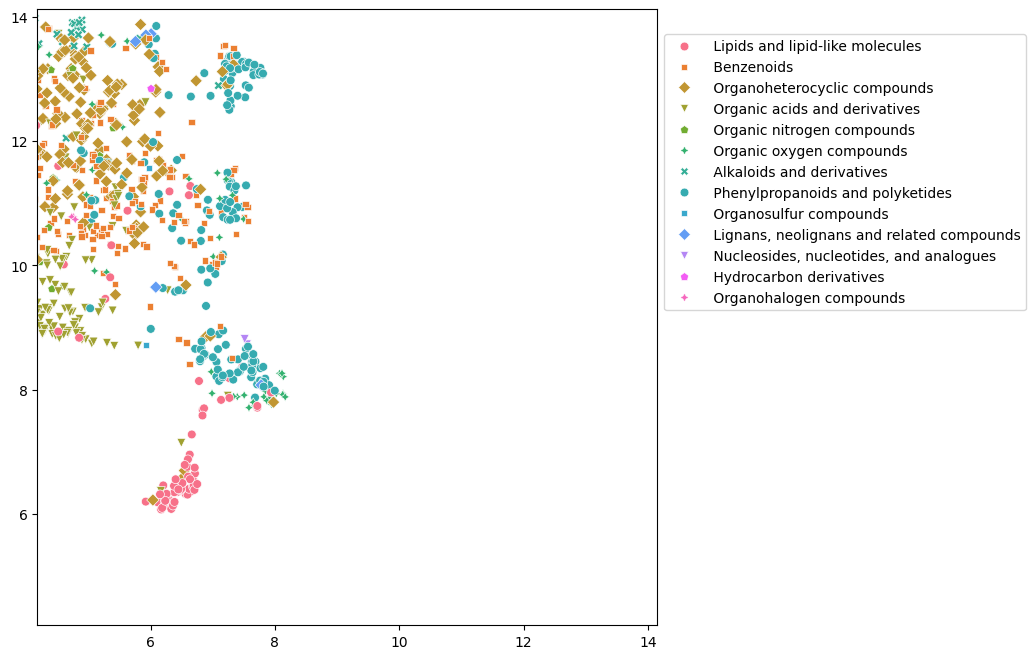

In [ ]:
import matplotlib
import umap

reset_matplotlib()
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=0, n_jobs=1) # creates different umaps despite fixed seed. Reason probably pytorch.
reducer.fit(test_embeddings)
e = reducer.transform(test_embeddings)

fig, ax = plt.subplots(1,1, figsize=(8,8))
scatter = sns.scatterplot(ax=ax,
    x=e[:, 0],
    y=e[:, 1],
    hue=test_classes, edgecolor="white", linewidth=0.48, s=40, palette=sns.color_palette("husl", 13), style=test_classes, markers=["o", (4,0, 45), "D", "v", "p", (4,1,0), "X"])# markers=["o", "*", "s", "^", "D", "h", (4,1,0),"v", "X", "P", "p", "<", (4,0, 45)] s=30,, hue_order=np.unique(test_classes)[::-1])#, order=[' Organic acids and derivatives', ' Organoheterocyclic compounds', ' Benzenoids', ' Alkaloids and derivatives', ' Phenylpropanoids and polyketides', ])#, palette=sns.color_palette("colorblind") + ["black", "gray", "white"])
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#plt.gca().set_aspect('equal', 'datalim')
#plt.ylim([-2.50,13])
#plt.xlim([-2.50,13])
ax.set_aspect('equal', 'datalim')
print(ax.get_xlim())
ax.set_xlim((4.18, 14.15))
ax.set_ylim(ax.get_xlim())
# Get the default marker size
default_marker_size = ax.collections[0].get_sizes()[0]

# Print the default marker size
print("Default marker size:", default_marker_size)
#ax.set_ylim([4, 12])
# fig.savefig(f"{home}/images/paper/umap_alt2.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/umap_alt2.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

# Get the default line width (edges)
default_line_width = ax.collections[0].get_linewidths()[0]

# Print the default line width
print("Default line width (edges):", default_line_width)

# Get the legend handles and labels
handles = legend.legend_handles

# Get the facecolors from the legend handles (for scatter plot markers)
legend_colors = [handle.get_color() for handle in handles]# if isinstance(handle, matplotlib.patches.PathPatch)]


plt.show()

Default marker size: 40
Default line width (edges): 0.48


/tmp/ipykernel_657261/921638636.py:10: UserWarning: The markers list has more values (7) than needed (6), which may not be intended.
  scatter = sns.scatterplot(ax=ax,


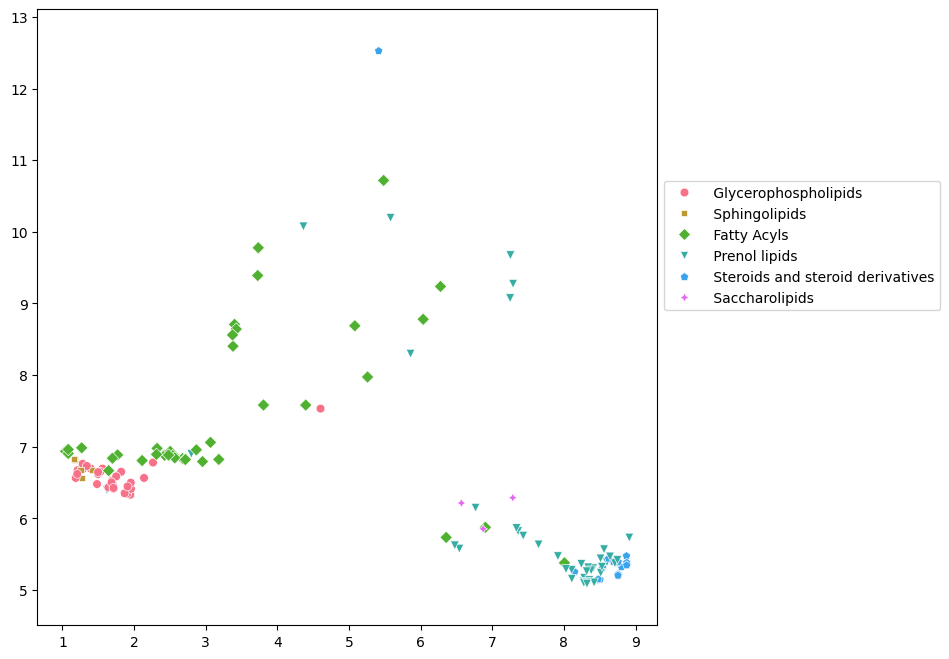

In [ ]:
import matplotlib
import umap

reset_matplotlib()
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=0, n_jobs=1) # creates different umaps despite fixed seed. Reason probably pytorch.
reducer.fit(test_embeddings)
e = reducer.transform(test_embeddings)

fig, ax = plt.subplots(1,1, figsize=(8,8))
scatter = sns.scatterplot(ax=ax,
    x=e[lipid_index[0], 0],
    y=e[lipid_index[0], 1],
    hue=np.array(test_cclasses)[lipid_index[0]], edgecolor="white", linewidth=0.48, s=40, palette=sns.color_palette("husl", 6), style=np.array(test_cclasses)[lipid_index[0]], markers=["o", (4,0, 45), "D", "v", "p", (4,1,0), "X"])# markers=["o", "*", "s", "^", "D", "h", (4,1,0),"v", "X", "P", "p", "<", (4,0, 45)] s=30,, hue_order=np.unique(test_classes)[::-1])#, order=[' Organic acids and derivatives', ' Organoheterocyclic compounds', ' Benzenoids', ' Alkaloids and derivatives', ' Phenylpropanoids and polyketides', ])#, palette=sns.color_palette("colorblind") + ["black", "gray", "white"])
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#plt.gca().set_aspect('equal', 'datalim')
#plt.ylim([-2.50,13])
#plt.xlim([-2.50,13])
ax.set_aspect('equal', 'datalim')
# Get the default marker size
default_marker_size = ax.collections[0].get_sizes()[0]

# Print the default marker size
print("Default marker size:", default_marker_size)
#ax.set_ylim([4, 12])
#fig.savefig(f"{home}/images/paper/umap_lipids_global.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

# Get the default line width (edges)
default_line_width = ax.collections[0].get_linewidths()[0]

# Print the default line width
print("Default line width (edges):", default_line_width)

# Get the legend handles and labels
handles = legend.legend_handles

# Get the facecolors from the legend handles (for scatter plot markers)
legend_colors = [handle.get_color() for handle in handles]# if isinstance(handle, matplotlib.patches.PathPatch)]

# fig.savefig(f"{home}/images/paper/umap_lipids_global.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/umap_lipids_global.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [ ]:
#TODO use as mask to plot lipids
df_test.drop_duplicates("group_id", keep="first")["Superclass"] == " Lipids and lipid-like molecules"

2303       True
2316       True
2317       True
2326       True
2332       True
          ...  
309373     True
309531     True
310465    False
311147     True
311652    False
Name: Superclass, Length: 1070, dtype: bool

In [ ]:
sns.color_palette(n_colors=13)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [ ]:
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

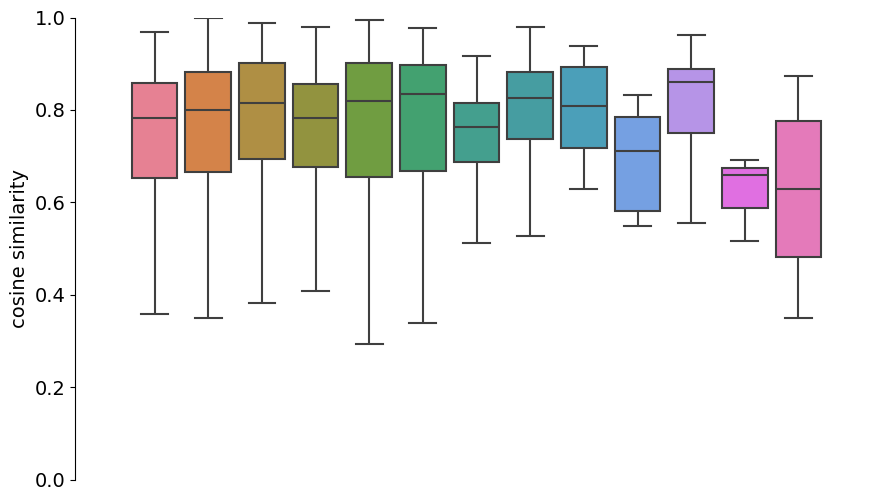

In [ ]:
from fiora.visualization.define_colors import adjust_box_widths
fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax = sns.boxplot(ax=ax, data=df_test[df_test["Superclass"] != "nan"], y="spectral_sqrt_cosine", dodge=True, width=0.9, linewidth=1.5, hue="Superclass", legend=False, palette=legend_colors, showfliers=False)
ax.set_ylabel("cosine similarity", fontsize=14)
ax.set_ylim([0,1])
plt.tick_params(axis='y', labelsize=14) 
ax.set_xticks([])
sns.despine(offset=10, trim=True)
ax.spines['bottom'].set_visible(False)

adjust_box_widths(ax, 0.85)

#fig.savefig(f"{home}/images/paper/cosine_by_class.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig(f"{home}/images/paper/cosine_by_class.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

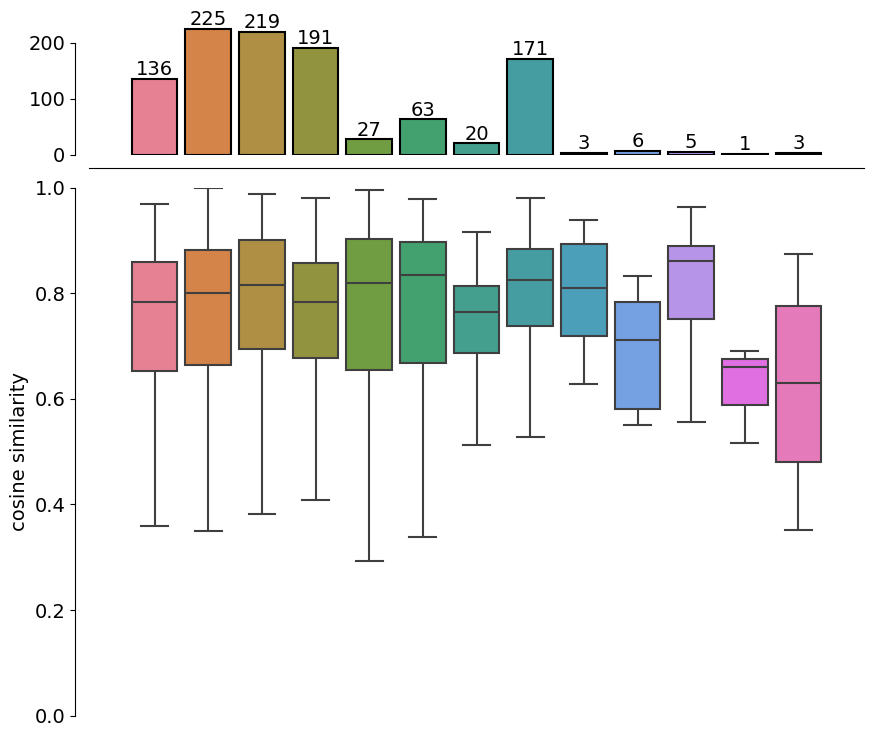

                                    Superclass num_spectra num_compounds
0              Lipids and lipid-like molecules         684           136
1                                   Benzenoids        1789           225
2                 Organoheterocyclic compounds        1347           219
3                Organic acids and derivatives        1693           191
4                   Organic nitrogen compounds         243            27
5                     Organic oxygen compounds         489            63
6                    Alkaloids and derivatives          84            20
7             Phenylpropanoids and polyketides        1033           171
8                       Organosulfur compounds          11             3
9    Lignans, neolignans and related compounds          22             6
10     Nucleosides, nucleotides, and analogues          19             5
11                     Hydrocarbon derivatives           3             1
12                     Organohalogen compounds     

In [ ]:
from fiora.visualization.define_colors import adjust_box_widths, adjust_bar_widths
fig, axs = plt.subplots(2,1, figsize=(10, 9), sharex=True, height_ratios=[1,4])
plt.subplots_adjust(hspace=0.1)#top=0.94, bottom=0.12, right=0.97, left=0.08)

superclass_data = {}
for i, superclass in enumerate(df_test["Superclass"].unique()):
    if superclass != "nan":
        superclass_data[i] = {"Superclass": superclass, "num_spectra": sum(df_test["Superclass"] == superclass), "num_compounds": df_test[df_test["Superclass"] == superclass]["group_id"].nunique()}

superclass_data = pd.DataFrame(superclass_data).transpose()

axs[0] = sns.barplot(ax=axs[0], data=superclass_data,y="num_compounds", dodge=True, width=0.9, edgecolor="black", linewidth=1.5, hue="Superclass", legend=False, palette=legend_colors)
for i in range(len(axs[0].containers)):
    axs[0].bar_label(axs[0].containers[i], fontsize=14)
axs[0].set_ylabel("", fontsize=14)
axs[0].spines['bottom'].set_visible(False)
axs[0].tick_params(axis='y', labelsize=14) 
adjust_bar_widths(axs[0], 0.85)


axs[1] = sns.boxplot(ax=axs[1], data=df_test[df_test["Superclass"] != "nan"], y="spectral_sqrt_cosine", dodge=True, width=0.9, linewidth=1.5, hue="Superclass", legend=False, palette=legend_colors, showfliers=False)
axs[1].set_ylabel("cosine similarity", fontsize=14)
axs[1].set_ylim([0,1])
plt.tick_params(axis='y', labelsize=14) 
axs[1].set_xticks([])
sns.despine(offset=10, trim=True)
axs[1].spines['bottom'].set_visible(False)
adjust_box_widths(axs[1], 0.85)

# fig.savefig(f"{home}/images/paper/cosine_by_class_+hist.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/cosine_by_class_+hist.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()
print(superclass_data)


In [ ]:

# print(df_test.groupby("Superclass").group_id.unique().apply(len))
# print(df_test.groupby("Superclass").spectral_sqrt_cosine.median())
# #df_test.groupby("Superclass").spectral_sqrt_cosine.median()
result = df_test.groupby("Superclass").agg(
    num=("group_id", lambda x: len(x.unique())),
    spec=("group_id", lambda x: len(x)),
    cos=("spectral_sqrt_cosine", "median")
)
print(result)

                                            num  spec       cos
Superclass                                                     
 Alkaloids and derivatives                   20    84  0.763521
 Benzenoids                                 225  1789  0.800067
 Hydrocarbon derivatives                      1     3  0.659294
 Lignans, neolignans and related compounds    6    22  0.710502
 Lipids and lipid-like molecules            136   684  0.782626
 Nucleosides, nucleotides, and analogues      5    19  0.860925
 Organic acids and derivatives              191  1693  0.782916
 Organic nitrogen compounds                  27   243  0.818335
 Organic oxygen compounds                    63   489  0.833673
 Organohalogen compounds                      3    21  0.629705
 Organoheterocyclic compounds               219  1347  0.814948
 Organosulfur compounds                       3    11  0.808732
 Phenylpropanoids and polyketides           171  1033  0.824680


In [ ]:
from fiora.visualization.define_colors import adjust_box_widths
fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax = sns.boxplot(ax=ax, data=df_test[df_test["Class"] != "nan"], y="spectral_sqrt_cosine", dodge=True, width=0.9, linewidth=1.5, hue="Class", legend=False, palette=legend_colors, showfliers=False)
ax.set_ylabel("cosine similarity", fontsize=14)
ax.set_ylim([0,1])
plt.tick_params(axis='y', labelsize=14) 
ax.set_xticks([])
sns.despine(offset=10, trim=True)
ax.spines['bottom'].set_visible(False)

adjust_box_widths(fig, 0.85)
#fig.savefig(f"{home}/images/paper/cosine_by_class.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig(f"{home}/images/paper/cosine_by_class.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

: 

##### Lipid class

In [ ]:
df_test[df_test["Superclass"] == " Lipids and lipid-like molecules"].drop_duplicates("group_id", keep="first")["Class"].value_counts()

: 

In [ ]:
num_classes = len(compound_classes["Class"].unique())
class_map = dict(zip(compound_classes["Class"].unique(), range(0, num_classes)))
test_embeddings = []
test_classes = []
colors = []
classmap = {}
supermap = {}
submap = {}
pal = sns.color_palette("viridis", num_classes)

for i, d in df_test[df_test["Superclass"] == " Lipids and lipid-like molecules"].drop_duplicates("group_id", keep="first").iterrows():
    metabolite = d["Metabolite"]
    group_id = d["group_id"]

    cclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Class"]

    data = metabolite.as_geometric_data(with_labels=False).to(dev)
    batch = geom.data.Batch.from_data_list([data])
    embedding = model.get_graph_embedding(batch)
    test_embeddings += [embedding.flatten().cpu().detach().numpy()]
    test_classes += [cclass]

    colors += [pal[class_map[cclass]]]


: 

In [ ]:
import matplotlib
import umap

reset_matplotlib()
reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, random_state=0, n_jobs=1) # creates different umaps despite fixed seed. Reason probably pytorch.
reducer.fit(test_embeddings)
e = reducer.transform(test_embeddings)

fig, ax = plt.subplots(1,1, figsize=(8,8))
scatter = sns.scatterplot(ax=ax,
    x=e[:, 0],
    y=e[:, 1],
    hue=test_classes, edgecolor="white", linewidth=0.48, s=40, palette=sns.color_palette("husl", 6), style=test_classes, markers=["o", (4,0, 45), "D", "v", "p", (4,1,0), "X"])# markers=["o", "*", "s", "^", "D", "h", (4,1,0),"v", "X", "P", "p", "<", (4,0, 45)] s=30,, hue_order=np.unique(test_classes)[::-1])#, order=[' Organic acids and derivatives', ' Organoheterocyclic compounds', ' Benzenoids', ' Alkaloids and derivatives', ' Phenylpropanoids and polyketides', ])#, palette=sns.color_palette("colorblind") + ["black", "gray", "white"])
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#plt.gca().set_aspect('equal', 'datalim')
#plt.ylim([-2.50,13])
#plt.xlim([-2.50,13])
#ax.set_aspect('equal', 'datalim')
#print(ax.get_xlim())
#ax.set_xlim((4.18, 14.15))
#ax.set_ylim(ax.get_xlim())
# Get the default marker size
default_marker_size = ax.collections[0].get_sizes()[0]

# Print the default marker size
print("Default marker size:", default_marker_size)
#ax.set_ylim([4, 12])
# fig.savefig(f"{home}/images/paper/umap_lipids_local.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/umap_lipids_local.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/umap_lipids_local.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

# Get the default line width (edges)
default_line_width = ax.collections[0].get_linewidths()[0]

# Print the default line width
print("Default line width (edges):", default_line_width)

# Get the legend handles and labels
handles = legend.legend_handles

# Get the facecolors from the legend handles (for scatter plot markers)
legend_colors = [handle.get_color() for handle in handles]# if isinstance(handle, matplotlib.patches.PathPatch)]


plt.show()

: 

### Tanimoto distance

In [ ]:
df_cas["Dataset"] = "CASMI 16"
df_cas22["Dataset"] = "CASMI 22"
df_test["Dataset"] = "Test split"
df_msnlib_test["Dataset"] = "MSnLib"
C = pd.concat([df_test, df_msnlib_test, df_cas, df_cas22], ignore_index=True)

In [ ]:
calc_tanimoto = True # This may tak a long time
if calc_tanimoto:    
    print("Calculating Tanimoto scores. This may take a while")
    df_cas.loc[:,"tanimoto"] = np.nan
    for i,d in df_cas.iterrows():
        df_cas.at[i, "tanimoto"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        df_cas.at[i, "tanimoto3"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"], finger="morgan3")).max()
        
    df_cas22.loc[:,"tanimoto"] = np.nan
    for i,d in df_cas22.iterrows():
        df_cas22.at[i, "tanimoto"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        df_cas22.at[i, "tanimoto3"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"], finger="morgan3")).max()
        
    df_test.loc[:,"tanimoto"] = np.nan
    for i,d in df_test.iterrows():
        df_test.at[i, "tanimoto"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        df_test.at[i, "tanimoto3"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"], finger="morgan3")).max()
        
    df_msnlib_test.loc[:,"tanimoto"] = np.nan
    df_msnlib_test.loc[:,"tanimoto3"] = np.nan
    for i,d in df_msnlib_test.iterrows():
        df_msnlib_test.at[i, "tanimoto"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        df_msnlib_test.at[i, "tanimoto3"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"], finger="morgan3")).max()


Calculating Tanimoto scores. This may take a while


In [ ]:
df_test["group_id"] = df_test["group_id"].astype(int)
new_value_offset = 100000
# Function to assign unique metabolite identifiers
def assign_metabolite_ids(df_ref: pd.DataFrame, metabolite_id_map):
    for i, data in df_ref.iterrows():
        metabolite = data["Metabolite"]
        is_new = True
        for id, other in metabolite_id_map.items():
            if metabolite == other:
                # Set the metabolite ID in the dataframe
                df_ref.loc[i, "group_id"] = int(id)
                is_new = False
                break
        if is_new:
            new_id = new_value_offset + len(metabolite_id_map)
            df_ref.loc[i, "group_id"] = int(new_id)
            metabolite_id_map[int(new_id)] = metabolite

if calc_tanimoto:
    # Initialize the metabolite_id_map with metabolites from df_test
    metabolite_id_map = {}
    for group_id in df_test["group_id"].unique():
        metabolite = df_test.loc[df_test["group_id"] == group_id, "Metabolite"].iloc[0]
        metabolite_id_map[int(group_id)] = metabolite


    # Apply the function to each dataframe
    assign_metabolite_ids(df_msnlib_test, metabolite_id_map)
    assign_metabolite_ids(df_cas, metabolite_id_map)
    assign_metabolite_ids(df_cas22, metabolite_id_map)
    
    df_msnlib_test["group_id"] = df_msnlib_test["group_id"].astype(int)
    df_cas["group_id"] = df_cas["group_id"].astype(int)
    df_cas22["group_id"] = df_cas22["group_id"].astype(int)


/tmp/ipykernel_1758053/2468361651.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.pointplot(ax=ax, data=C, x=pd.cut(C[C["Precursor_type"] == "[M+H]+"]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", palette=sns.color_palette("bright"), capsize=.0, hue="Dataset", dodge=0.25, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")


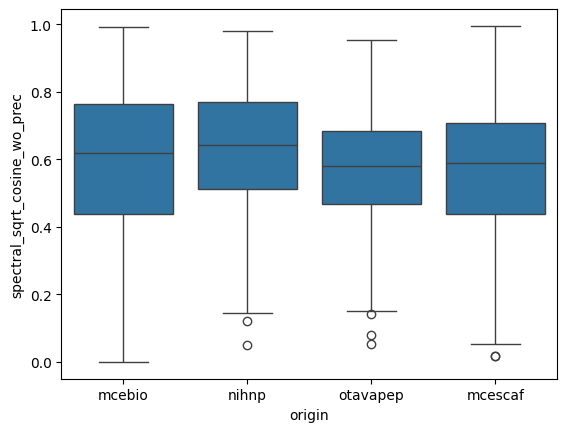

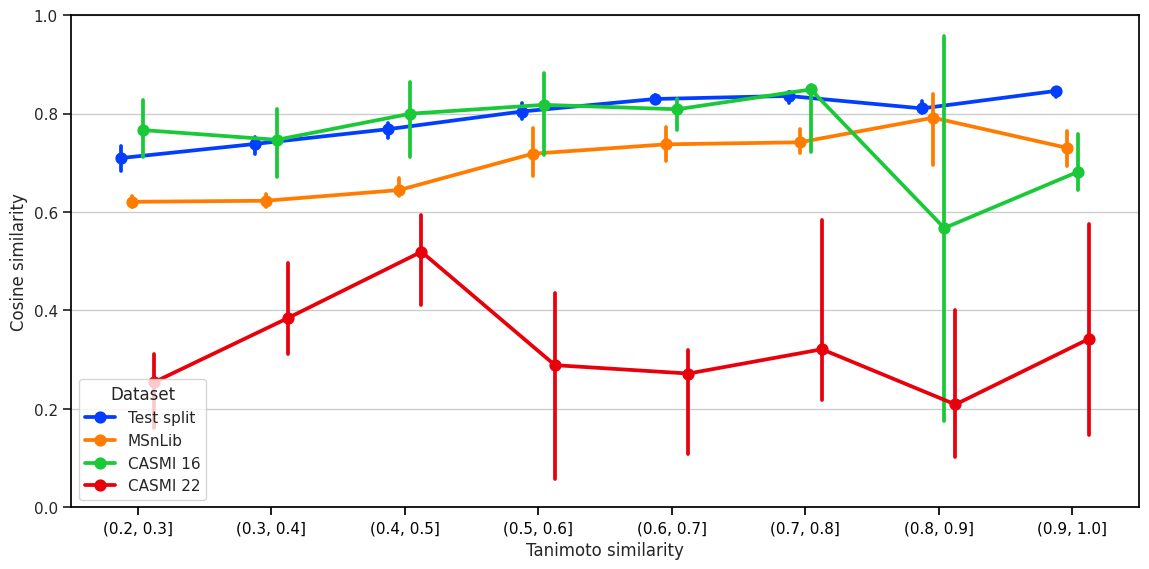

In [ ]:
from fiora.visualization.define_colors import *

if calc_tanimoto:
    set_light_theme()
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

    C = pd.concat([df_test, df_msnlib_test, df_cas, df_cas22], ignore_index=True)
    sns.pointplot(ax=ax, data=C, x=pd.cut(C[C["Precursor_type"] == "[M+H]+"]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", palette=sns.color_palette("bright"), capsize=.0, hue="Dataset", dodge=0.25, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0, 1])
    plt.legend(title="Dataset", loc="lower left")
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    
    # fig.savefig(f"{home}/images/paper/tanimoto_withcasmi.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_withcasmi.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_withcasmi.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()

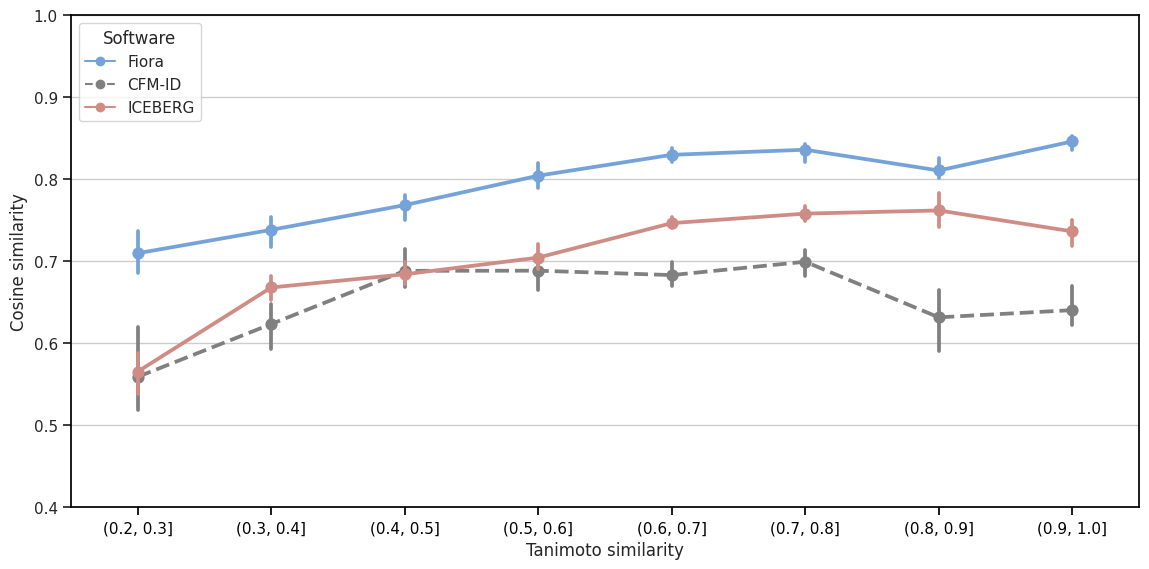

In [ ]:
if calc_tanimoto:
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

    
    sns.pointplot(ax=ax, data=C, x=pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", capsize=.0, color=lightblue_hex, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    sns.pointplot(ax=ax, data=C, x=pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="cfm_sqrt_cosine", capsize=.0, color="gray", estimator="median", linestyle="--") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    sns.pointplot(ax=ax, data=C, x=pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="ice_sqrt_cosine", capsize=.0, color=lightpink_hex, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0.4, 1])
    custom_lines = [plt.Line2D([0], [0], color=lightblue_hex, linestyle='-', marker="o"), plt.Line2D([0], [0], color='gray', linestyle='--', marker="o"), plt.Line2D([0], [0], color=lightpink_hex, linestyle='-', marker="o")]
    plt.legend(custom_lines, ["Fiora", "CFM-ID", "ICEBERG"], title="Software", loc="upper left")
    
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    # fig.savefig(f"{home}/images/paper/tanimoto.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)

    plt.show()

/tmp/ipykernel_1758053/3288945500.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby(binned_data)["group_id"].nunique().reset_index(name="unique_group_ids")


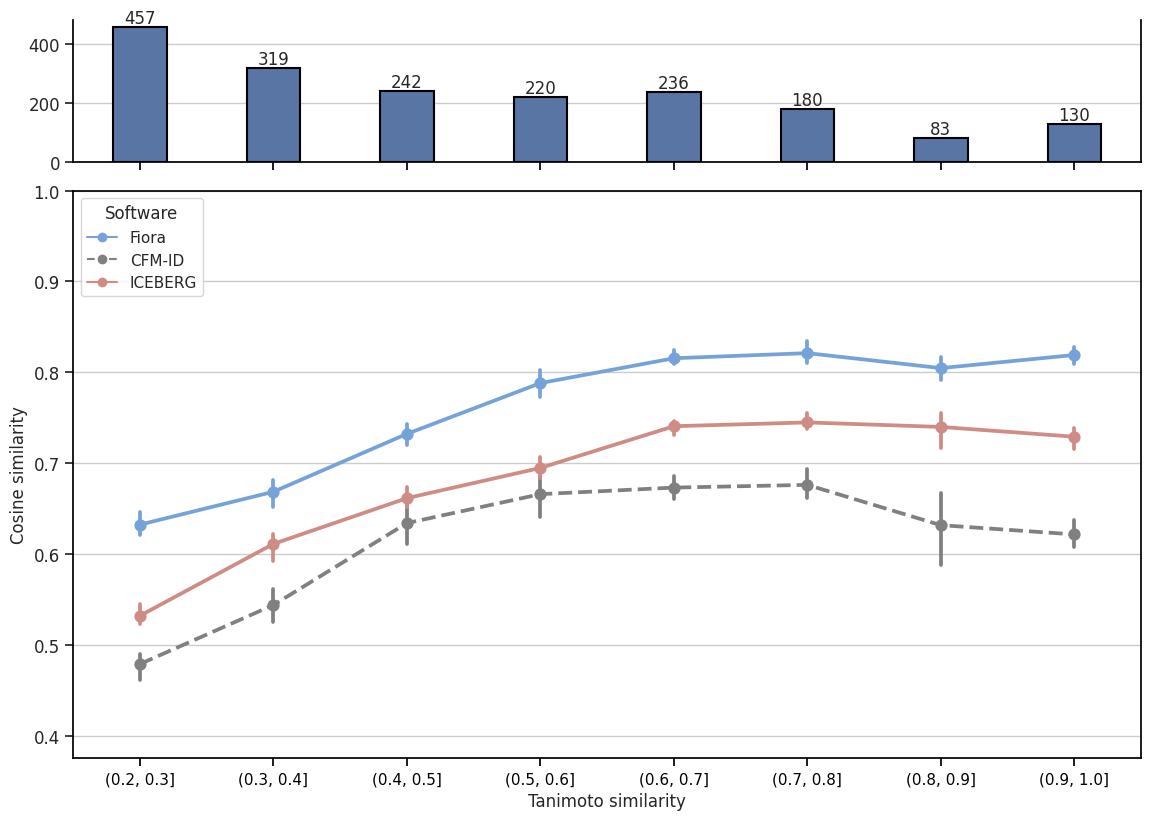

In [ ]:
datasets = ["Test split", "MSnLib", "CASMI 16", "CASMI 22"]
score_func = "spectral_sqrt_cosine"
if calc_tanimoto:
    fig, axs = plt.subplots(2,1, figsize=(12, 9), height_ratios=[1,4], sharex=True)
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.08)

    binned_data = pd.cut(C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)]["tanimoto3"], bins=[x/10.0 for x in list(range(2,11,1))]).dropna()
    grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby(binned_data)["group_id"].nunique().reset_index(name="unique_group_ids")

    sns.barplot(ax=axs[0], x=binned_data.cat.categories, y="unique_group_ids", data=grouped_data, linewidth=1.5, edgecolor="black")

    for i in range(len(axs[0].containers)):
        axs[0].bar_label(axs[0].containers[i], fontsize=12)
    axs[0].set_ylabel("", fontsize=14)
    axs[0].set_xlabel("", fontsize=14)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(True)
    axs[0].tick_params(axis='y', labelsize=12) 
    adjust_bar_widths(axs[0], 0.5)
    err = ('ci', 95)
    sns.pointplot(ax=axs[1], data=C, x=binned_data, y=score_func, capsize=.0, color=lightblue_hex, estimator="median", errorbar=err) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    sns.pointplot(ax=axs[1], data=C, x=binned_data, y=score_func.replace("spectral", "cfm"), capsize=.0, color="gray", estimator="median", linestyle="--", errorbar=err) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    sns.pointplot(ax=axs[1], data=C, x=binned_data, y=score_func.replace("spectral", "ice"), capsize=.0, color=lightpink_hex, estimator="median", errorbar=err) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0.375, 1])
    custom_lines = [plt.Line2D([0], [0], color=lightblue_hex, linestyle='-', marker="o"), plt.Line2D([0], [0], color='gray', linestyle='--', marker="o"), plt.Line2D([0], [0], color=lightpink_hex, linestyle='-', marker="o")]
    plt.legend(custom_lines, ["Fiora", "CFM-ID", "ICEBERG"], title="Software", loc="upper left")
    
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    axs[1].spines['top'].set_visible(True)
    axs[1].tick_params(axis='y', labelsize=12) 

    # fig.savefig(f"{home}/images/paper/tanimoto_+hist.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_+hist.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_+hist.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)

    plt.show()

In [ ]:
# Filter the DataFrame based on Precursor_type and Dataset
C = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)]
score_cols = ["spectral_sqrt_cosine", "ice_sqrt_cosine", "cfm_sqrt_cosine"]

# Melt the DataFrame to explode the scores into a long format
melted_df = pd.melt(C, 
                     id_vars=["tanimoto3", "Precursor_type", "Dataset"], 
                     value_vars=score_cols, 
                     var_name="Software", 
                     value_name="Score")

# Map the software names to more descriptive names
melted_df["Software"] = melted_df["Software"].map({
    "spectral_sqrt_cosine": "Fiora",
    "ice_sqrt_cosine": "ICEBERG",
    "cfm_sqrt_cosine": "CFM-ID"
})

# Now melted_df contains the new format
print(melted_df.head())

   tanimoto3 Precursor_type     Dataset Software     Score
0   0.951807         [M+H]+  Test split    Fiora  0.903236
1   0.951807         [M+H]+  Test split    Fiora  0.878908
2   0.951807         [M+H]+  Test split    Fiora  0.879749
3   0.951807         [M+H]+  Test split    Fiora  0.892044
4   0.951807         [M+H]+  Test split    Fiora  0.859664


/tmp/ipykernel_1758053/3035504744.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = melted_df.groupby('Binned')['Software'].nunique().reset_index(name="unique_group_ids")


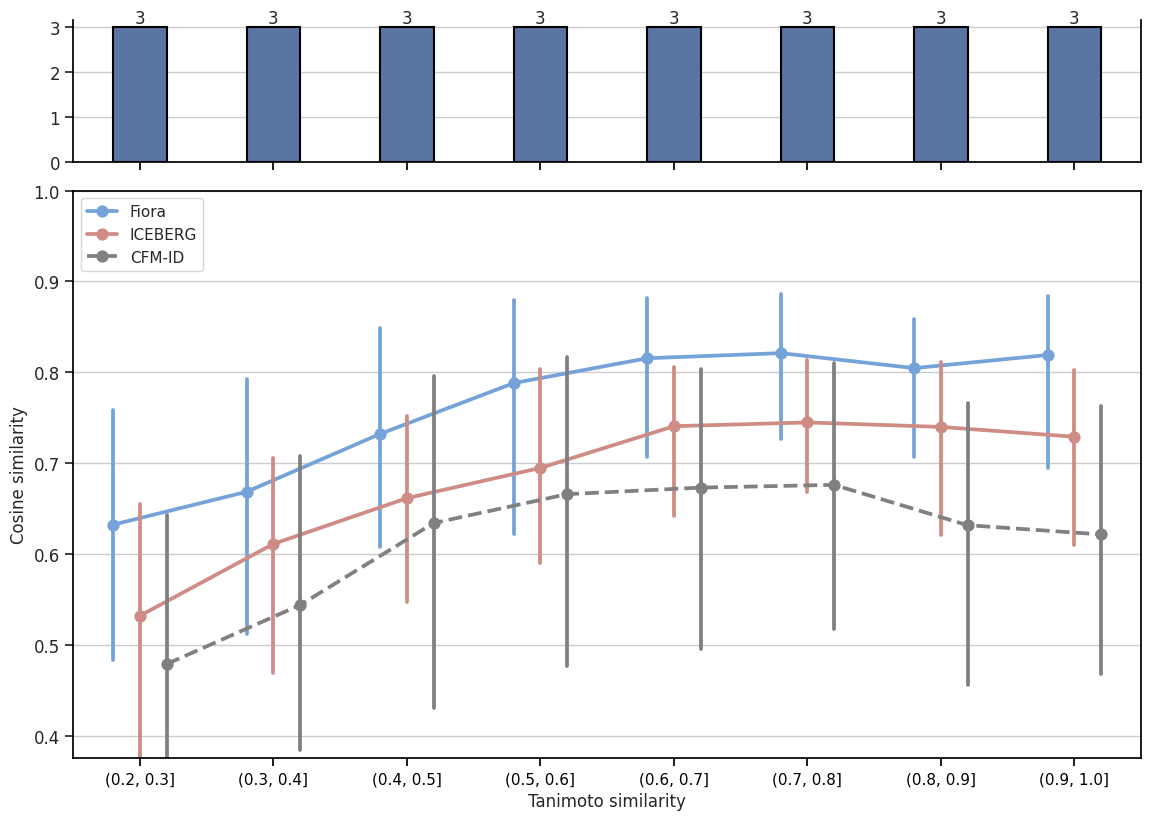

In [ ]:
datasets = ["Test split", "MSnLib", "CASMI 16", "CASMI 22"]
if calc_tanimoto:
    fig, axs = plt.subplots(2, 1, figsize=(12, 9), height_ratios=[1, 4], sharex=True)
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.08)

    # Prepare binned data from melted_df
    melted_df = melted_df[melted_df["Dataset"].isin(datasets)]  # Use only relevant datasets
    binned_data = pd.cut(melted_df["tanimoto3"], bins=[x/10.0 for x in range(2, 11)]).dropna()

    # Add the binned data as a new column to melted_df
    melted_df['Binned'] = binned_data

    # Group for bar plot
    grouped_data = melted_df.groupby('Binned')['Software'].nunique().reset_index(name="unique_group_ids")

    # Bar plot
    sns.barplot(ax=axs[0], x='Binned', y='unique_group_ids', data=grouped_data, linewidth=1.5, edgecolor="black")

    for i in range(len(axs[0].containers)):
        axs[0].bar_label(axs[0].containers[i], fontsize=12)
    axs[0].set_ylabel("", fontsize=14)
    axs[0].set_xlabel("", fontsize=14)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(True)
    axs[0].tick_params(axis='y', labelsize=12) 
    adjust_bar_widths(axs[0], 0.5)

    err = ("pi", 50)  # Error bar type

    # Point plots with hue for Software
    sns.pointplot(ax=axs[1], data=melted_df, x='Binned', y='Score', hue='Software', capsize=.0, linestyle=["-", "-", "--"], palette=[lightblue_hex, lightpink_hex, "gray"], estimator="median", errorbar=err, dodge=0.4)
    plt.ylim([0.375, 1])


    plt.legend(loc="upper left")
    
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    axs[1].spines['top'].set_visible(True)
    axs[1].tick_params(axis='y', labelsize=12)

    plt.show()


/tmp/ipykernel_1758053/3109952041.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby([binned_data, "Dataset"])["group_id"].nunique().reset_index(name="unique_group_ids")


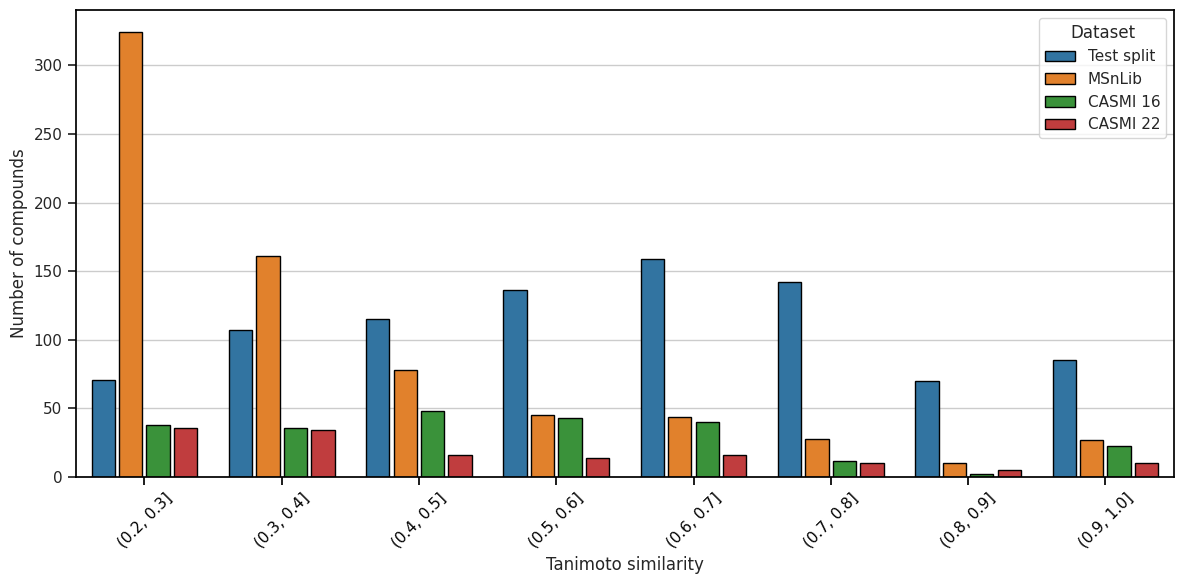

In [ ]:
if calc_tanimoto:

    fig, axs = plt.subplots(1,1, figsize=(12, 6))


    # Bin the data based on 'tanimoto3'
    binned_data = pd.cut(C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)]["tanimoto3"], 
                        bins=[x/10.0 for x in range(2, 11, 1)])

    # Group by both binned_data and 'Dataset', then count unique 'group_id'
    grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby([binned_data, "Dataset"])["group_id"].nunique().reset_index(name="unique_group_ids")

    sns.barplot(x="tanimoto3", y="unique_group_ids", hue="Dataset", data=grouped_data, palette="tab10", hue_order=datasets, edgecolor="black", gap=0.15)

    plt.xlabel("Tanimoto similarity")
    plt.ylabel("Number of compounds")
    plt.xticks(rotation=45)
    plt.legend(title="Dataset",loc='upper right')
    plt.tight_layout()

    # fig.savefig(f"{home}/images/paper/tanimoto_distribution.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_distribution.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_distribution.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [ ]:
if calc_tanimoto:
    medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2, 11, 1))]))['spectral_sqrt_cosine'].median()
    print(f"Fiora: {medians.min() / medians.max()}")
    medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2, 11, 1))]))['ice_sqrt_cosine'].median()
    print(f"ICEBERG: {medians.min() / medians.max()}")


Fiora: 0.8389002378493793
ICEBERG: 0.7421145603660584


/tmp/ipykernel_1758053/2650629896.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2, 11, 1))]))['spectral_sqrt_cosine'].median()
/tmp/ipykernel_1758053/2650629896.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[

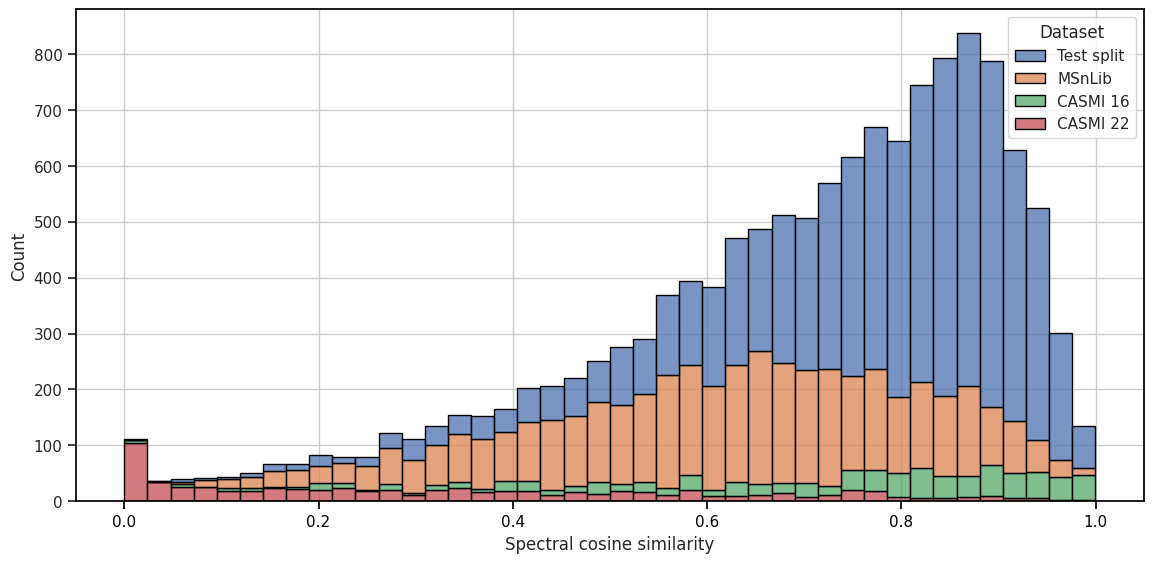

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.1)

C = pd.concat([df_test, df_msnlib_test, df_cas, df_cas22], ignore_index=True)

sns.histplot(C, ax=ax, x="spectral_sqrt_cosine", hue="Dataset", linewidth=1, multiple="stack", edgecolor="black")
ax.set_xlabel("Spectral cosine similarity")

# fig.savefig(f"{home}/images/paper/histplot_cosine.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/histplot_cosine.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/histplot_cosine.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()

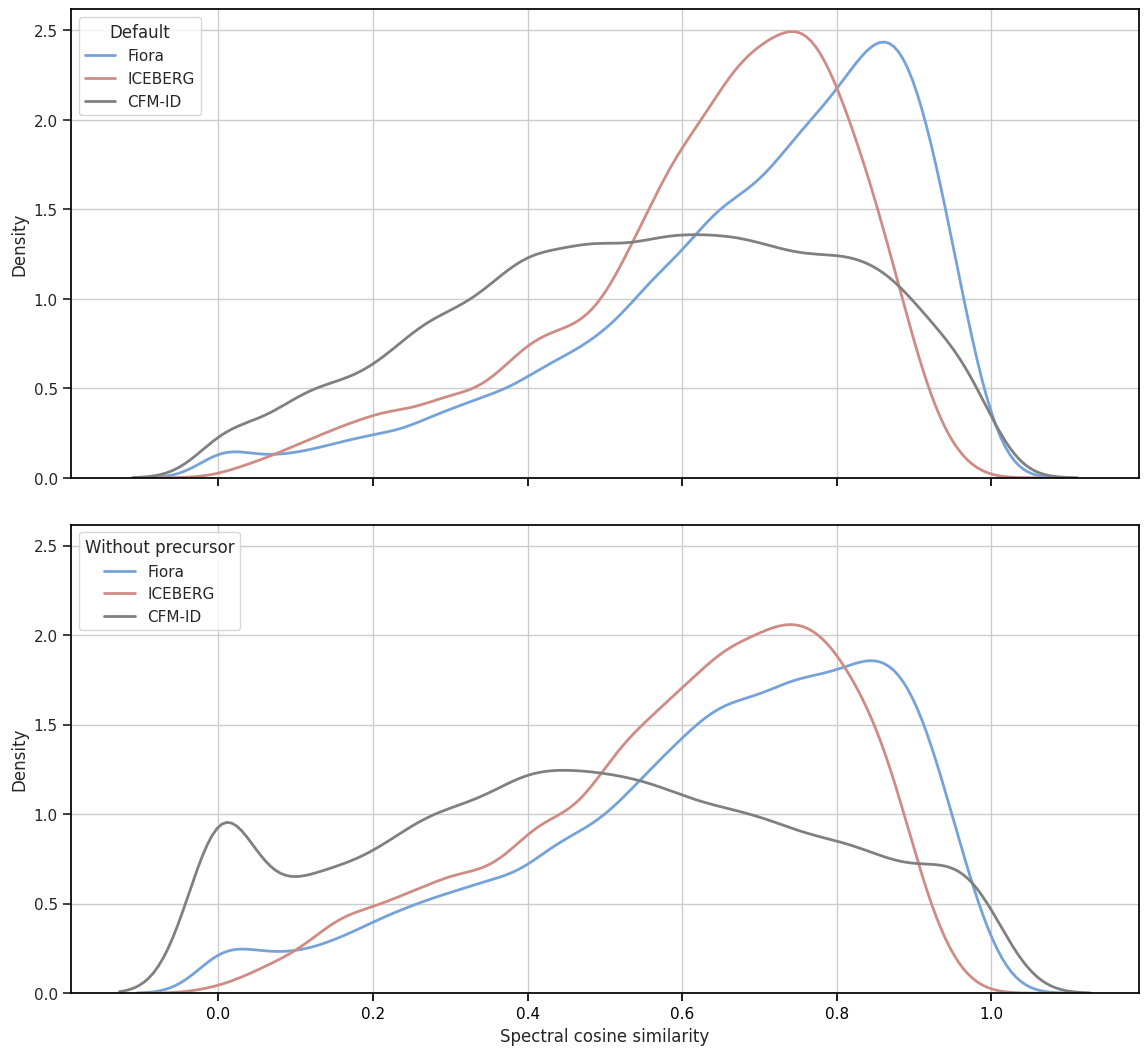

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1]}, sharex=True, sharey=True)
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.1)

C = pd.concat([df_test, df_msnlib_test, df_cas, df_cas22], ignore_index=True)

sns.kdeplot(C, ax=axs[0], x="spectral_sqrt_cosine", color=bluepink[0], linewidth=2)
sns.kdeplot(C, ax=axs[0], x="ice_sqrt_cosine", color=bluepink[1], linewidth=2)
sns.kdeplot(C, ax=axs[0], x="cfm_sqrt_cosine", color="gray", linewidth=2)
axs[0].legend(title="Default", labels=["Fiora", "ICEBERG", "CFM-ID"], loc="upper left")

sns.kdeplot(C, ax=axs[1], x="spectral_sqrt_cosine_wo_prec", color=bluepink[0], linewidth=2)
sns.kdeplot(C, ax=axs[1], x="ice_sqrt_cosine_wo_prec", color=bluepink[1], linewidth=2)
sns.kdeplot(C, ax=axs[1], x="cfm_sqrt_cosine_wo_prec", color="gray", linewidth=2)
axs[1].legend(title="Without precursor", labels=["Fiora", "ICEBERG", "CFM-ID"], loc="upper left")
axs[1].set_xlabel("Spectral cosine similarity")

# fig.savefig(f"{home}/images/paper/kdeplots_cosine.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/kdeplots_cosine.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/kdeplots_cosine.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
score = "spectral_sqrt_cosine"
score_w = score + "_wo_prec"

for dataset in ["Test split", "MSnLib", "CASMI 16", "CASMI 22"]:
    for p in C["Precursor_type"].unique()[:2]:
        Cx = C[(C["Dataset"] == dataset) & (C["Precursor_type"] == p)]
        dif = Cx[score].fillna(0.0) - Cx[score_w].fillna(0.0)
        abs_avg_dif = np.mean(dif)
        rel_avg_dif = np.mean(dif / Cx[score].fillna(0.0))
        
        print(f"Cosine loss from precursor removal (for {dataset} {p}): \t{abs_avg_dif:.2f} ({rel_avg_dif*100:2.1f}%)")

Cosine loss from precursor removal (for Test split [M+H]+): 	0.05 (6.8%)
Cosine loss from precursor removal (for Test split [M-H]-): 	0.07 (8.5%)
Cosine loss from precursor removal (for MSnLib [M+H]+): 	0.02 (3.0%)
Cosine loss from precursor removal (for MSnLib [M-H]-): 	0.04 (6.4%)
Cosine loss from precursor removal (for CASMI 16 [M+H]+): 	0.22 (27.8%)
Cosine loss from precursor removal (for CASMI 16 [M-H]-): 	0.26 (39.0%)
Cosine loss from precursor removal (for CASMI 22 [M+H]+): 	0.04 (7.8%)
Cosine loss from precursor removal (for CASMI 22 [M-H]-): 	0.02 (5.4%)


In [ ]:
print("Avg loss:", np.mean(C[score].fillna(0.0) - C[score_w].fillna(0.0)))
print("Avg pos loss:", np.mean(C[C["Precursor_type"] == "[M+H]+"][score].fillna(0.0) - C[C["Precursor_type"] == "[M+H]+"][score_w].fillna(0.0)))
print("Avg neg loss:", np.mean(C[C["Precursor_type"] == "[M-H]-"][score].fillna(0.0) - C[C["Precursor_type"] == "[M-H]-"][score_w].fillna(0.0)))

Avg loss: 0.055615078537930726
Avg pos loss: 0.05300015965304377
Avg neg loss: 0.061499250127451936


### Retention time

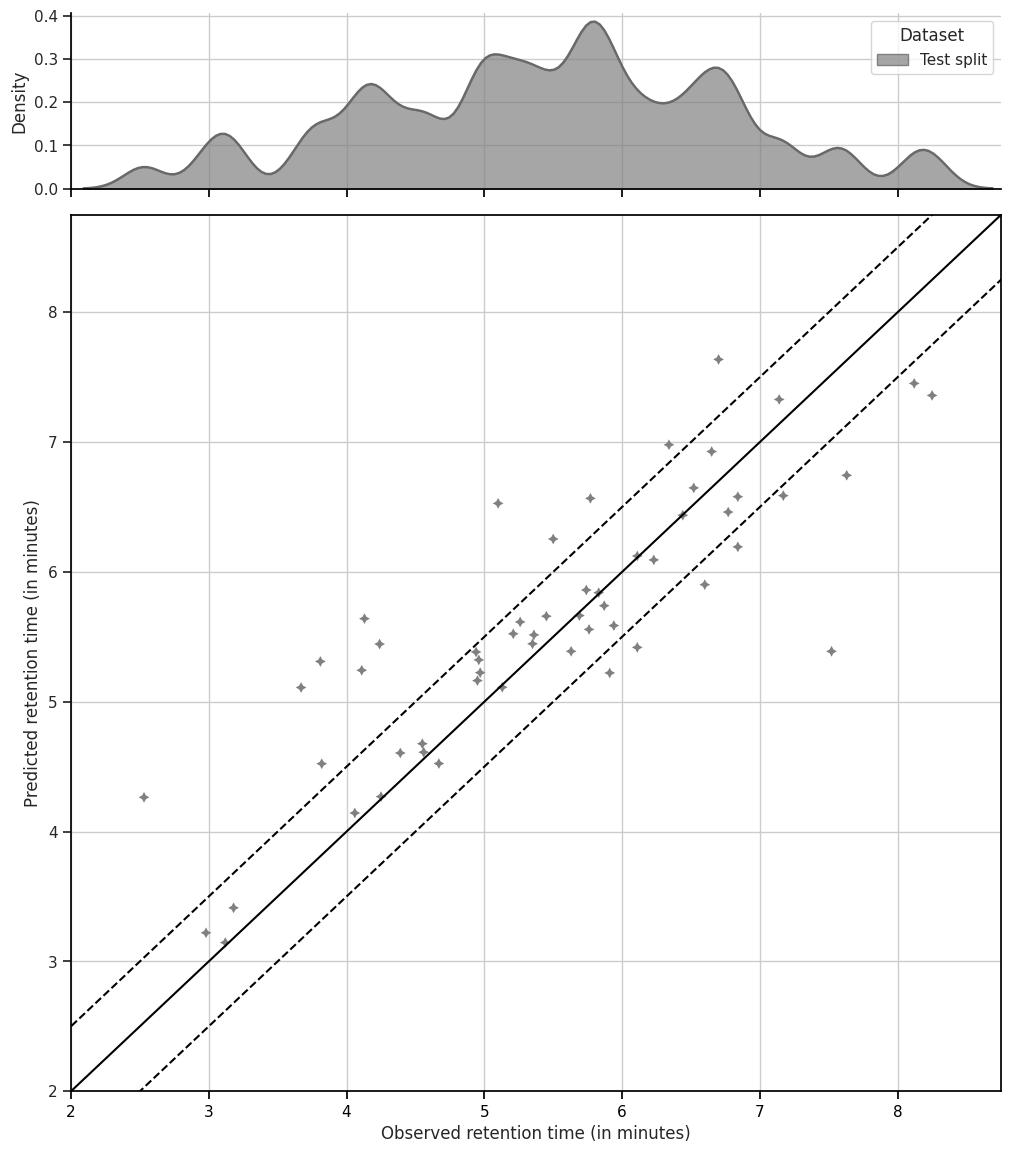

In [ ]:
from fiora.visualization.define_colors import set_light_theme, tri_palette

fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
set_light_theme()
set_light_theme()

df_test_unique = df_test.dropna(subset=["RETENTIONTIME"]).drop_duplicates(subset='SMILES', keep='first')


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, palette=["gray"], fill=True, hue="Dataset", alpha=0.7)#, multiple="stack") #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, color="#696969", linewidth=1.7) #, multiple="stack") #hue="Precursor_type", 

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=df_test_unique, x="RETENTIONTIME", y="RT_pred", color="gray", marker=(4,1,0), s=60, edgecolor="None")#, hue="library", palette=tri_palette,  style="library", color="gray")
axs[1].set_ylim([2,df_test_unique["RETENTIONTIME"].max() + 0.5])
axs[1].set_xlim([2,df_test_unique["RETENTIONTIME"].max() + 0.5])
axs[1].set_ylabel("Predicted retention time (in minutes)")
axs[1].set_xlabel("Observed retention time (in minutes)")
line = [0, 100]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[x + 30/60.0 for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[x - 30/60.0 for x in line], color="black", linestyle='--')

# sns.lineplot(ax=axs[1], x=line, y=[1.1*x for x in line], color="black", linestyle='--')
# sns.lineplot(ax=axs[1], x=line, y=[0.9*x for x in line], color="black", linestyle='--')

# fig.savefig(f"{home}/images/paper/rt.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/rt.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/rt.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:

print("Pearson Corr Coef:")
print("GNN PC", np.corrcoef(df_test_unique["RETENTIONTIME"], df_test_unique["RT_pred"].dropna(), dtype=float)[0,1])
print("GNN R2", r2_score(df_test_unique["RETENTIONTIME"], df_test_unique["RT_pred"].dropna()))


Pearson Corr Coef:
GNN PC 0.8475152203836579
GNN R2 0.6996957956957375


In [ ]:
df_train_rt = df_train[~df_train["RETENTIONTIME"].isna()].drop_duplicates(subset='group_id', keep='first')
df_test_rt = df_test[~df_test["RETENTIONTIME"].isna()].drop_duplicates(subset='group_id', keep='first')

In [ ]:
# Save MOL data as sdf for log p computation
# from rdkit import Chem
# # Write to SDF
# mol_list = list(df_train_rt["Metabolite"].apply(lambda x: x.MOL))
# with Chem.SDWriter(f'{home}/data/metabolites/rt/train.sdf') as sdf_writer:
#     for mol in mol_list:
#         sdf_writer.write(mol)

# mol_list = list(df_test_rt["Metabolite"].apply(lambda x: x.MOL))
# with Chem.SDWriter(f'{home}/data/metabolites/rt/test.sdf') as sdf_writer:
#     for mol in mol_list:
#         sdf_writer.write(mol)

In [ ]:
with open(f'{home}/data/metabolites/rt/train.logp') as infile:
    lines = infile.readlines()
logps = []
for line in lines[11:]:
    logp = float(line.strip().split(": ")[1])
    logps.append(logp)
df_train_rt["logp"] = logps

In [ ]:
with open(f'{home}/data/metabolites/rt/test.logp') as infile:
    lines = infile.readlines()
logps = []
for line in lines[11:]:
    logp = float(line.strip().split(": ")[1])
    logps.append(logp)
df_test_rt["logp"] = logps

In [ ]:
df_val = df_train[df_train["dataset"] == "validation"]
df_train = df_train[df_train["dataset"] == "training"]
df_train_rt = df_train_rt[df_train_rt["dataset"] == "training"]

In [ ]:
df_train_rt.shape

(490, 97)

In [ ]:

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_train_rt["logp"], df_train_rt["RETENTIONTIME"])
print("TEST SPLIT:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_test_rt["RETENTIONTIME"], df_test_rt["RT_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_test_rt["RETENTIONTIME"], intercept + slope * df_test_rt["logp"].dropna(), dtype=float)[0,1])

print("R2")
print("GNN", r2_score(df_test_rt["RETENTIONTIME"], df_test_rt["RT_pred"].dropna()))
print("LR ", r2_score(df_test_rt["RETENTIONTIME"], intercept + slope * df_test_rt["logp"].dropna()))

TEST SPLIT:

Pearson Corr Coef:
GNN 0.8475152203836579
LR  0.7963698987430773
R2
GNN 0.6996957956957375
LR  0.6302651345953529


### CCS values

/tmp/ipykernel_1758053/120299126.py:18: UserWarning: The markers list has more values (6) than needed (3), which may not be intended.
  sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[(4, 1, 0), "v", "o", (4,0,45), "v", "D"],s = 35, linewidth=.0)#, s=50, edgecolor="white")#, linewidth=.0)#, color="blue", edgecolor="blue")#,


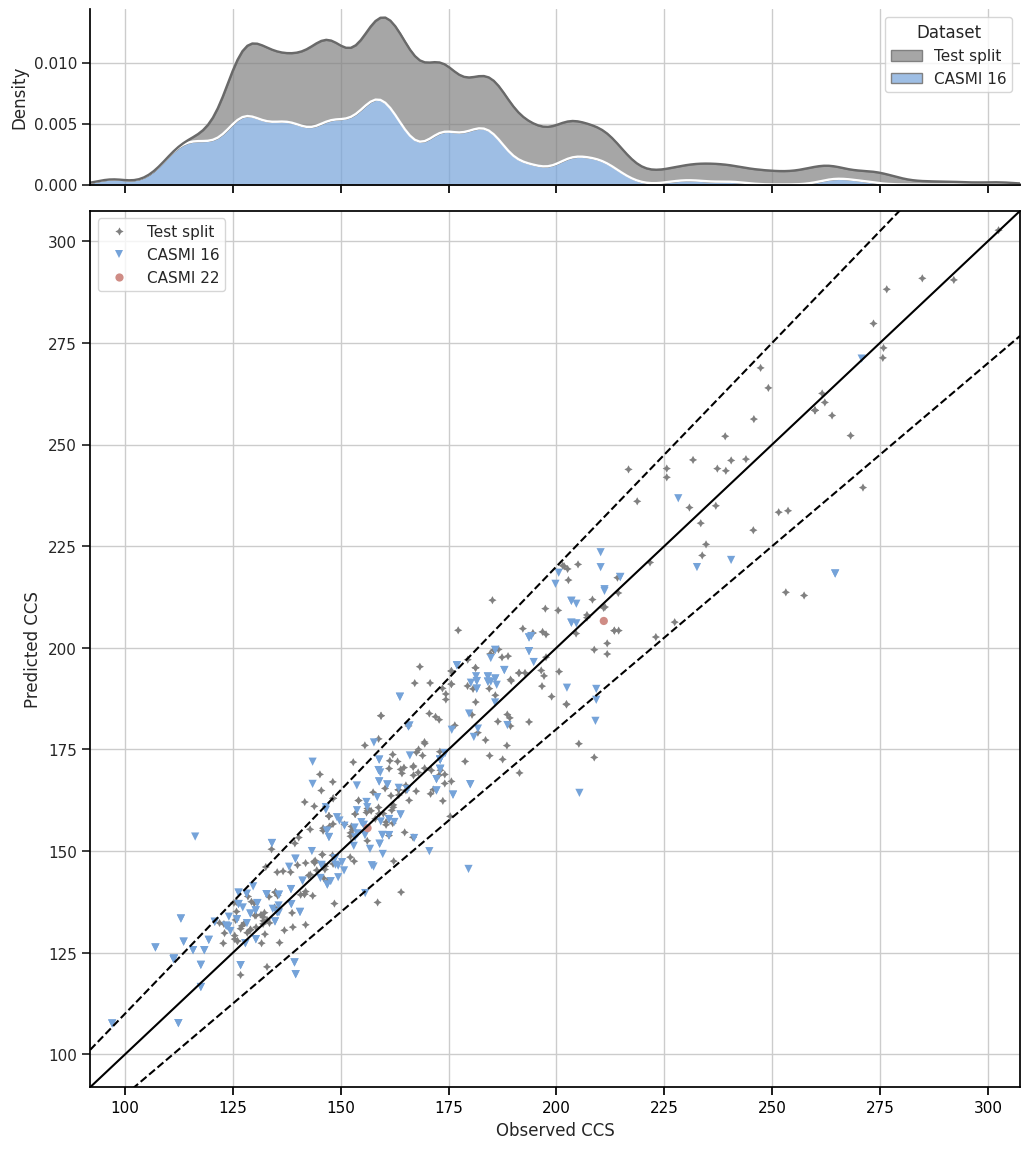

In [ ]:
# TODO NEXT UP!!
fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)

df_test_unique = df_test.dropna(subset=["CCS"]).drop_duplicates(subset='SMILES', keep='first')
df_cas22_unique = df_cas22.dropna(subset=["CCS"]).drop_duplicates(subset='SMILES', keep='first') # Note that with more lenient filters, CCS values might be annotated for CASMI 22

CCS = pd.concat([df_test_unique[["CCS", "CCS_pred", "Dataset"]], df_cas[["CCS", "CCS_pred", "Dataset"]], df_cas22_unique[["CCS", "CCS_pred", "Dataset"]] ], ignore_index=True) #


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CCS[CCS["Dataset"] != "CASMI 22"], x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=["#696969"] + ["white"], linewidth=1.7,  fill=False)#, edgecolor="lightgray") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CCS[CCS["Dataset"] != "CASMI 22"], x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=["gray"] + [tri_palette[1]], alpha=0.7, fill=True, edgecolor="gray")#, edgecolor="lightgray") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[(4, 1, 0), "v", "o", (4,0,45), "v", "D"],s = 35, linewidth=.0)#, s=50, edgecolor="white")#, linewidth=.0)#, color="blue", edgecolor="blue")#, 
axs[1].set_ylim([df_test_unique["CCS"].min() - 30,df_test_unique["CCS"].max() + 5])
axs[1].set_xlim([df_test_unique["CCS"].min() - 30,df_test_unique["CCS"].max() + 5])
axs[1].set_ylabel("Predicted CCS")
axs[1].set_xlabel("Observed CCS")
line=[df_test_unique["CCS"].min() - 30,df_test_unique["CCS"].max() + 5]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[1.1*x for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[0.9*x for x in line], color="black", linestyle='--')

fig.savefig(f"{home}/images/paper/ccs.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{home}/images/paper/ccs.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{home}/images/paper/ccs.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_train.dropna(subset=["CCS"])["PRECURSORMZ"], df_train.dropna(subset=["CCS"])["CCS"])
print("TEST SPLIT:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], intercept + slope *df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna(), dtype=float)[0,1])

print("R2")
print("GNN", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], intercept + slope *df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna()))

print("---------------\n\nCASMI-16:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], intercept + slope *df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna(), dtype=float)[0,1])
print("R2")
print("GNN", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], intercept + slope *df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna()))

TEST SPLIT:

Pearson Corr Coef:
GNN 0.9594764667036306
LR  0.9427339636827305
R2
GNN 0.9161597110929641
LR  0.8886506550173587
---------------

CASMI-16:

Pearson Corr Coef:
GNN 0.9336431158317965
LR  0.9043208592555432
R2
GNN 0.8640428738889065
LR  0.7997982164723981


In [ ]:
# Load coverage into dataframe
df_test["coverage"] = df_test["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 
df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 
df_cas22["coverage"] = df_cas22["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 

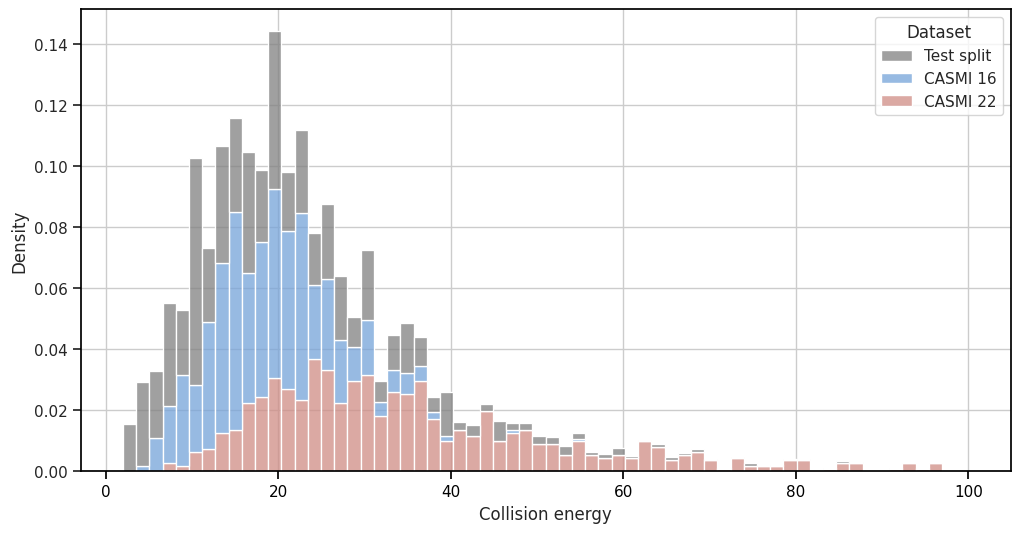

In [ ]:
CAT = pd.concat([df_test, df_cas, df_cas22])
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
set_light_theme()
sns.histplot(ax=ax, data=CAT, x="CE", hue="Dataset", multiple="stack", palette=tri_palette, stat="density", common_norm=False, kde=False)
plt.xlabel("Collision energy")
plt.show()

In [ ]:
df_test.columns

Index(['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type',
       'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet',
       'Ionization',
       ...
       'ice_peaks', 'ice_cosine', 'ice_sqrt_cosine', 'ice_sqrt_cosine_wo_prec',
       'ice_refl_cosine', 'ice_steins', 'Dataset', 'tanimoto', 'tanimoto3',
       'coverage'],
      dtype='object', length=116)

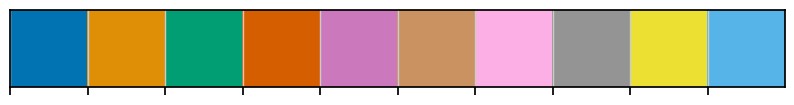

In [ ]:
sns.palplot(sns.color_palette("colorblind"))
plt.show()

/tmp/ipykernel_1758053/1074820115.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels)


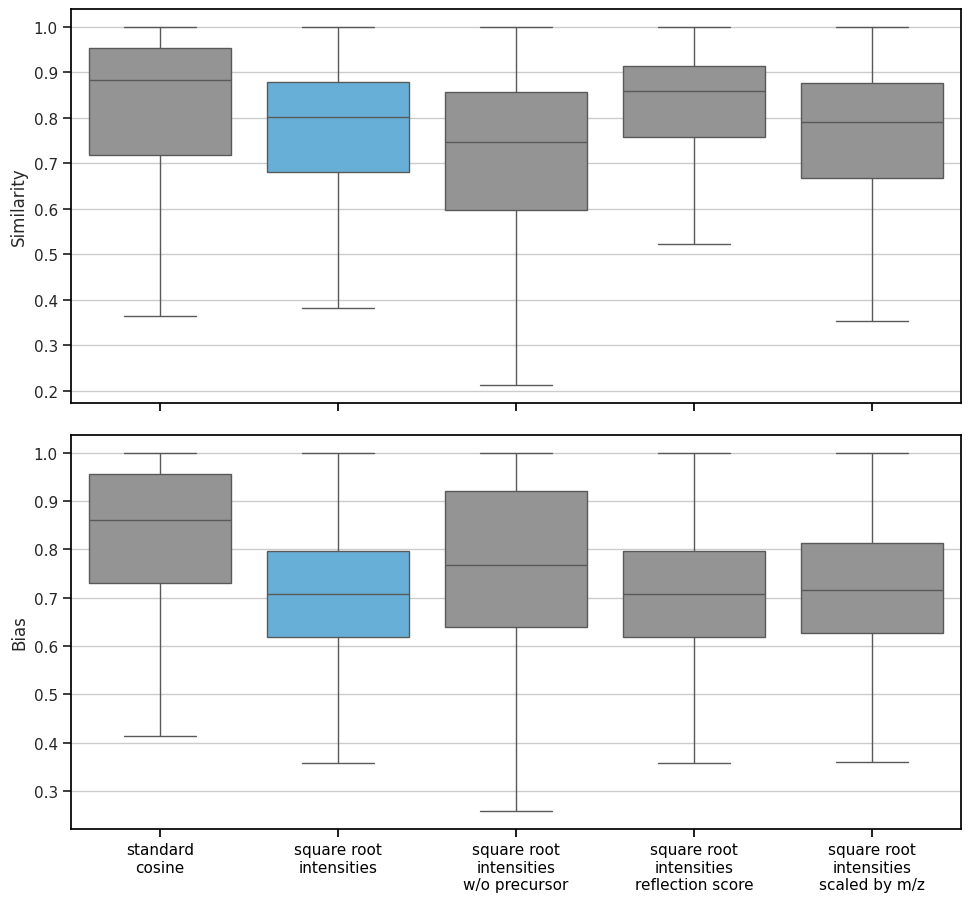

In [ ]:
set_light_theme()
scores = ["spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "steins_cosine"]
biases = [s.replace("cosine", "bias") for s in scores]
#labels = ["cosine", r"cosine $\sqrt{int}$ ", r"$\sqrt{i}$ cosine w/o precursor", r"$\sqrt{i}$ reflection cosine", r"$\sqrt{i}$ mass-weighted cosine"]

#labels = ["cosine", "sqrt cosine", "sqrt cosine w/o precursor", "sqrt reflection cosine", "sqrt mass-weighted cosine"]
labels = ["standard\ncosine", "square root\nintensities", "square root\nintensities\nw/o precursor", "square root\nintensities\nreflection score", "square root\nintensities\nscaled by m/z"]
S = df_test.melt(id_vars="Name", var_name="Score", value_vars=scores)
B = df_test.melt(id_vars="Name", var_name="Score", value_vars=biases)


fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=False)
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.08)


highlight_2=[sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[9], sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[7]]
sns.boxplot(ax=axs[0], data=S, y="value", x="Score", order=scores, hue="Score", palette=highlight_2, showfliers=False)
sns.boxplot(ax=axs[1], data=B, y="value", x="Score", order=biases, hue="Score", palette=highlight_2, showfliers=False)
axs[0].set_xticklabels("")
axs[0].set_xlabel("")
axs[0].set_ylabel("Similarity")
axs[1].set_xlabel("")
axs[1].set_xticklabels(labels)
axs[1].set_ylabel("Bias")
#axs[1].set_ylim([0, 1])
#axs[1].axhline(y=B.groupby('Score')['value'].median().min(), xmin=0, xmax=10, color="red", linestyle="--")
# fig.savefig(f"{home}/images/paper/scores_overview.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/scores_overview.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/scores_overview.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)


#plt.xticks(rotation=90)
plt.show()


In [ ]:
df_cas["spectral_sqrt_cosine"]

0      0.790930
1      0.643148
2      0.813172
3      0.971189
4      0.627250
         ...   
307    0.817873
308    0.883181
309    0.668729
310    0.176217
311    0.120273
Name: spectral_sqrt_cosine, Length: 832, dtype: float64

/tmp/ipykernel_1758053/961426693.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels)


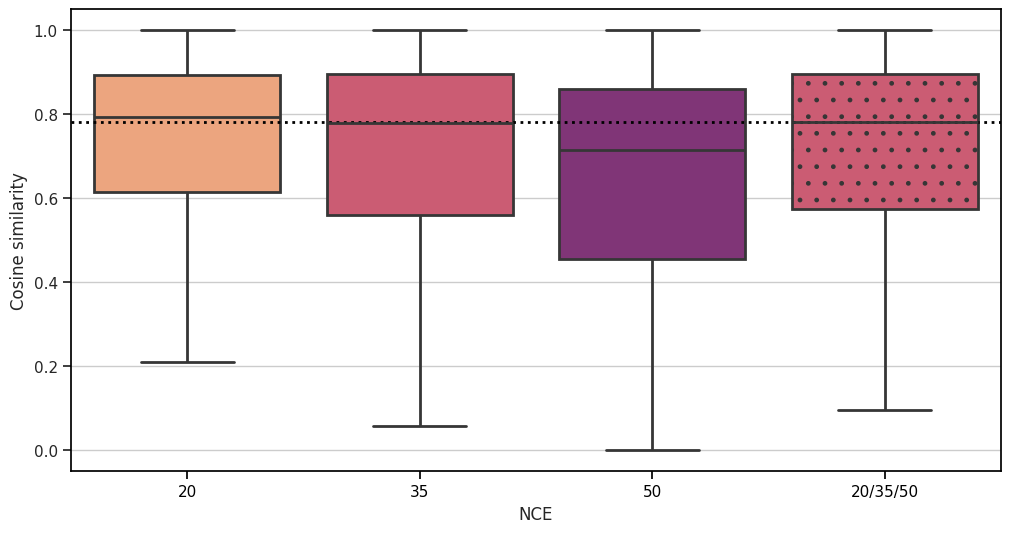

<Figure size 1000x600 with 0 Axes>

In [ ]:
set_light_theme()
fig, ax = plt.subplots(1,1, figsize=(12, 6))
score_columns = ["spectral_sqrt_cosine_20", "spectral_sqrt_cosine_35", "spectral_sqrt_cosine_50", "spectral_sqrt_cosine"]

df_filtered = df_cas[score_columns]

df_melted = df_filtered.melt(var_name='Score_Type')
custom_labels = ['20', '35', '50', '20/35/50']
magma = sns.color_palette("magma_r", 4)
adjusted_last_color = sns.utils.set_hls_values(magma[1], l=min(1.0, magma[-1][2] * 1.2))  # Increase lightness by 20%

# Plot boxplots
plt.figure(figsize=(10, 6))

ax = sns.boxplot(ax=ax, data=df_melted, x='Score_Type', y='value', hue='Score_Type', dodge=False, showfliers=False, palette=magma[:3] + [magma[1]], linewidth=2)
bars = ax.patches
bars[-1].set_hatch(".")
#bars[-1].set_hatch_linewidth(2)

ax.axhline(df_filtered["spectral_sqrt_cosine"].median(), color='black', linewidth=2, linestyle='dotted', label='Median of spectral_sqrt_cosine')
ax.set_xlabel('NCE')
ax.set_ylabel('Cosine similarity')
ax.set_xticklabels(custom_labels)
# fig.savefig(f"{home}/images/paper/NCE_casmi16.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/NCE_casmi16.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/NCE_casmi16.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [ ]:
df_melted.groupby("Score_Type")["value"].median()

Score_Type
spectral_sqrt_cosine        0.77988
spectral_sqrt_cosine_20    0.793816
spectral_sqrt_cosine_35    0.777671
spectral_sqrt_cosine_50    0.714046
Name: value, dtype: object

In [ ]:
df_cas.merged_sqrt_cosine_wo_precursor
df_cas.merged_sqrt_cosine_wo_precursor

0      0.000000
1      0.333050
2      0.060107
3      0.988923
4      0.160527
         ...   
307    0.850205
308    0.899672
309    0.050035
310    0.171897
311    0.135589
Name: merged_sqrt_cosine_wo_precursor, Length: 832, dtype: float64

In [ ]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [ ]:

def filter_peaks(peaks, fraction=0.8, max_peaks=100, min_mz=120):
    
    # d = {
    #     "mz": peaks["mz"],
    #     "intensity": peaks["intensity"]
    # }
    
    # high_mz_idx = np.where(np.array(d["mz"]) > min_mz)[0]
    # d["mz"] = d["mz"][high_mz_idx.tolist()] 
    # d["intensity"] = d["intensity"][high_mz_idx.tolist()]
    
    order = np.argsort(peaks["intensity"])[::-1] 
    value = fraction * np.sum(peaks["intensity"])
    num_of_relevant_peaks = min(max_peaks - 1, np.argmax(np.cumsum(np.array(peaks["intensity"])[order]) > value))
    indices = order[:num_of_relevant_peaks+1]
    
    
    d = {
        "mz": np.array(peaks["mz"])[indices].tolist(),
        "intensity": np.array(peaks["intensity"])[indices].tolist()
    }


    return d
    # return d

print(df_cas["peaks"].iloc[0])
p = filter_peaks(df_cas["peaks"].iloc[0], max_peaks=10)
p

{'mz': [107.0491, 131.0502, 157.0533, 158.0611, 222.023], 'intensity': [11496.1, 12601.5, 11285.7, 2146837.0, 10585360.0], 'annotation': [], 'mz_int': [1109.3453738624414, 1285.079412059815, 1331.3363315894296, 18420.950511325413, 48478.79312936739]}


{'mz': [222.023], 'intensity': [10585360.0]}

In [ ]:
df_cas22["num_peaks"] = df_cas22["peaks"].apply(lambda x: len(x["mz"]))
df_cas["num_peaks"] = df_cas["peaks"].apply(lambda x: len(x["mz"]))
df_test["num_peaks"] = df_test["peaks"].apply(lambda x: len(x["mz"]))
df_msnlib_test["num_peaks"] = df_msnlib_test["peaks"].apply(lambda x: len(x["mz"]))
df_cas22["filtered_peaks"] = df_cas22["peaks"].apply(lambda x: filter_peaks(x, max_peaks=20, fraction=0.8))
df_cas["filtered_peaks"] = df_cas["peaks"].apply(lambda x: filter_peaks(x, max_peaks=20,fraction=0.8))
df_test["filtered_peaks"] = df_test["peaks"].apply(lambda x: filter_peaks(x, max_peaks=20, fraction=0.8))
df_msnlib_test["filtered_peaks"] = df_msnlib_test["peaks"].apply(lambda x: filter_peaks(x, max_peaks=20, fraction=0.8))
df_cas22["num_filtered_peaks"] = df_cas22["filtered_peaks"].apply(lambda x: len(x["mz"]))
df_cas["num_filtered_peaks"] = df_cas["filtered_peaks"].apply(lambda x: len(x["mz"]))
df_test["num_filtered_peaks"] = df_test["filtered_peaks"].apply(lambda x: len(x["mz"]))
df_msnlib_test["num_filtered_peaks"] = df_msnlib_test["filtered_peaks"].apply(lambda x: len(x["mz"]))
CAT = pd.concat([df_test, df_msnlib_test, df_cas, df_cas22])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


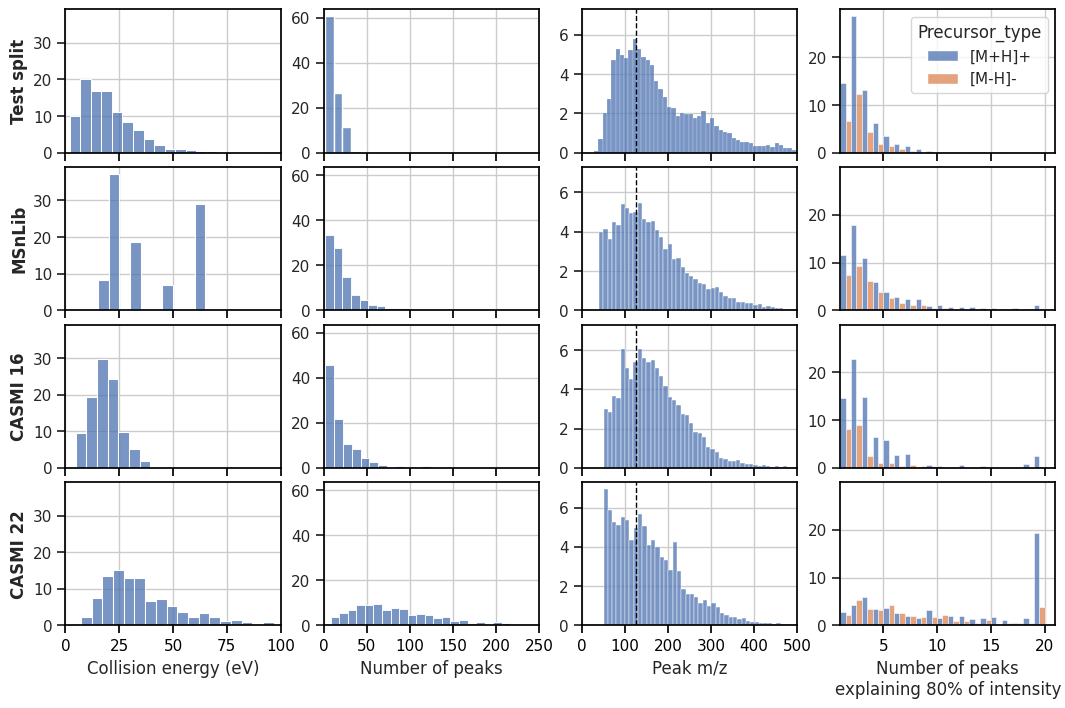

In [ ]:

fig, axs = plt.subplots(4, 4, figsize=(12, 8), sharex='col', sharey="col")
plt.subplots_adjust(hspace=0.1, wspace=0.20, right=0.95)#, top=0.94, bottom=0.12, right=0.97, left=0)

dataset_names = ["Test split", "MSnLib", "CASMI 16", "CASMI 22"]


# Loop through each row and set row labels
for i, dataset_name in enumerate(dataset_names):
    axs[i, 0].set_ylabel(dataset_name, rotation=90, labelpad=10, ha='center', va='center', fontsize=12, fontweight='bold')
    # Column 1
    sns.histplot(ax=axs[i, 0], data=CAT[CAT["Dataset"] == dataset_name], x="CE", binwidth=5, stat="percent")
    axs[i, 0].set_xlim(0, 100)
    axs[i,  0].set_xticks([0, 25, 50, 75, 100])
    axs[i,  0].set_xlabel("Collision energy (eV)")

    # Column 2
    sns.histplot(ax=axs[i, 1], data=CAT[CAT["Dataset"] == dataset_name], x="num_peaks", binwidth=10, stat="percent")
    axs[i, 1].set_xticks(list(range(0,260,50)))
    axs[i, 1].set_xlim(0, 250)
    axs[i, 1].set_xlabel("Number of peaks")
    axs[i, 1].set_ylabel("")

    
    # Column 3
    mz = [item for sublist in CAT[CAT["Dataset"] == dataset_name]["peaks"].apply(lambda x: x["mz"]) for item in sublist]    
    sns.histplot(mz, ax=axs[i, 2], binwidth=10, stat="percent")
    axs[i, 2].set_xticks(list(range(0,550,100)))
    axs[i, 2].set_xlim(0, 500)
    axs[i, 2].set_xlabel("Peak m/z")
    axs[i, 2].set_ylabel("")
    axs[i, 2].axvline(x=125, color='black', linestyle='--', linewidth=1)
    
    # Column 4
    sns.histplot(ax=axs[i, 3], data=CAT[CAT["Dataset"] == dataset_name], x="num_filtered_peaks", hue="Precursor_type", binwidth=1, stat="percent", multiple="dodge", hue_order=["[M+H]+", "[M-H]-"])
    axs[i, 3].set_xlim(1, 21)
    if i > 0:
        axs[i, 3].legend().set_visible(False)
    axs[i, 3].set_xlabel("Number of peaks\nexplaining 80% of intensity")
    axs[i, 3].set_ylabel("")
    
#fig.savefig(f"{home}/images/paper/data_hists.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig(f"{home}/images/paper/data_hists.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig(f"{home}/images/paper/data_hists.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
from fiora.MS.spectral_scores import spectral_cosine
df_cas22["filtered_cosine"] = df_cas22.apply(lambda x: spectral_cosine(x["sim_peaks"], x["filtered_peaks"], transform=np.sqrt) , axis=1)

In [ ]:
np.mean(df_cas22["num_peak_matches_filtered"] / df_cas22["num_peaks_filtered"])

0.24864732473075554

In [ ]:
np.median(df_cas22["coverage"])

0.32654889590667757

In [ ]:
np.sum(df_cas["spectral_sqrt_cosine"]>=0.70) / df_cas.shape[0]

0.6189903846153846

In [ ]:
np.mean(df_cas22["num_peak_matches_filtered"] / df_cas22["num_peaks_filtered"])

0.24864732473075554

In [ ]:
df_test["CE_10"] = np.ceil(df_test["CE"] / 10) * 10

/tmp/ipykernel_2553345/475011302.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axs[0,0], data=df_test, y="spectral_sqrt_cosine_wo_prec", x="CE_10", showfliers=False, palette=magma10, linewidth=1.5) # color="white", linewidth=2, linecolor="black")
/tmp/ipykernel_2553345/475011302.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axs[0,1], data=df_test, y="ice_sqrt_cosine_wo_prec", x="CE_10", showfliers=False, palette=magma10, linewidth=1.5)
/tmp/ipykernel_2553345/475011302.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(list(range(10, 110, 10)))
/tmp/ipykernel_2553

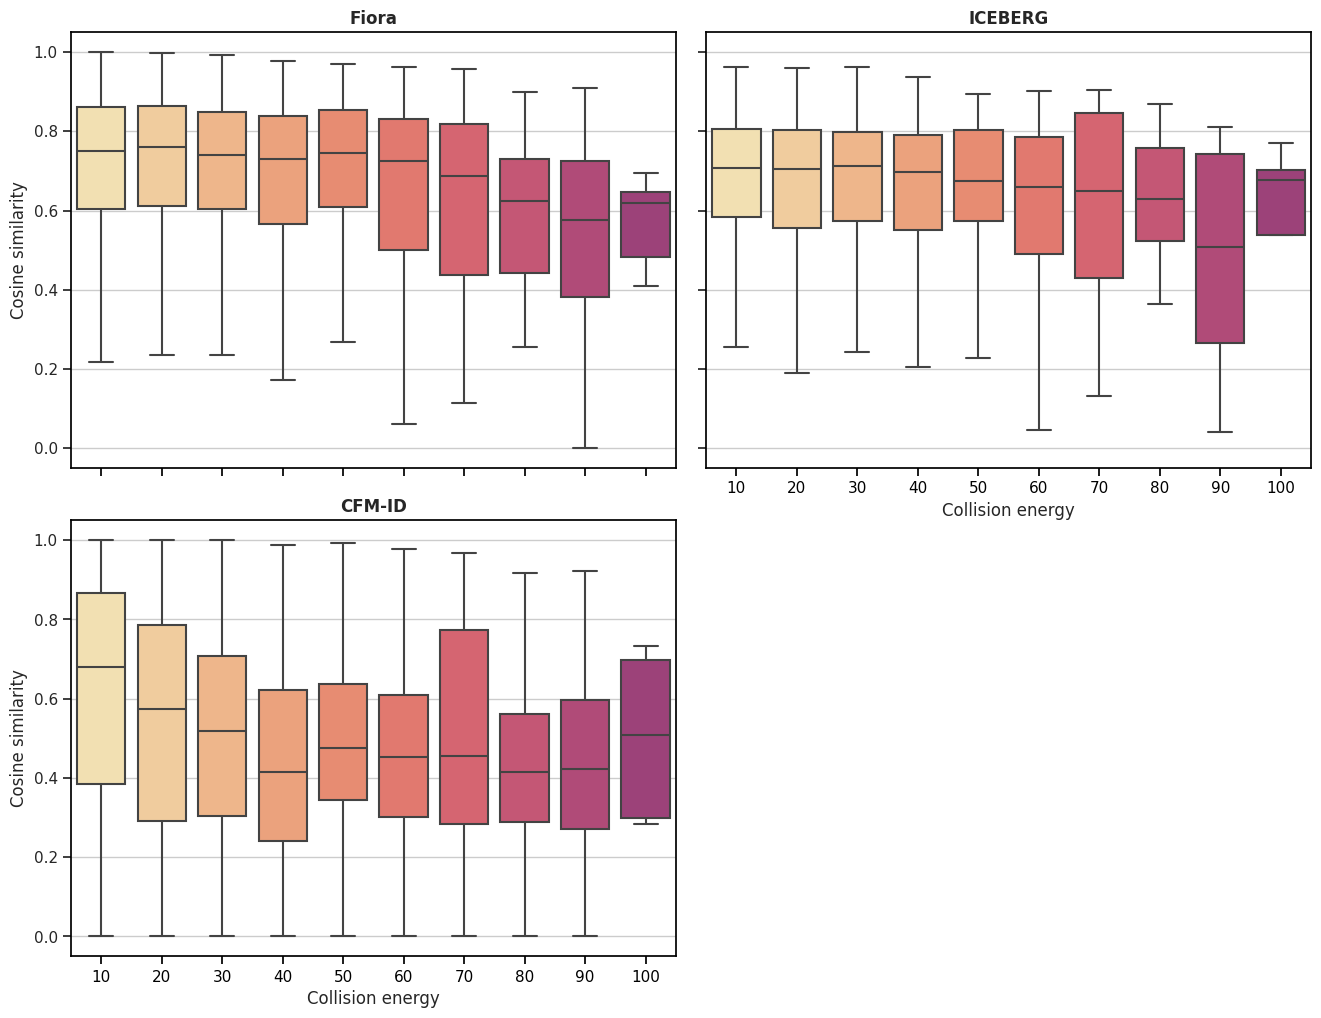

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16,12), gridspec_kw={'width_ratios': [1, 1]}, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.12, wspace=0.05)#top=0.94, bottom=0.12, right=0.97, left=0.08)

magma10 = sns.color_palette("magma_r", 18)[:10]
sns.boxplot(ax=axs[0,0], data=df_test, y="spectral_sqrt_cosine_wo_prec", x="CE_10", showfliers=False, palette=magma10, linewidth=1.5) # color="white", linewidth=2, linecolor="black")
axs[0,0].set_title("Fiora", fontweight="bold")
axs[0,0].set_ylabel("Cosine similarity")

sns.boxplot(ax=axs[0,1], data=df_test, y="ice_sqrt_cosine_wo_prec", x="CE_10", showfliers=False, palette=magma10, linewidth=1.5)
axs[0,1].set_title("ICEBERG", fontweight="bold")
axs[0,1].set_xlabel("Collision energy")
axs[0, 1].xaxis.set_label_position('bottom')
axs[0,1].set_xticklabels(list(range(10, 110, 10)))
axs[0, 1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)  # Ensure tick labels visibility
axs[0, 1].xaxis.label.set_visible(True)

sns.boxplot(ax=axs[1,0], data=df_test, y="cfm_sqrt_cosine_wo_prec", x="CE_10", showfliers=False, palette=magma10, linewidth=1.5)
axs[1,0].set_title("CFM-ID", fontweight="bold")
axs[1,0].set_xlabel("Collision energy")
axs[1,0].set_ylabel("Cosine similarity")

axs[1, 1].remove()

# fig.savefig(f"{home}/images/paper/cosine_ce_wo_prec.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/cosine_ce_wo_prec.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/cosine_ce_wo_prec.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()



In [ ]:
df_test.columns

Index(['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type',
       'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet',
       'Ionization',
       ...
       'num_non_precursor_matches', 'num_peak_match_conflicts',
       'num_fragment_conflicts', 'rel_fragment_conflicts', 'ms_num_all_peaks',
       'tanimoto', 'tanimoto3', 'filtered_peaks', 'num_filtered_peaks',
       'CE_10'],
      dtype='object', length=135)

/tmp/ipykernel_2553345/3138722524.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, y="coverage", x="CE_10", showfliers=False, palette=magma10, linewidth=1.5) # color="white", linewidth=2, linecolor="black")
/tmp/ipykernel_2553345/3138722524.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(range(10, 110, 10)))


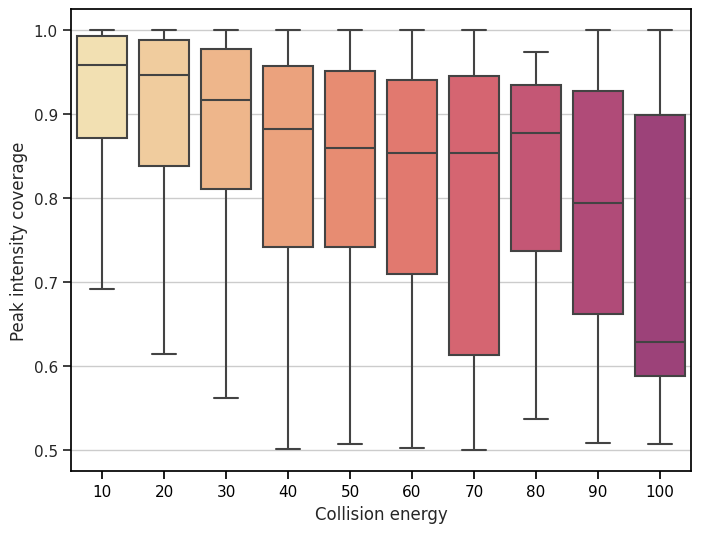

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True, sharey=True)

sns.boxplot(data=df_test, y="coverage", x="CE_10", showfliers=False, palette=magma10, linewidth=1.5) # color="white", linewidth=2, linecolor="black")
ax.set_xticklabels(list(range(10, 110, 10)))
ax.set_xlabel("Collision energy")
ax.set_ylabel("Peak intensity coverage")
# fig.savefig(f"{home}/images/paper/coverage_ce.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/coverage_ce.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/coverage_ce.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
sns.boxplot(df_test, y="ice_sqrt_cosine", x="CE_10")


<Axes: xlabel='CE_10', ylabel='ice_sqrt_cosine'>

In [ ]:
sns.scatterplot(df_test, y="cfm_sqrt_cosine", x="CE")


<Axes: xlabel='CE_10', ylabel='ice_sqrt_cosine'>

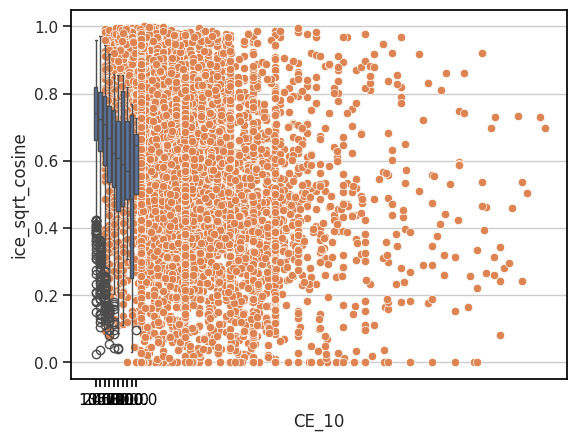

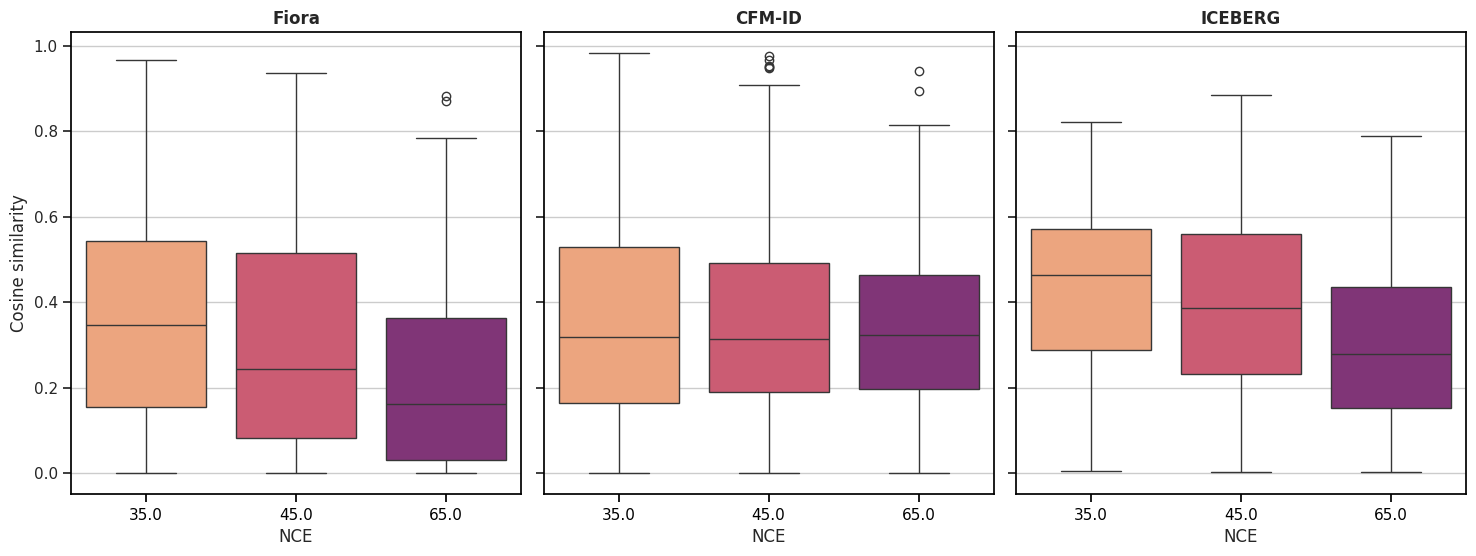

In [ ]:
magma = sns.color_palette("magma_r", 4)
fig, axs = plt.subplots(1, 3, figsize=(18,6), gridspec_kw={'width_ratios': [1, 1, 1]}, sharey=True)
plt.subplots_adjust(wspace=0.05)

sns.boxplot(ax=axs[0], data=df_cas22, y="spectral_sqrt_cosine_wo_prec", x="NCE", hue="NCE", palette=magma[:3])
#sns.boxplot(ax=axs[1], data=df_cas22, y="filtered_cosine", x="NCE", hue="NCE", palette=magma[:3])

sns.boxplot(ax=axs[1], data=df_cas22, y="cfm_sqrt_cosine_wo_prec", x="NCE", hue="NCE", palette=magma[:3])
sns.boxplot(ax=axs[2], data=df_cas22, y="ice_sqrt_cosine_wo_prec", x="NCE", hue="NCE", palette=magma[:3])
axs[0].set_title("Fiora", fontweight="bold")
axs[1].set_title("CFM-ID", fontweight="bold")
axs[2].set_title("ICEBERG", fontweight="bold")
axs[0].set_ylabel("Cosine similarity")
for ax in axs:
    ax.get_legend().remove()

# fig.savefig(f"{home}/images/paper/casmi22_nce_wo_prec.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/casmi22_nce_wo_prec.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/casmi22_nce_wo_prec.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()


### Coverage

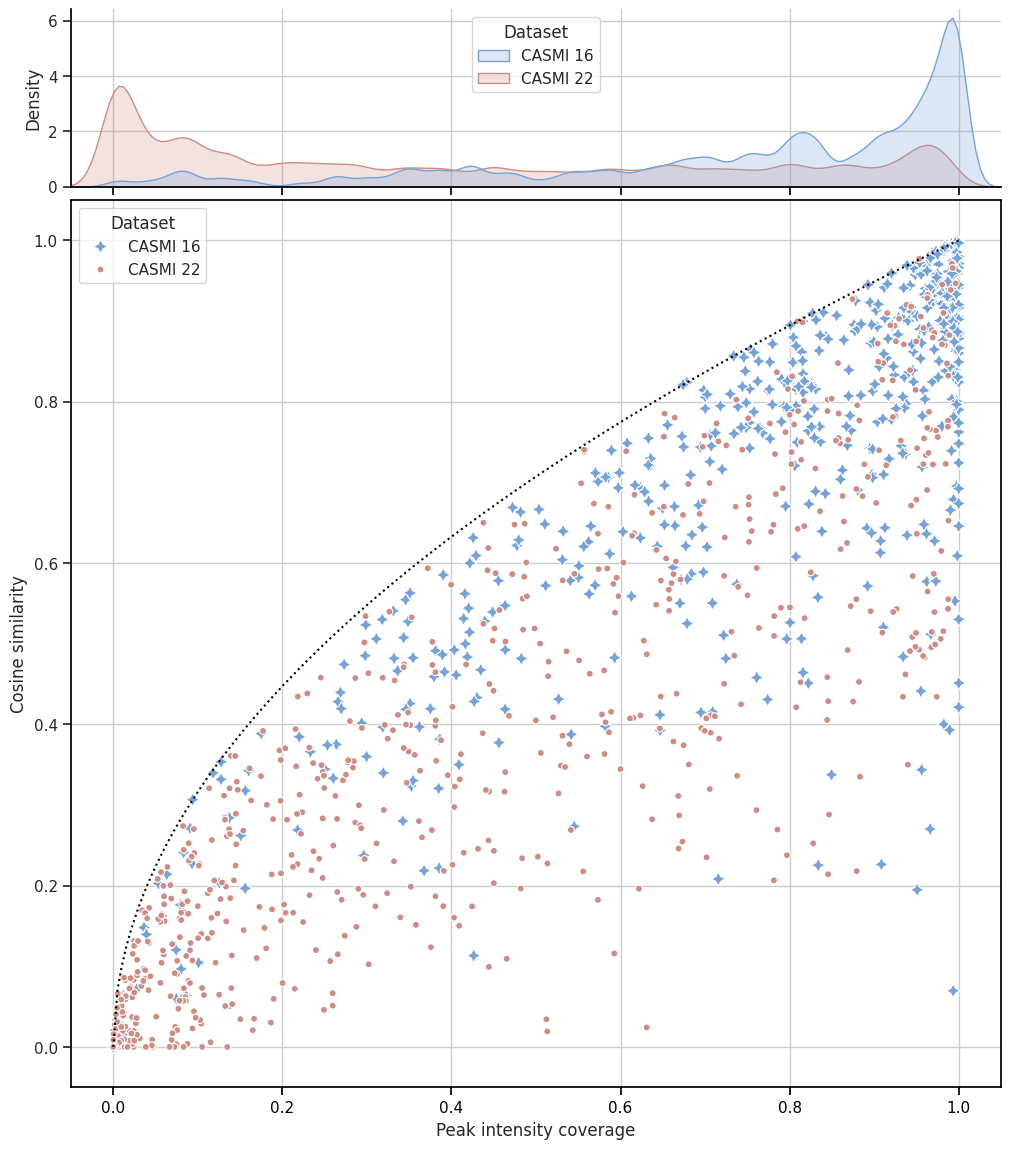

In [ ]:
set_light_theme()
fig, axs = plt.subplots(2, 1, figsize=(12, 14), sharex=True, gridspec_kw={'height_ratios': [1, 5]})
plt.subplots_adjust(hspace=0.025)#right=0.975, left=0.11)
#sns.histplot(ax=axs[0], data=df_cas22, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
plt.rc('legend', loc="upper center")
sns.kdeplot(ax=axs[0], data=CAT[CAT["Dataset"].isin(["CASMI 16", "CASMI 22"])], x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
#axs[0].legend(loc='upper center')
plt.xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])
# Generating x values
x = np.linspace(0, 1, 200)
y = np.sqrt(x)
sns.lineplot(x=x, y=y, color="black", linestyle="dotted")

#axs[0].set_title("Impact of coverage on cosine scores")
sns.scatterplot(ax=axs[1], data=CAT[CAT["Dataset"].isin(["CASMI 16", "CASMI 22"])], x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[(4,1,0), "."], s=100, palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
axs[1].set_ylabel("Cosine similarity")
axs[1].set_xlabel("Peak intensity coverage")
axs[1].legend(title="Dataset", loc='upper left')
# fig.savefig(f"{home}/images/paper/coverage_top_only.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/coverage_top_only.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/coverage_top_only.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


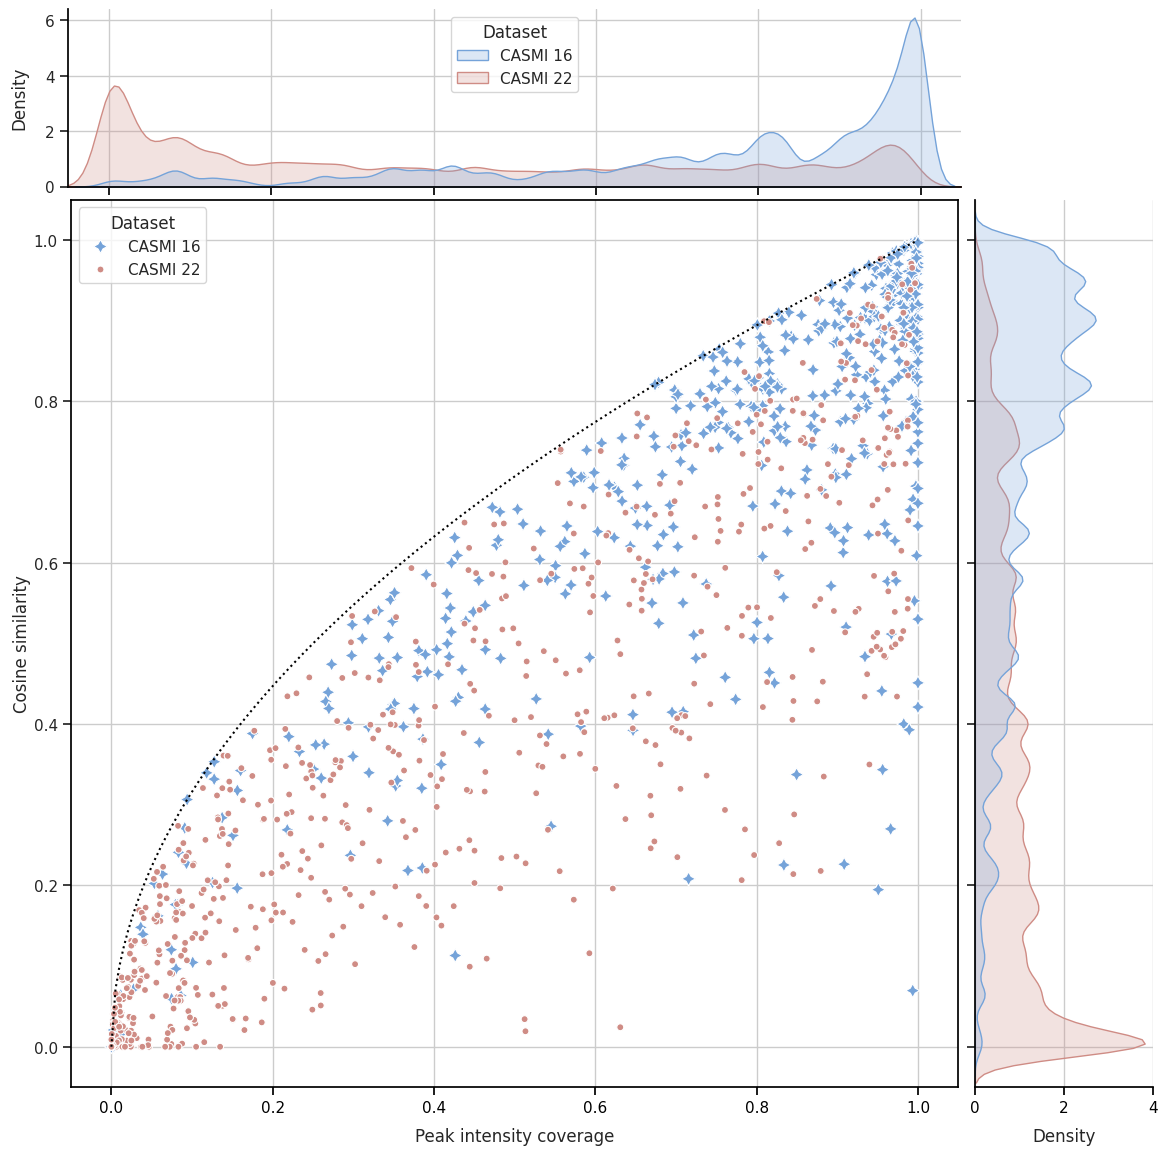

In [ ]:
set_light_theme()
fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharex=False, sharey=False, gridspec_kw={'height_ratios': [1, 5], 'width_ratios': [5, 1]})
plt.subplots_adjust(hspace=0.025, wspace=0.025)#hspace=0.025)#right=0.975, left=0.11)
#sns.histplot(ax=axs[0], data=df_cas22, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
plt.rc('legend', loc="upper center")
sns.kdeplot(ax=axs[0,0], data=CAT[CAT["Dataset"].isin(["CASMI 16", "CASMI 22"])], x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type", 
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].set_xlim([-0.05, 1.05])
axs[0,0].set_xlabel("")
axs[0,0].set_xticklabels("")
#axs[0].legend(loc='upper center')
axs[1,0].set_xlim([-0.05, 1.05])
axs[1,0].set_ylim([-0.05, 1.05])
axs[1, 0].set_aspect('equal')
# Generating x values
x = np.linspace(0, 1, 200)
y = np.sqrt(x)
sns.lineplot(x=x, y=y, color="black", linestyle="dotted", ax=axs[1,0])


#axs[0].set_title("Impact of coverage on cosine scores")
sns.scatterplot(ax=axs[1,0], data=CAT[CAT["Dataset"].isin(["CASMI 16", "CASMI 22"])], x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[(4,1,0), "."], s=100, palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
axs[1,0].set_ylabel("Cosine similarity")
axs[1,0].set_xlabel("Peak intensity coverage")
axs[1,0].legend(title="Dataset", loc='upper left')


# Box plots

sns.kdeplot(ax=axs[1,1], data=CAT[CAT["Dataset"].isin(["CASMI 16", "CASMI 22"])], y="spectral_sqrt_cosine", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type", 
#sns.boxplot(ax=axs[1,1], data=CAT[CAT["Dataset"] != "Test split"], y="spectral_sqrt_cosine", hue="Dataset", palette=tri_palette[1:])

axs[1,1].set_ylim(axs[1,0].get_ylim())
axs[1,1].set_ylabel("")
axs[1,1].set_yticklabels("")
axs[1,1].legend().remove()
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
fig.delaxes(axs[0, 1])

for ax in axs.flat:
    ax.yaxis.set_label_coords(-0.045, 0.5)  # Distance from y-axis to ylabel
    ax.xaxis.set_label_coords(0.5, -0.045)  # Distance from x-axis to xlabel



# fig.savefig(f"{home}/images/paper/coverage.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/coverage.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/coverage.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [ ]:
import numpy as np

# Define the vectors
x1 = np.array([1, 0, 0])
y1 = np.array([0.5, 0.5, 0.0])

# Calculate the magnitudes of the vectors
magnitude_x1 = np.linalg.norm(x1)
magnitude_y1 = np.linalg.norm(y1)

# Normalize the vectors
normalized_x1 = x1 / magnitude_x1
normalized_y1 = y1 / magnitude_y1

print("Normalized x1:", normalized_x1)
print("Normalized y1:", normalized_y1)

from fiora.MS.spectral_scores import cosine

print("Cosine:", cosine(normalized_x1, normalized_y1))

Normalized x1: [1. 0. 0.]
Normalized y1: [0.70710678 0.70710678 0.        ]
Cosine: 0.7071067811865476


/tmp/ipykernel_2553345/575537753.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(ax=axs[0], data=df_test, x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type",
/tmp/ipykernel_2553345/575537753.py:9: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(ax=axs[1], data=df_test, x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
/tmp/ipykernel_2553345/575537753.py:9: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(ax=axs[1], data=df_test, x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #,

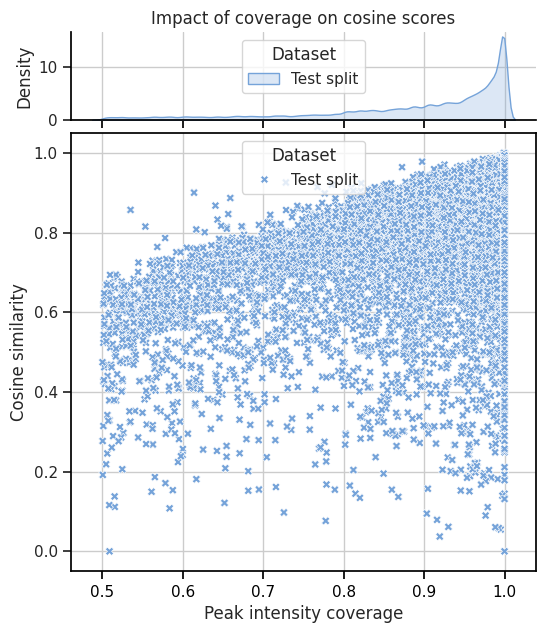

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7), sharex=True, gridspec_kw={'height_ratios': [1, 5]})
plt.subplots_adjust(hspace=0.05)#right=0.975, left=0.11)
#sns.histplot(ax=axs[0], data=df_cas22, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test, x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].set_title("Impact of coverage on cosine scores")
sns.scatterplot(ax=axs[1], data=df_test, x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
axs[1].set_ylabel("Cosine similarity")
axs[1].set_xlabel("Peak intensity coverage")
plt.show()

In [ ]:
df_cas.loc[17].is_priority

17     True
17    False
17    False
Name: is_priority, dtype: object

In [ ]:
ids = [17, 58, 68, 75, 102, 107, 128, 145, 163, 205]
example_input = df_cas[df_cas["is_priority"]].loc[ids].copy()[["SMILES", "avg_CE", "Precursor_type", "Instrument_type", "peaks"]]
example_input["CE"] = example_input["avg_CE"].astype(int)
example_input["Name"] = [f"Example_{i}" for i in range(example_input.shape[0])]
# example_input[["Name", "SMILES", "Precursor_type", "CE", "Instrument_type"]].to_csv("../examples/example_input.csv", index=False)
example_input[["Name", "SMILES", "Precursor_type", "CE", "Instrument_type"]]

,Name,SMILES,Precursor_type,CE,Instrument_type
17,Example_0,CC1=CC(=O)OC2=CC(OS(O)(=O)=O)=CC=C12,[M-H]-,17,HCD
58,Example_1,CC12CCC3C(CCC4=CC(OS(O)(=O)=O)=CC=C34)C1CCC2=O,[M-H]-,24,HCD
68,Example_2,ClC1=CC=C(NC(=O)NC2=CC=C(Cl)C(Cl)=C2)C=C1,[M-H]-,21,HCD
75,Example_3,Oc1c(Cl)cc(Cl)cc1C(=O)Nc1ccc(Cl)c(Cl)c1,[M-H]-,24,HCD
102,Example_4,NC(=O)\C=C\C1=CC=CC=C1,[M+H]+,10,HCD
107,Example_5,ClC1=CC2=C(C=C1)N(C1CCN(CCCN3C(=O)NC4=C3C=CC=C...,[M+H]+,29,HCD
128,Example_6,C1CCC(CC1)NC1=NC2=CC=CC=C2S1,[M+H]+,16,HCD
145,Example_7,CCCCC1=C(C)N=C(NCC)N=C1OS(=O)(=O)N(C)C,[M+H]+,22,HCD
163,Example_8,CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=C...,[M+H]+,32,HCD
205,Example_9,FC1=CC(OC2=CC=C(C=C2Cl)C(F)(F)F)=CC=C1NC(=O)NC...,[M+H]+,34,HCD


In [ ]:
for key in df_msnlib_test.iloc[0]["Metabolite"].match_stats.keys():
    df_msnlib_test[key] = df_msnlib_test["Metabolite"].apply(lambda x: x.match_stats[key])
    df_test[key] = df_test["Metabolite"].apply(lambda x: x.match_stats[key])
    df_cas[key] = df_cas["Metabolite"].apply(lambda x: x.match_stats[key])
    df_cas22[key] = df_cas22["Metabolite"].apply(lambda x: x.match_stats[key])
    C[key] = C["Metabolite"].apply(lambda x: x.match_stats[key])


In [ ]:
C.groupby("Precursor_type")["precursor_raw_prob"].mean()

NameError: name 'C' is not defined

Save dataframe as excel file

In [ ]:


# columns = ["Name", "Dataset", "lib", "origin", "SMILES", "InChI", "InChIKey", "Superclass", "Class", "Precursor_type", "Instrument_type", "PrecursorMZ", "CE", "NCE", "CCS", "CCS_pred", "RT", "RT_pred", 'spectral_cosine', 'spectral_sqrt_cosine',
#        'spectral_sqrt_cosine_wo_prec', 'spectral_refl_cosine', 'spectral_bias',
#        'spectral_sqrt_bias', 'spectral_sqrt_bias_wo_prec', 'spectral_refl_bias', 
#        'cfm_sqrt_cosine', 'cfm_refl_cosine', 'cfm_sqrt_cosine_wo_prec', 'ice_name', 
#        'ice_cosine','ice_sqrt_cosine', 'ice_sqrt_cosine_wo_prec', "coverage", "coverage_wo_prec", 'precursor_raw_prob', 'num_peak_matches', 'percent_peak_matches', 'tanimoto3'] 
# C[columns].to_excel(f"{home}/images/paper/SourceData.xlsx")


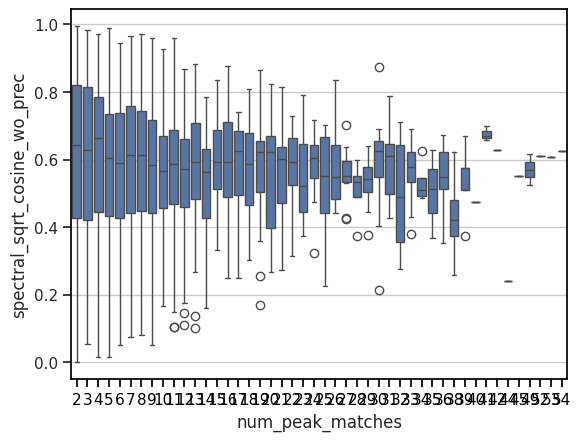

In [ ]:
sns.boxplot(df_msnlib_test, x="num_peak_matches", y="spectral_sqrt_cosine_wo_prec")
plt.show()

In [ ]:
df_low = df_msnlib_test[df_msnlib_test["spectral_sqrt_cosine"] < 0.3]

In [ ]:
# for key in df_msnlib_test.iloc[0]["Metabolite"].match_stats.keys():
#     sns.histplot(data=df_low, x=key)
#     plt.show()

(76, 142)
14 Challenge-015


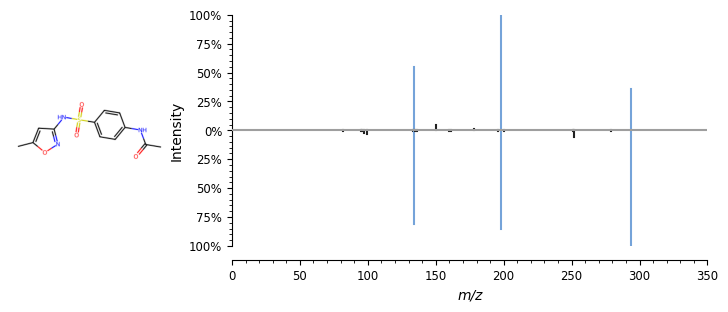

24 Challenge-025


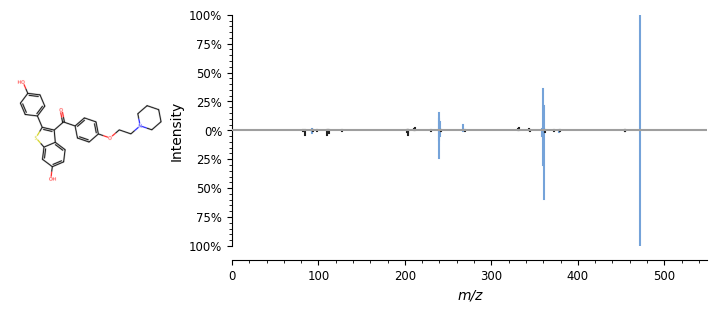

52 Challenge-053


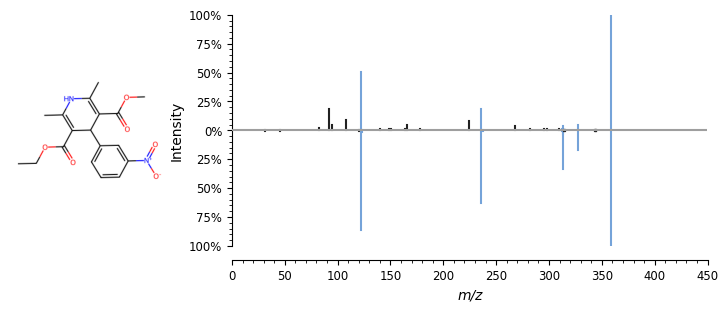

54 Challenge-055


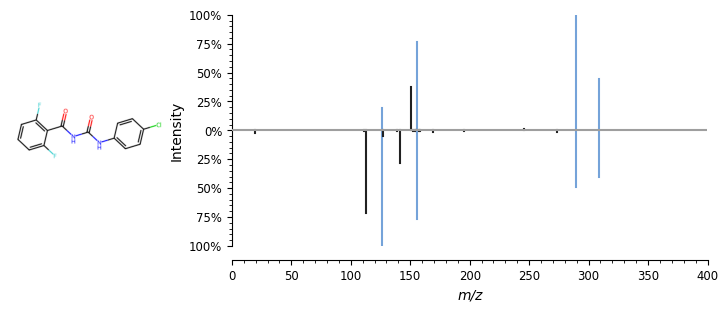

99 Challenge-100


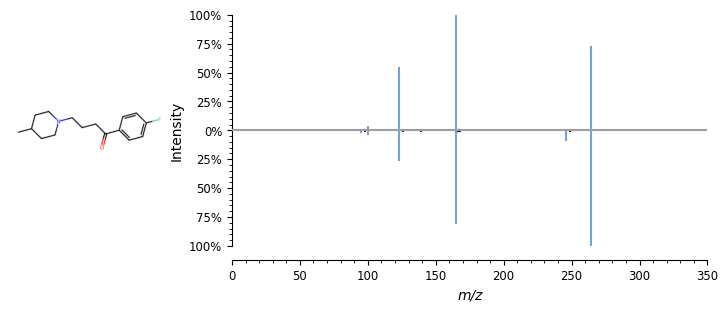

In [ ]:
reset_matplotlib()

df_print = df_cas[(df_cas["merged_sqrt_cosine"] > 0.70) & (df_cas["merged_sqrt_bias"] < 0.6)]
#df_print = df_test[(df_test["spectral_sqrt_cosine"] > 0.85) & (df_test["spectral_sqrt_bias"] < 0.6) & (df_test["lib"] == "MSDIAL")]

print(df_print.shape)
for i, data in df_print.head(5).iterrows():
    fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])
    print(i, data["ChallengeName"])
    sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
    plt.show()

In [ ]:
def peaks_by_intensity(peaks):
    z = zip(peaks["mz"], peaks["intensity"], peaks["annotation"])
    return sorted(z, key=lambda x: x[1], reverse=True)

In [ ]:
df_test.head()

,Name,Synon,Notes,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Sample_inlet,Ionization,...,num_non_precursor_matches,num_peak_match_conflicts,num_fragment_conflicts,rel_fragment_conflicts,ms_num_all_peaks,tanimoto,tanimoto3,filtered_peaks,num_filtered_peaks,CE_10
2303,1-Hexadecanoyl-2-octadecadienoyl-sn-glycero-3-...,PC(16:0/18:2),Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,758.5694,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,1,0,0,0.000000,6,1.0,0.951807,"{'mz': [758.57, 184.07], 'intensity': [999.0, ...",2,10.0
2304,1-Hexadecanoyl-2-octadecadienoyl-sn-glycero-3-...,PC(16:0/18:2),Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,758.5694,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,3,0,0,0.000000,10,1.0,0.951807,"{'mz': [758.57, 184.07], 'intensity': [999.0, ...",2,10.0
2305,1-Hexadecanoyl-2-octadecadienoyl-sn-glycero-3-...,PC(16:0/18:2),Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,758.5694,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,2,0,0,0.000000,9,1.0,0.951807,"{'mz': [758.57, 184.07], 'intensity': [999.0, ...",2,10.0
2306,1-Hexadecanoyl-2-octadecadienoyl-sn-glycero-3-...,PC(16:0/18:2),Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,758.5694,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,3,1,1,0.333333,9,1.0,0.951807,"{'mz': [758.57, 184.07], 'intensity': [999.0, ...",2,10.0
2307,1-Hexadecanoyl-2-octadecadienoyl-sn-glycero-3-...,PC(16:0/18:2),Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,758.5694,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,2,0,0,0.000000,11,1.0,0.951807,"{'mz': [184.07, 758.57], 'intensity': [999.0, ...",2,20.0


In [ ]:
# df_print = df_test[(df_test["spectral_sqrt_cosine"] > 0.7) & (df_test["spectral_sqrt_bias"] < 0.7) & (df_test["lib"] == "MSDIAL")]

# print(df_print.shape)
# for i, data in df_print.iterrows():
#     fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
#     img = data["Metabolite"].draw(ax= axs[0])
#     print(i)
#     sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
#     plt.show()
    
    
smallbutrelatable = [85073, 80082, 1916, 80698, 80083, 82664, 83920, 84096, 84102, 84110, 85073, 89637, 90222, 95985, 95988]

for i in smallbutrelatable:
    data = df_test.loc[i]
    print(i, data["CE"], data["Precursor_type"])
    f = peaks_by_intensity(data["sim_peaks"])
    fig, ax = plt.subplots(1,1,figsize=(1.5,1.5))
    Metabolite(f[0][2].split("//")[0]).draw()
    plt.show()
    fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])
    sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
    plt.show()

KeyError: 85073

### Example

In [ ]:
df_train[df_train["Name"] == "Indole-3-acetyl-L-alanine"]["Metabolite"].iloc[0].tanimoto_similarity(data["Metabolite"])


: 

In [ ]:
### GOLD EXAMPLE
data = df_test.loc[80082]
print(data["Name"], data["group_id"])
reset_matplotlib()

f = peaks_by_intensity(data["sim_peaks"])
print(f[0])
Metabolite(f[0][2].split("//")[0]).draw()
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
img = data["Metabolite"].draw(ax= axs[0])


sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
# fig.savefig(f"{home}/images/paper/ex_mirror.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(9,3))
sv.plot_spectrum(data, ax=ax)
# fig.savefig(f"{home}/images/paper/ex_original.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()
fig, ax = plt.subplots(1, 1, figsize=(9,3))
sv.plot_spectrum({"peaks": data["sim_peaks"]}, ax=ax)
# fig.savefig(f"{home}/images/paper/ex_prediction.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()


: 

In [ ]:
df_test[df_test["Name"] == "Indole-3-acetyl-L-alanine"]

: 

In [ ]:
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors


h_plus = Chem.MolFromSmiles("[H+]")
Chem.Descriptors.ExactMolWt(h_plus)

: 

In [ ]:
s="C=c1c[nH+]c2ccccc12"
#s="C=C1C=[NH+]C2=C1C=CC=C2"
m = Metabolite(s)
m.draw()
plt.show()
m.ExactMolWeight

: 

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg

save_fragments = True

for i in range(len(f)):
    print(f[i])
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    m = Metabolite(f[i][2].split("//")[0])
    m.draw()
    plt.show()
    if save_fragments:
        drawer = rdMolDraw2D.MolDraw2DSVG(500, 500)
        drawer.DrawMolecule(m.MOL)
        drawer.FinishDrawing()
        cairosvg.svg2pdf(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule_f{i}.pdf")
        cairosvg.svg2svg(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule_f{i}.svg")


: 

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg

#fig, ax = plt.subplots(1,1, figsize=(10, 10))
#data["Metabolite"].draw(ax= ax)

if False:
    drawer = rdMolDraw2D.MolDraw2DSVG(500, 500)
    drawer.DrawMolecule(data["Metabolite"].MOL)
    drawer.FinishDrawing()
    cairosvg.svg2pdf(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule.pdf")
    cairosvg.svg2svg(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule.svg")

: 

In [ ]:

import matplotlib.patches as mpatches

def double_mirrorplot(i, model_title="Fiora"):
    fig, axs = plt.subplots(1, 3, figsize=(16.8, 4.2), gridspec_kw={'width_ratios': [1, 3, 3]}, sharey=False)
    
    plt.subplots_adjust(right=0.975, left=0.025)
    
    img = df_cas.loc[i]["Metabolite"].draw(ax= axs[0])

    axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
    axs[0].set_title(df_cas.loc[i]["NAME"] + "\n(" +  df_cas.loc[i]["ChallengeName"]+ ")")
    axs[0].imshow(img)
    axs[0].axis("off")

    sv.plot_spectrum({"peaks": df_cas.loc[i]["peaks"]}, {"peaks": df_cas.loc[i]["merged_peaks"]}, ax=axs[1])
    axs[1].title.set_text(model_title)
    patch1 = mpatches.Patch(color='limegreen' if df_cas.loc[i]["ice_sqrt_cosine"] < df_cas.loc[i]["merged_sqrt_cosine"] else "orangered", label=f'cosine {df_cas.loc[i]["merged_sqrt_cosine"]:.02f}')
    axs[1].legend(handles=[patch1])

    sv.plot_spectrum({"peaks": df_cas.loc[i]["peaks"]}, {"peaks": df_cas.loc[i]["ice_peaks"]} if df_cas.loc[i]["ice_peaks"] else {"peaks": {"mz": [0], "intensity": [0]}}, ax=axs[2])
    axs[2].title.set_text(f'ICEBERG')
    
    patch2 = mpatches.Patch(color='limegreen' if df_cas.loc[i]["ice_sqrt_cosine"] > df_cas.loc[i]["merged_sqrt_cosine"] else "orangered", label=f'cosine {df_cas.loc[i]["ice_sqrt_cosine"]:.02f}', )
    axs[2].legend(handles=[patch2])
    
    return fig, axs



: 

In [ ]:
# for i, d in df_cas[df_cas["Precursor_type"] == "[M+H]+"].iterrows():
#     double_mirrorplot(i)
#     plt.show()

: 

In [ ]:
sns.histplot(data=df_test, x="CE", hue="lib")
plt.show()

: 

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(8, 6), sharex=True)


sns.histplot(ax=axs[0], data=df_test[df_test["Precursor_type"] == "[M+H]+"], x="spectral_sqrt_cosine", hue="lib")
axs[0].set_title("[M+H]+ Test split")
sns.histplot(ax=axs[1], data=df_test[df_test["Precursor_type"] == "[M-H]-"], x="spectral_sqrt_cosine", hue="lib")
axs[1].set_title("[M-H]- Test split")
plt.show()

: 

In [ ]:

print(df_cas.groupby("Precursor_type")["coverage"].median())
fig, axs = plt.subplots(1,2, figsize=(12, 6))

sns.kdeplot(ax=axs[0], data=df_cas, x="coverage", hue="Precursor_type", bw_adjust=0.5)
sns.scatterplot(ax=axs[1], data=df_cas, x="coverage", y="spectral_sqrt_cosine", hue="Precursor_type")
axs[0].axvline(x=df_cas[df_cas["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
axs[1].axvline(x=df_cas[df_cas["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
plt.show()

: 

: 

In [ ]:
sns.kdeplot(df_cas22, x="CE", y="spectral_sqrt_cosine", hue="Precursor_type")#, hue="lib")
plt.show()

: 

: 

In [ ]:
df_test["pp_score_dif"] = df_test["spectral_sqrt_cosine"] - df_test["spectral_sqrt_cosine_wo_prec"]



: 

In [ ]:
sns.boxplot(df_test, x="pp_score_dif")#, hue="lib")
plt.xlim(-0.5, 0.5)
plt.show()

: 

In [ ]:
sns.scatterplot(df_test, x="pp_score_dif", y="pp", hue="CE")#, hue="lib")
plt.xlim(-0.2, 0.6)
plt.show()

: 

In [ ]:
sns.histplot(df_cas22, x="CE", hue="Precursor_type", binwidth=3)#, hue="lib")
plt.xlim(0, 100)
plt.show()

: 

In [ ]:
sns.histplot(df_cas, x="CE", hue="Precursor_type", hue_order=["[M+H]+", "[M-H]-"], binwidth=3)#, hue="lib")
plt.xlim(0, 100)
plt.show()

: 

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8, 4))

sns.boxplot(ax= axs[0], data=df_test, y="Precursor_ppm_error", hue="lib", showfliers=False)
sns.boxplot(ax= axs[1], data=df_test, y="Precursor_abs_error", hue="lib", showfliers=False)
plt.show()

: 

In [ ]:
print(list(df_test.columns))

#sns.kdeplot(df_test, x="CE", y="spectral_sqrt_cosine", hue="lib")
#plt.show()

: 

In [ ]:
sns.kdeplot(data=df_test[(df_test["Precursor_ppm_error"] < 1) & (df_test["Precursor_ppm_error"] < 2)], y="spectral_sqrt_cosine", x="Precursor_ppm_error", hue="lib")
plt.xlim(0, 2)
plt.show()

: 

#### TESTING CAST

In [ ]:
df_cast.groupby("Precursor_type")["spectral_sqrt_cosine"].median()

: 

In [ ]:

print(df_cast.groupby("Precursor_type")["coverage"].median())
fig, axs = plt.subplots(1,2, figsize=(12, 6))

sns.kdeplot(ax=axs[0], data=df_cast, x="coverage", hue="Precursor_type", bw_adjust=0.5)
sns.scatterplot(ax=axs[1], data=df_cast, x="coverage", y="spectral_sqrt_cosine", hue="Precursor_type")
axs[0].axvline(x=df_cast[df_cast["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
axs[1].axvline(x=df_cast[df_cast["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
plt.show()


: 

In [ ]:
for i,m in enumerate(df_cast["Metabolite"]):
    for m2 in df_train["Metabolite"]:
        if m == m2:
            print(i)
            print("Violation")
            break